In [38]:
def interpolate_to_common_time(psth, current_rate, target_rate, PERIEVENT_WINDOW):
    """Interpolate psth data to match the target sampling rate."""
    current_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], psth.shape[0])
    target_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], int((PERIEVENT_WINDOW[1] - PERIEVENT_WINDOW[0]) * target_rate))
    interpolated_psth = np.array([np.interp(target_time, current_time, psth[:, i]) for i in range(psth.shape[1])]).T
    return interpolated_psth

def plot_heatmap_psth_group(df_trials, psth_combined, EVENT="feedback_times", group_name='', PERIEVENT_WINDOW=[-1, 2], SAMPLING_RATE=30):
    """Plot side-by-side line plots for correct and incorrect trials with enhanced aesthetics."""
    
    # Extract correct and incorrect trials
    # psth_good = psth_combined[:, df_trials.feedbackType == 1]
    # psth_error = psth_combined[:, df_trials.feedbackType == -1]
    psth_good = psth_combined[:, df_trials.feedbackType.values == 1]
    psth_error = psth_combined[:, df_trials.feedbackType.values == -1]


    # Compute mean and SEM
    psth_good_avg = psth_good.mean(axis=1)
    sem_good = psth_good.std(axis=1) / np.sqrt(psth_good.shape[1])
    psth_error_avg = psth_error.mean(axis=1)
    sem_error = psth_error.std(axis=1) / np.sqrt(psth_error.shape[1])

    # Time axis
    time_axis = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], psth_combined.shape[0]) 

    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300, sharey=True)

    # Define colors
    correct_color = '#2f9c95'
    incorrect_color = '#d62828'
    shadow_color_correct = '#577590'
    shadow_color_incorrect = '#903749'

    # Correct trials average plot
    axes[0].plot(time_axis, psth_good_avg, linewidth=2.5, color=correct_color, label="Correct")
    axes[0].fill_between(time_axis, psth_good_avg - sem_good, psth_good_avg + sem_good, color=shadow_color_correct, alpha=0.15)
    axes[0].axvline(x=0, color="black", linestyle="--", linewidth=2, label="Event Onset")
    axes[0].set_xlabel(f"Time since {EVENT} (s)", fontsize=20)
    axes[0].set_ylabel("Calcium Signal", fontsize=20)
    axes[0].set_title(f"Correct Trials", fontsize=20, pad=15)
    
    # Incorrect trials average plot
    axes[1].plot(time_axis, psth_error_avg, linewidth=2.5, color=incorrect_color, label="Incorrect")
    axes[1].fill_between(time_axis, psth_error_avg - sem_error, psth_error_avg + sem_error, color=shadow_color_incorrect, alpha=0.15)
    axes[1].axvline(x=0, color="black", linestyle="--", linewidth=2, label="Event Onset")
    axes[1].set_xlabel(f"Time since {EVENT} (s)", fontsize=20)
    axes[1].set_title(f"Incorrect Trials", fontsize=20, pad=15)


    # Remove top and right spines
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=16)

    # Create custom legend patches for shaded error regions
    shadow_legend_correct = mpatches.Patch(color=shadow_color_correct, alpha=0.15, label="SEM (Correct)")
    shadow_legend_incorrect = mpatches.Patch(color=shadow_color_incorrect, alpha=0.15, label="SEM (Incorrect)")

    # Create legend and place it outside
    legend = axes[1].legend(
        handles=[shadow_legend_correct, shadow_legend_incorrect] + axes[1].get_legend_handles_labels()[0], 
        fontsize=16, frameon=False, loc="upper left", bbox_to_anchor=(1, 1), handlelength=1.8, handleheight=1
    )

    plt.suptitle(f'{group_name}_{EVENT}', fontsize=14)
    plt.tight_layout()
    plt.show() 
#     # Save figures
    # save_path_png = f'/mnt/h0/kb/Feb2025/plots/Chapter4/Fig02_perNM_{df_trials.mouse.iloc[0]}_{df_trials.date.iloc[0]}_{group_name}_correct.png'
    # save_path_pdf = f'/mnt/h0/kb/Feb2025/plots/Chapter4/Fig02_perNM_{df_trials.mouse.iloc[0]}_{df_trials.date.iloc[0]}_{group_name}_correct.pdf'
    # save_path_png = f'/mnt/h0/kb/Feb2025/plots/Chapter4/Fig02_perNM_{df_trials.mouse.iloc[0]}_{df_trials.date.iloc[0]}_{group_name}_incorrect.png'
    # save_path_pdf = f'/mnt/h0/kb/Feb2025/plots/Chapter4/Fig02_perNM_{df_trials.mouse.iloc[0]}_{df_trials.date.iloc[0]}_{group_name}_incorrect.pdf'

    # plt.savefig(save_path_png, dpi=300)
    # plt.savefig(save_path_pdf, dpi=300)
    plt.show()


def pad_to_match_length(arr, target_length):
    """Pad or trim an array to match the target length along the time axis."""
    current_length = arr.shape[0]
    if current_length == target_length:
        return arr
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(arr, ((0, padding), (0, 0)), mode='constant')
    else:
        return arr[:target_length, :]

def load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW):
    """Load and pad/interpolate psth and df_trials for a group of mice to a common length."""
    combined_psth = []
    combined_trials = []
    target_rate = 30
    max_time_length = 0

    for mouse in group_mice:
        try:
            psth_path_30 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_30Hz.npy')
            psth_path_15 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_15Hz.npy')
            df_trials_path_30 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_30Hz.pqt')
            df_trials_path_15 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_15Hz.pqt')
            
            if os.path.exists(psth_path_30):
                psth = np.load(psth_path_30)
                df_trials = pd.read_parquet(df_trials_path_30)
            elif os.path.exists(psth_path_15):
                psth = np.load(psth_path_15)
                psth = interpolate_to_common_time(psth, current_rate=15, target_rate=30, PERIEVENT_WINDOW=PERIEVENT_WINDOW)
                df_trials = pd.read_parquet(df_trials_path_15)
            else:
                continue

            max_time_length = max(max_time_length, psth.shape[0])
            combined_psth.append(psth)
            combined_trials.append(df_trials)
        
        except Exception as e:
            print(f"Error loading data for {mouse} | Event: {event}: {e}")
    
    if combined_psth and combined_trials:
        # Pad all PSTH arrays to match the longest one
        combined_psth = [pad_to_match_length(psth, max_time_length) for psth in combined_psth]
        psth_combined = np.concatenate(combined_psth, axis=1)
        df_trials_combined = pd.concat(combined_trials, ignore_index=True)
        return psth_combined, df_trials_combined
    else:
        return None, None

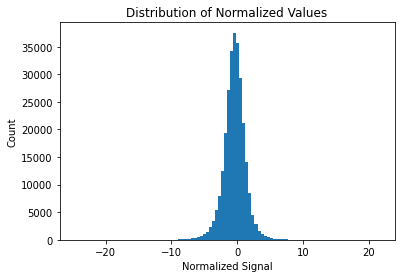

In [42]:
plt.hist(normalized.flatten(), bins=100)
plt.title("Distribution of Normalized Values")
plt.xlabel("Normalized Signal")
plt.ylabel("Count")
plt.show()


<ipython-input-43-b57b617df318>:187: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('magma_r')


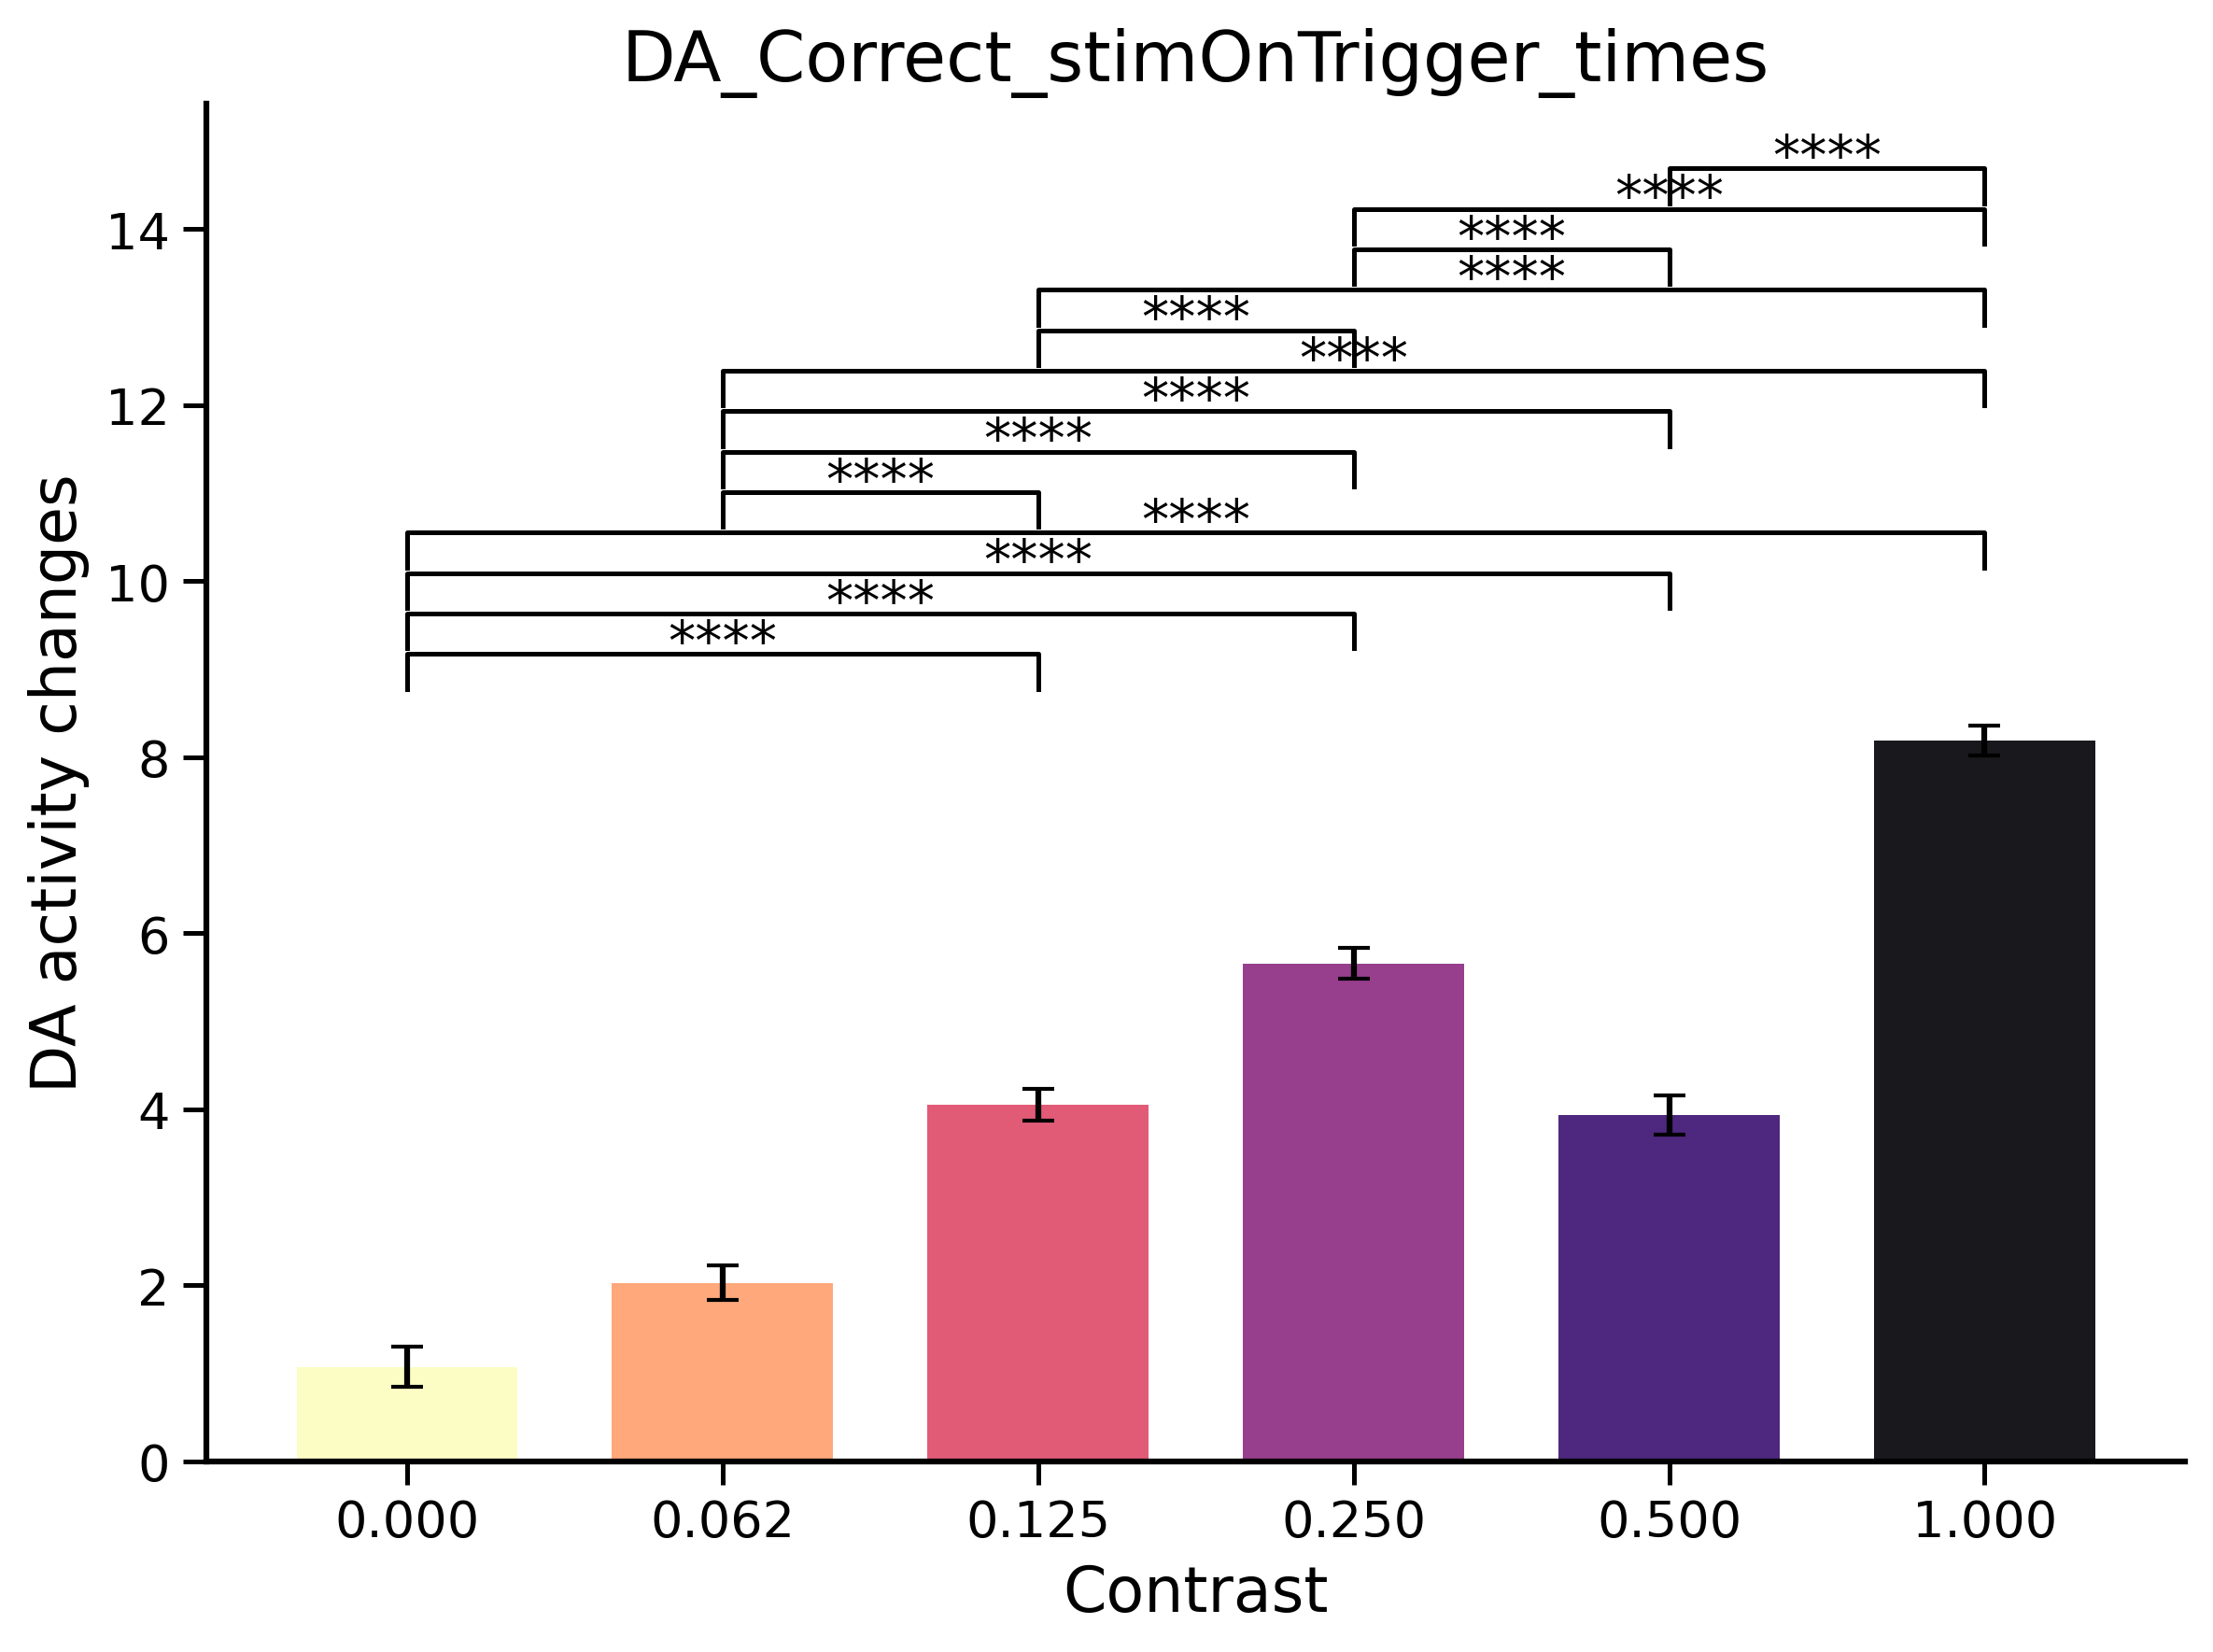

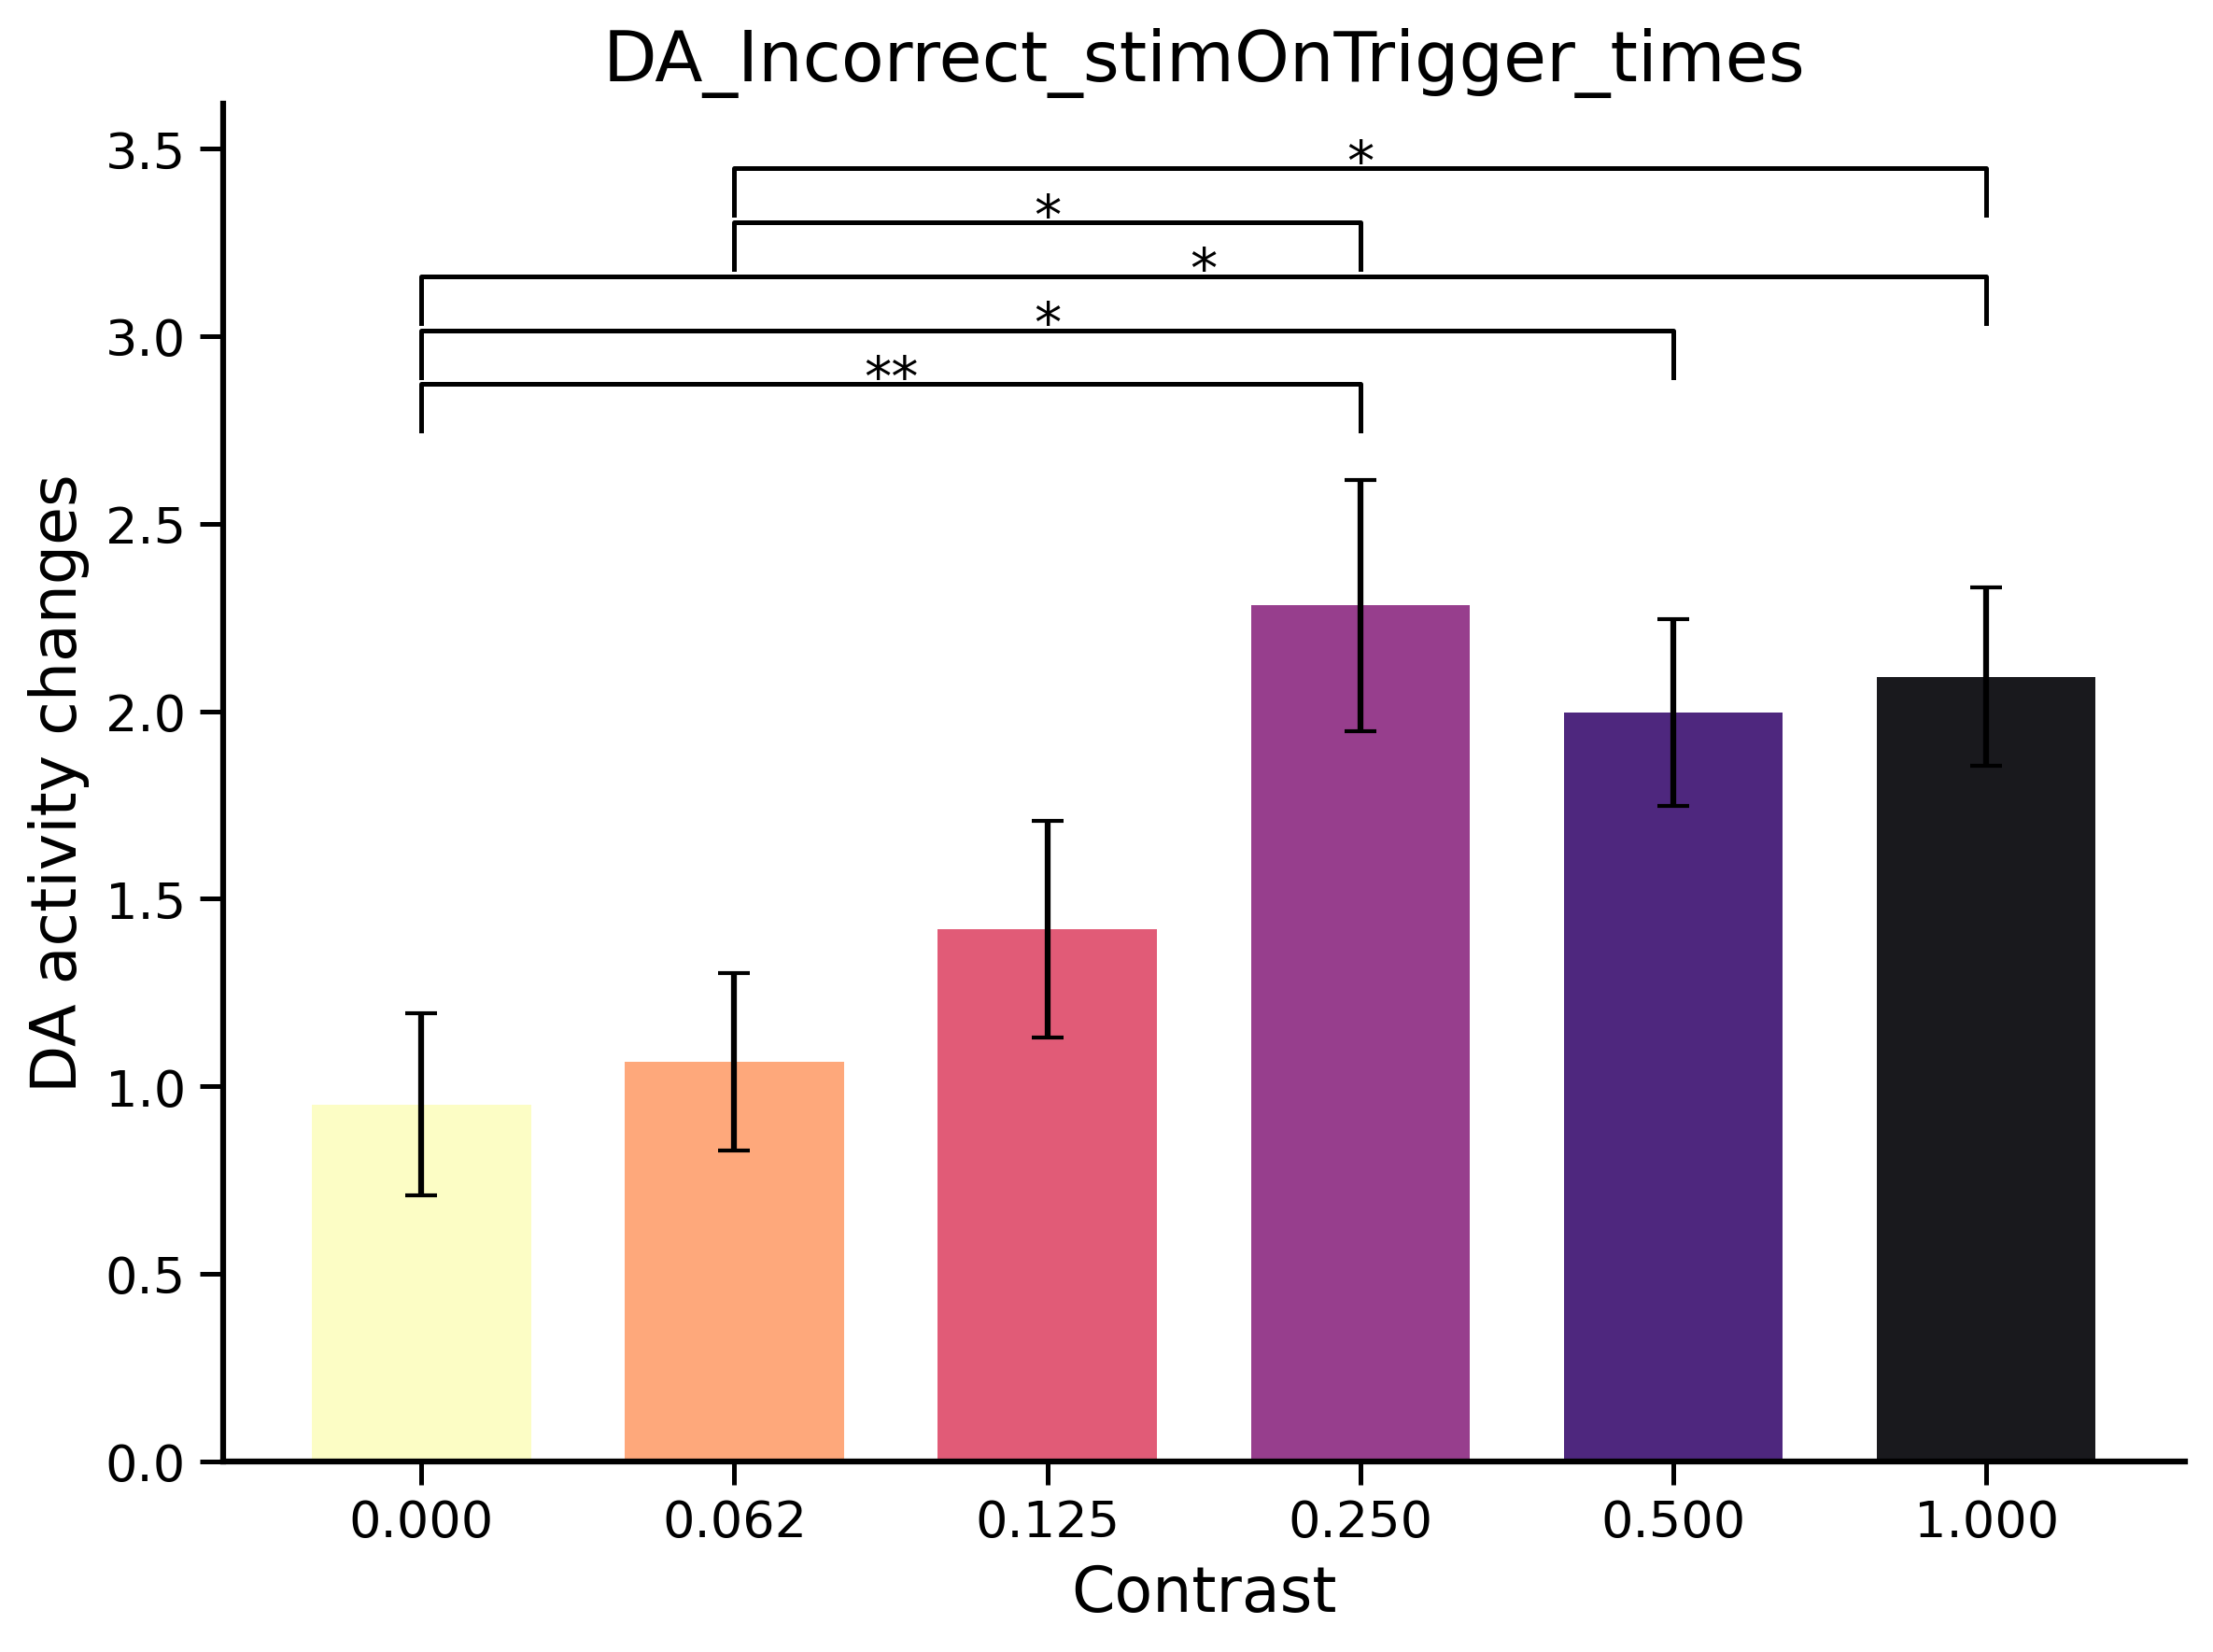

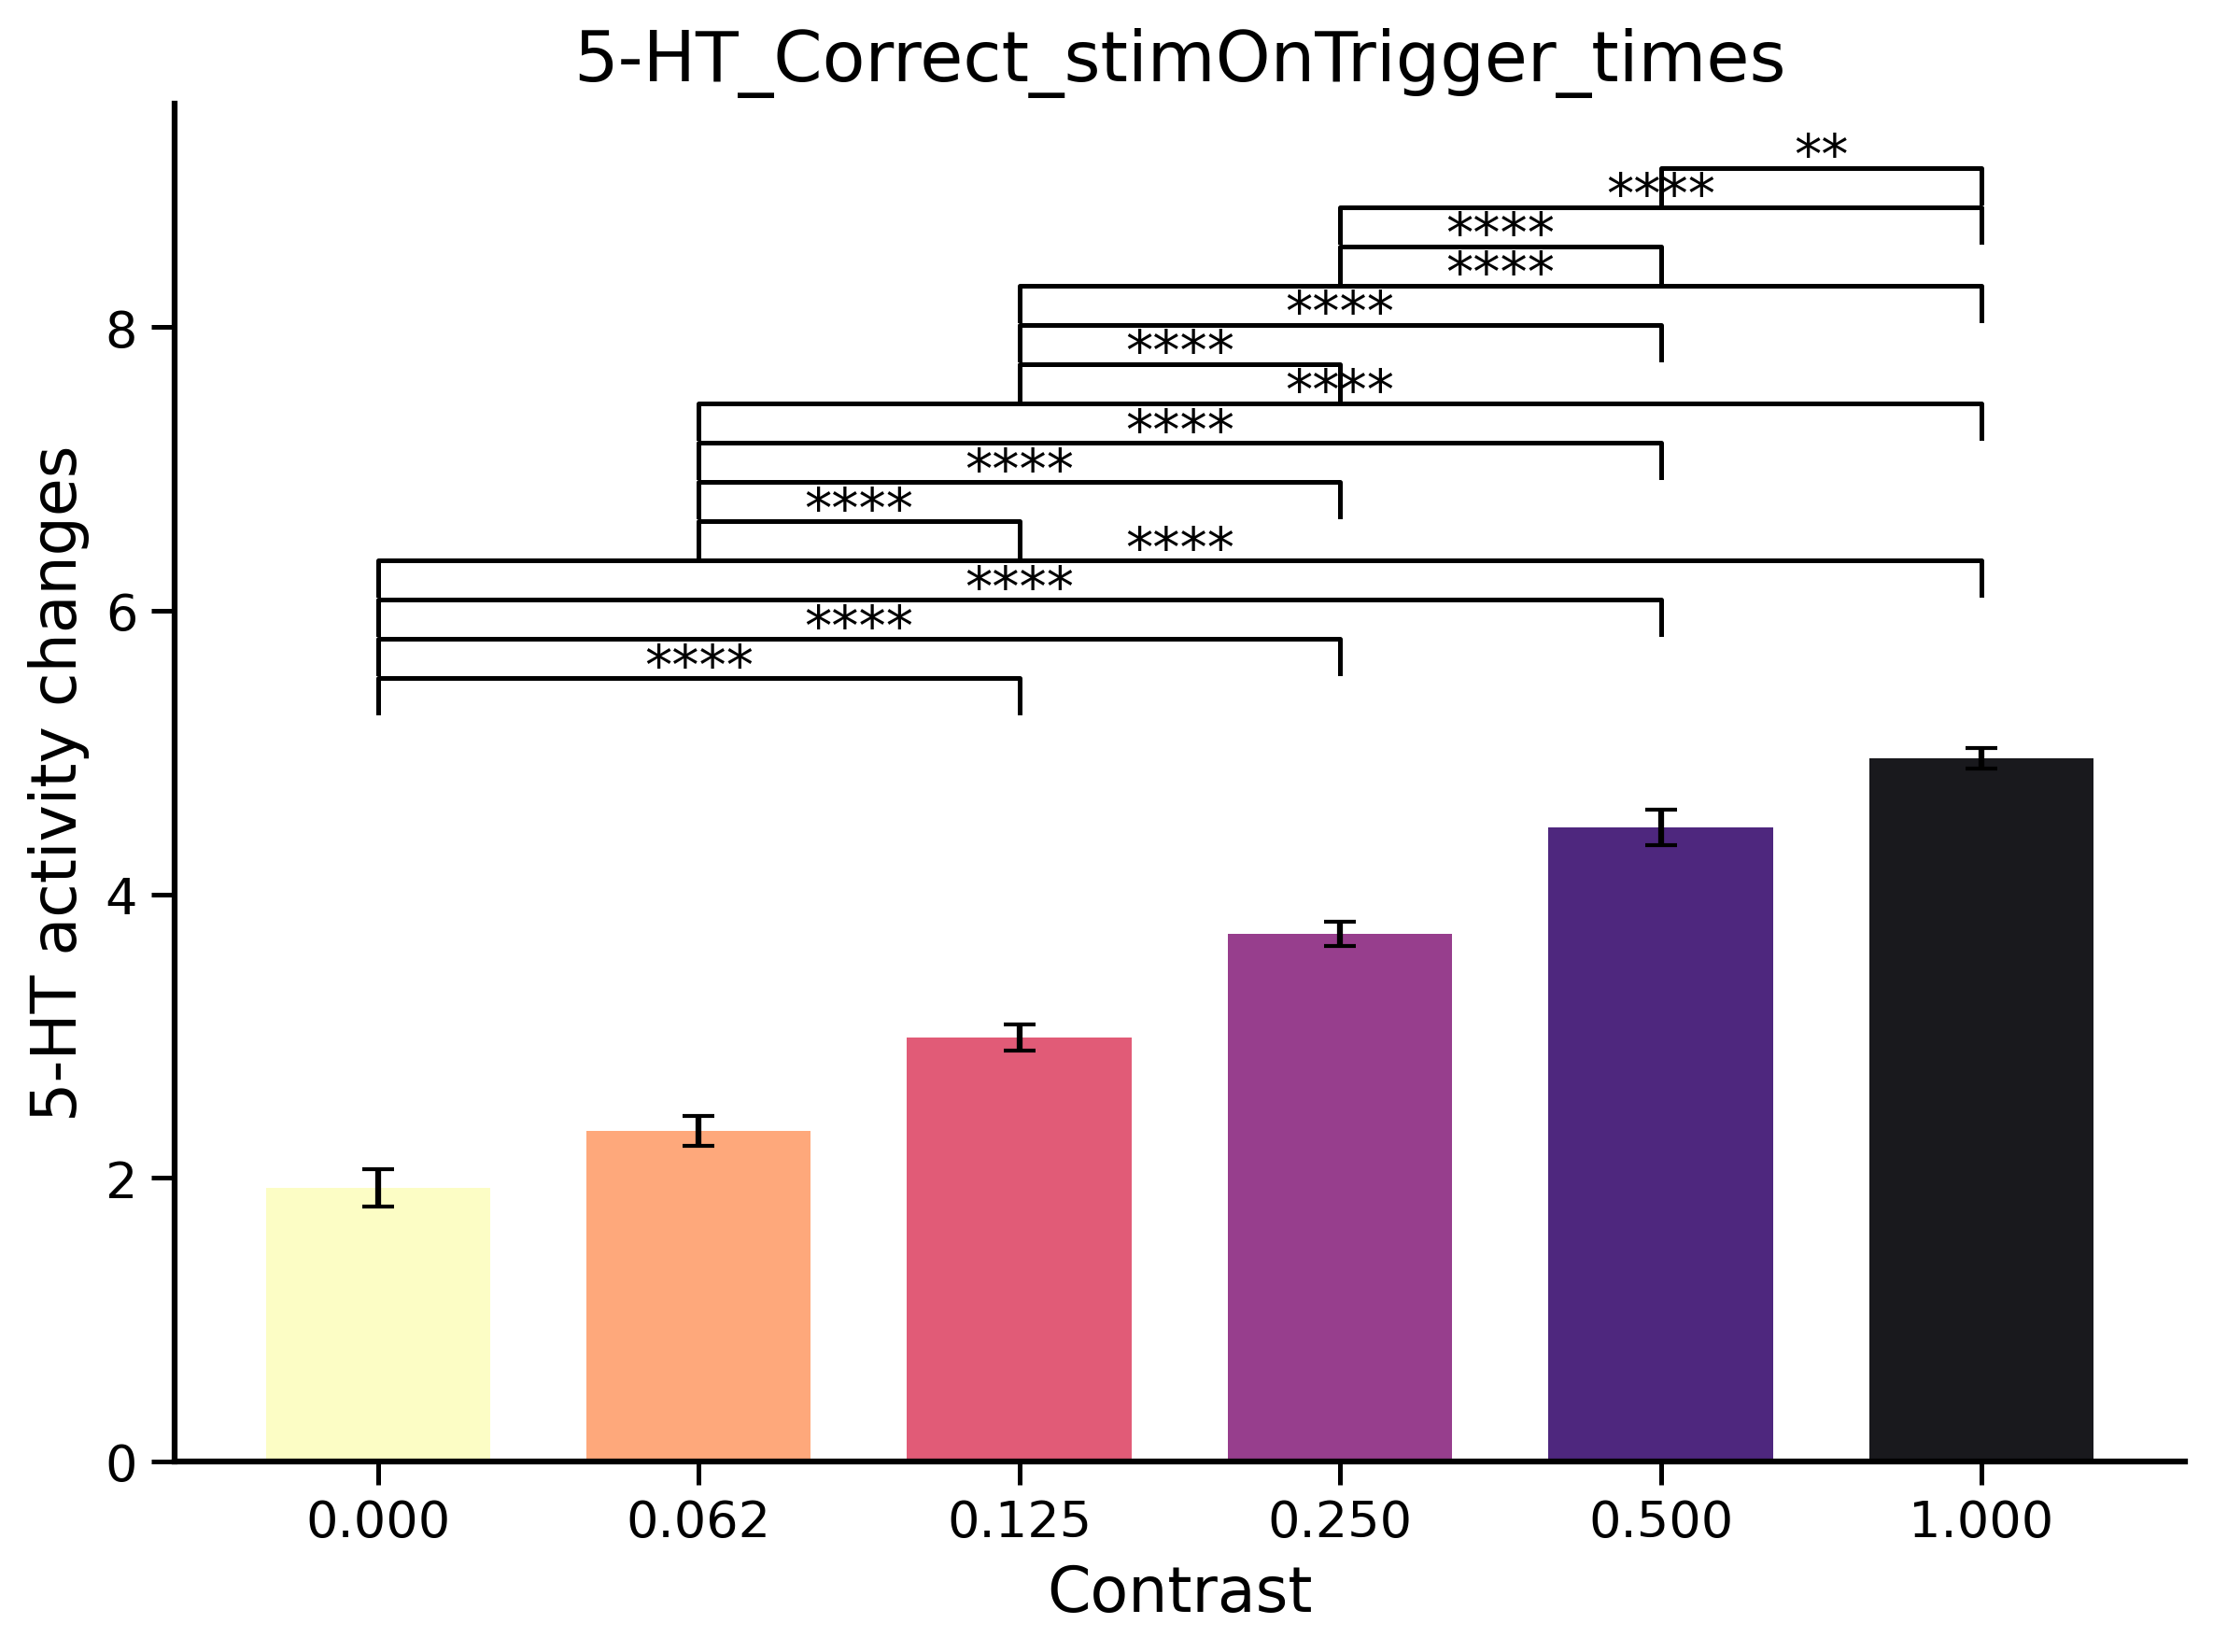

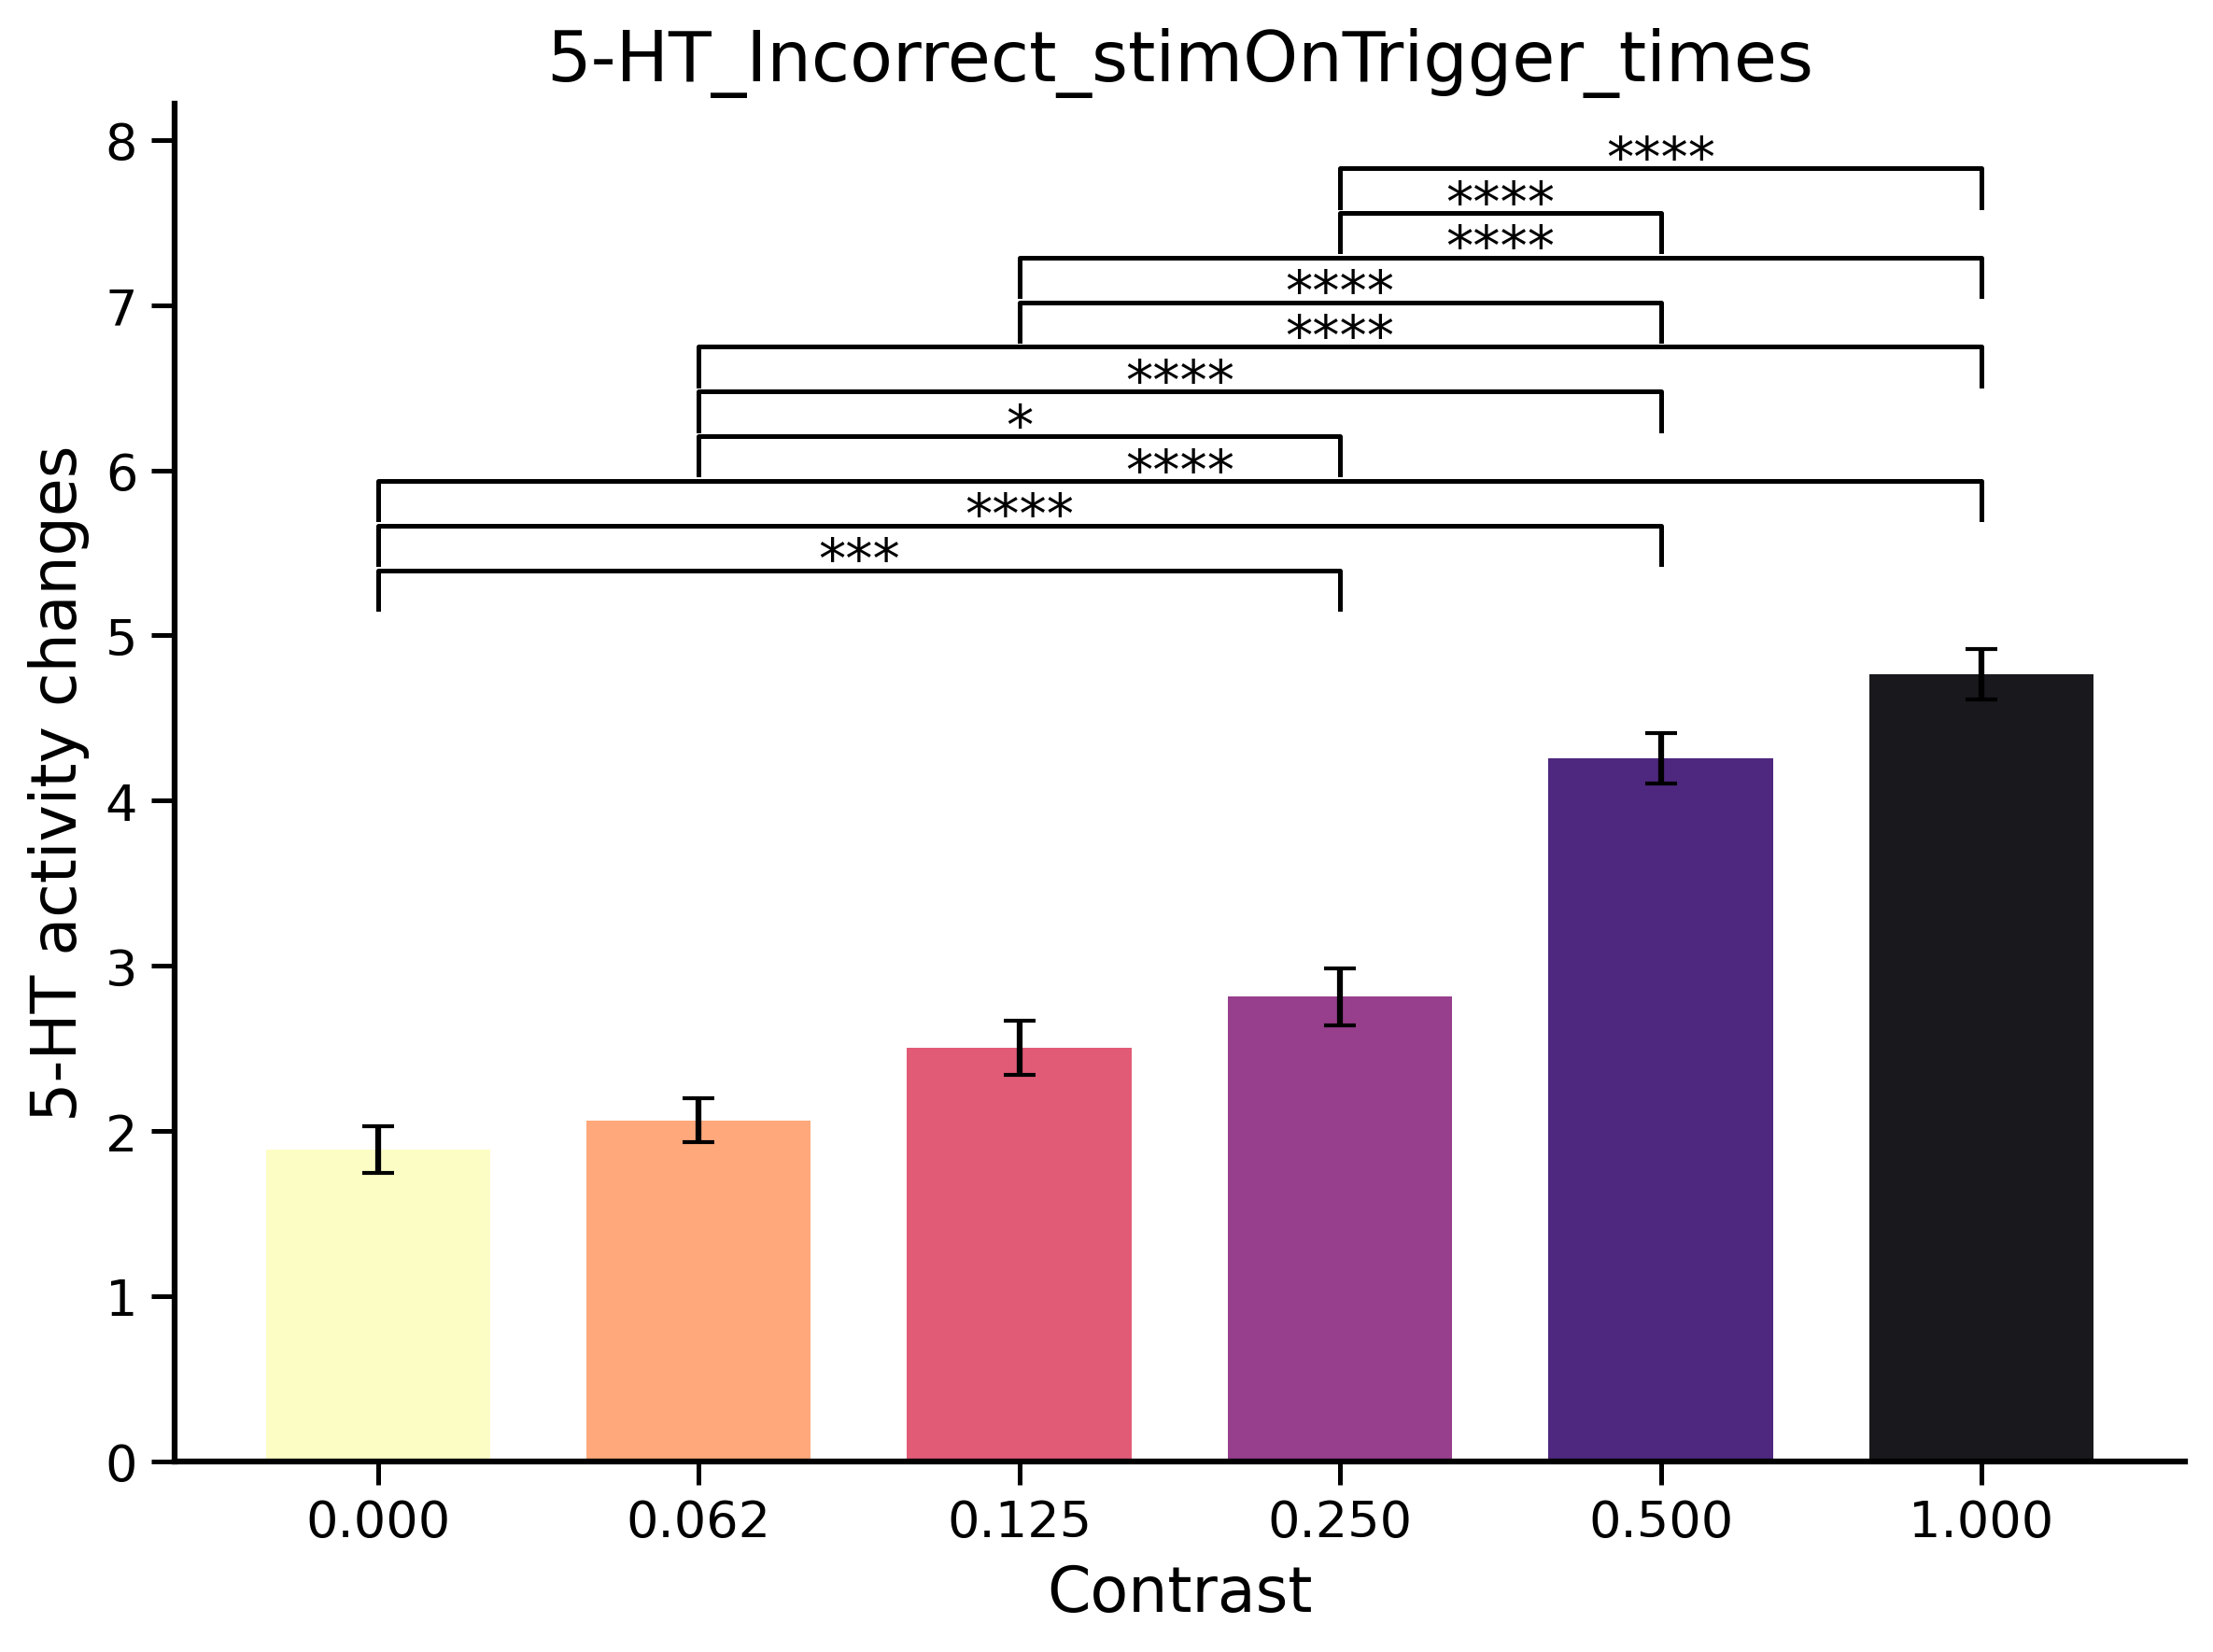

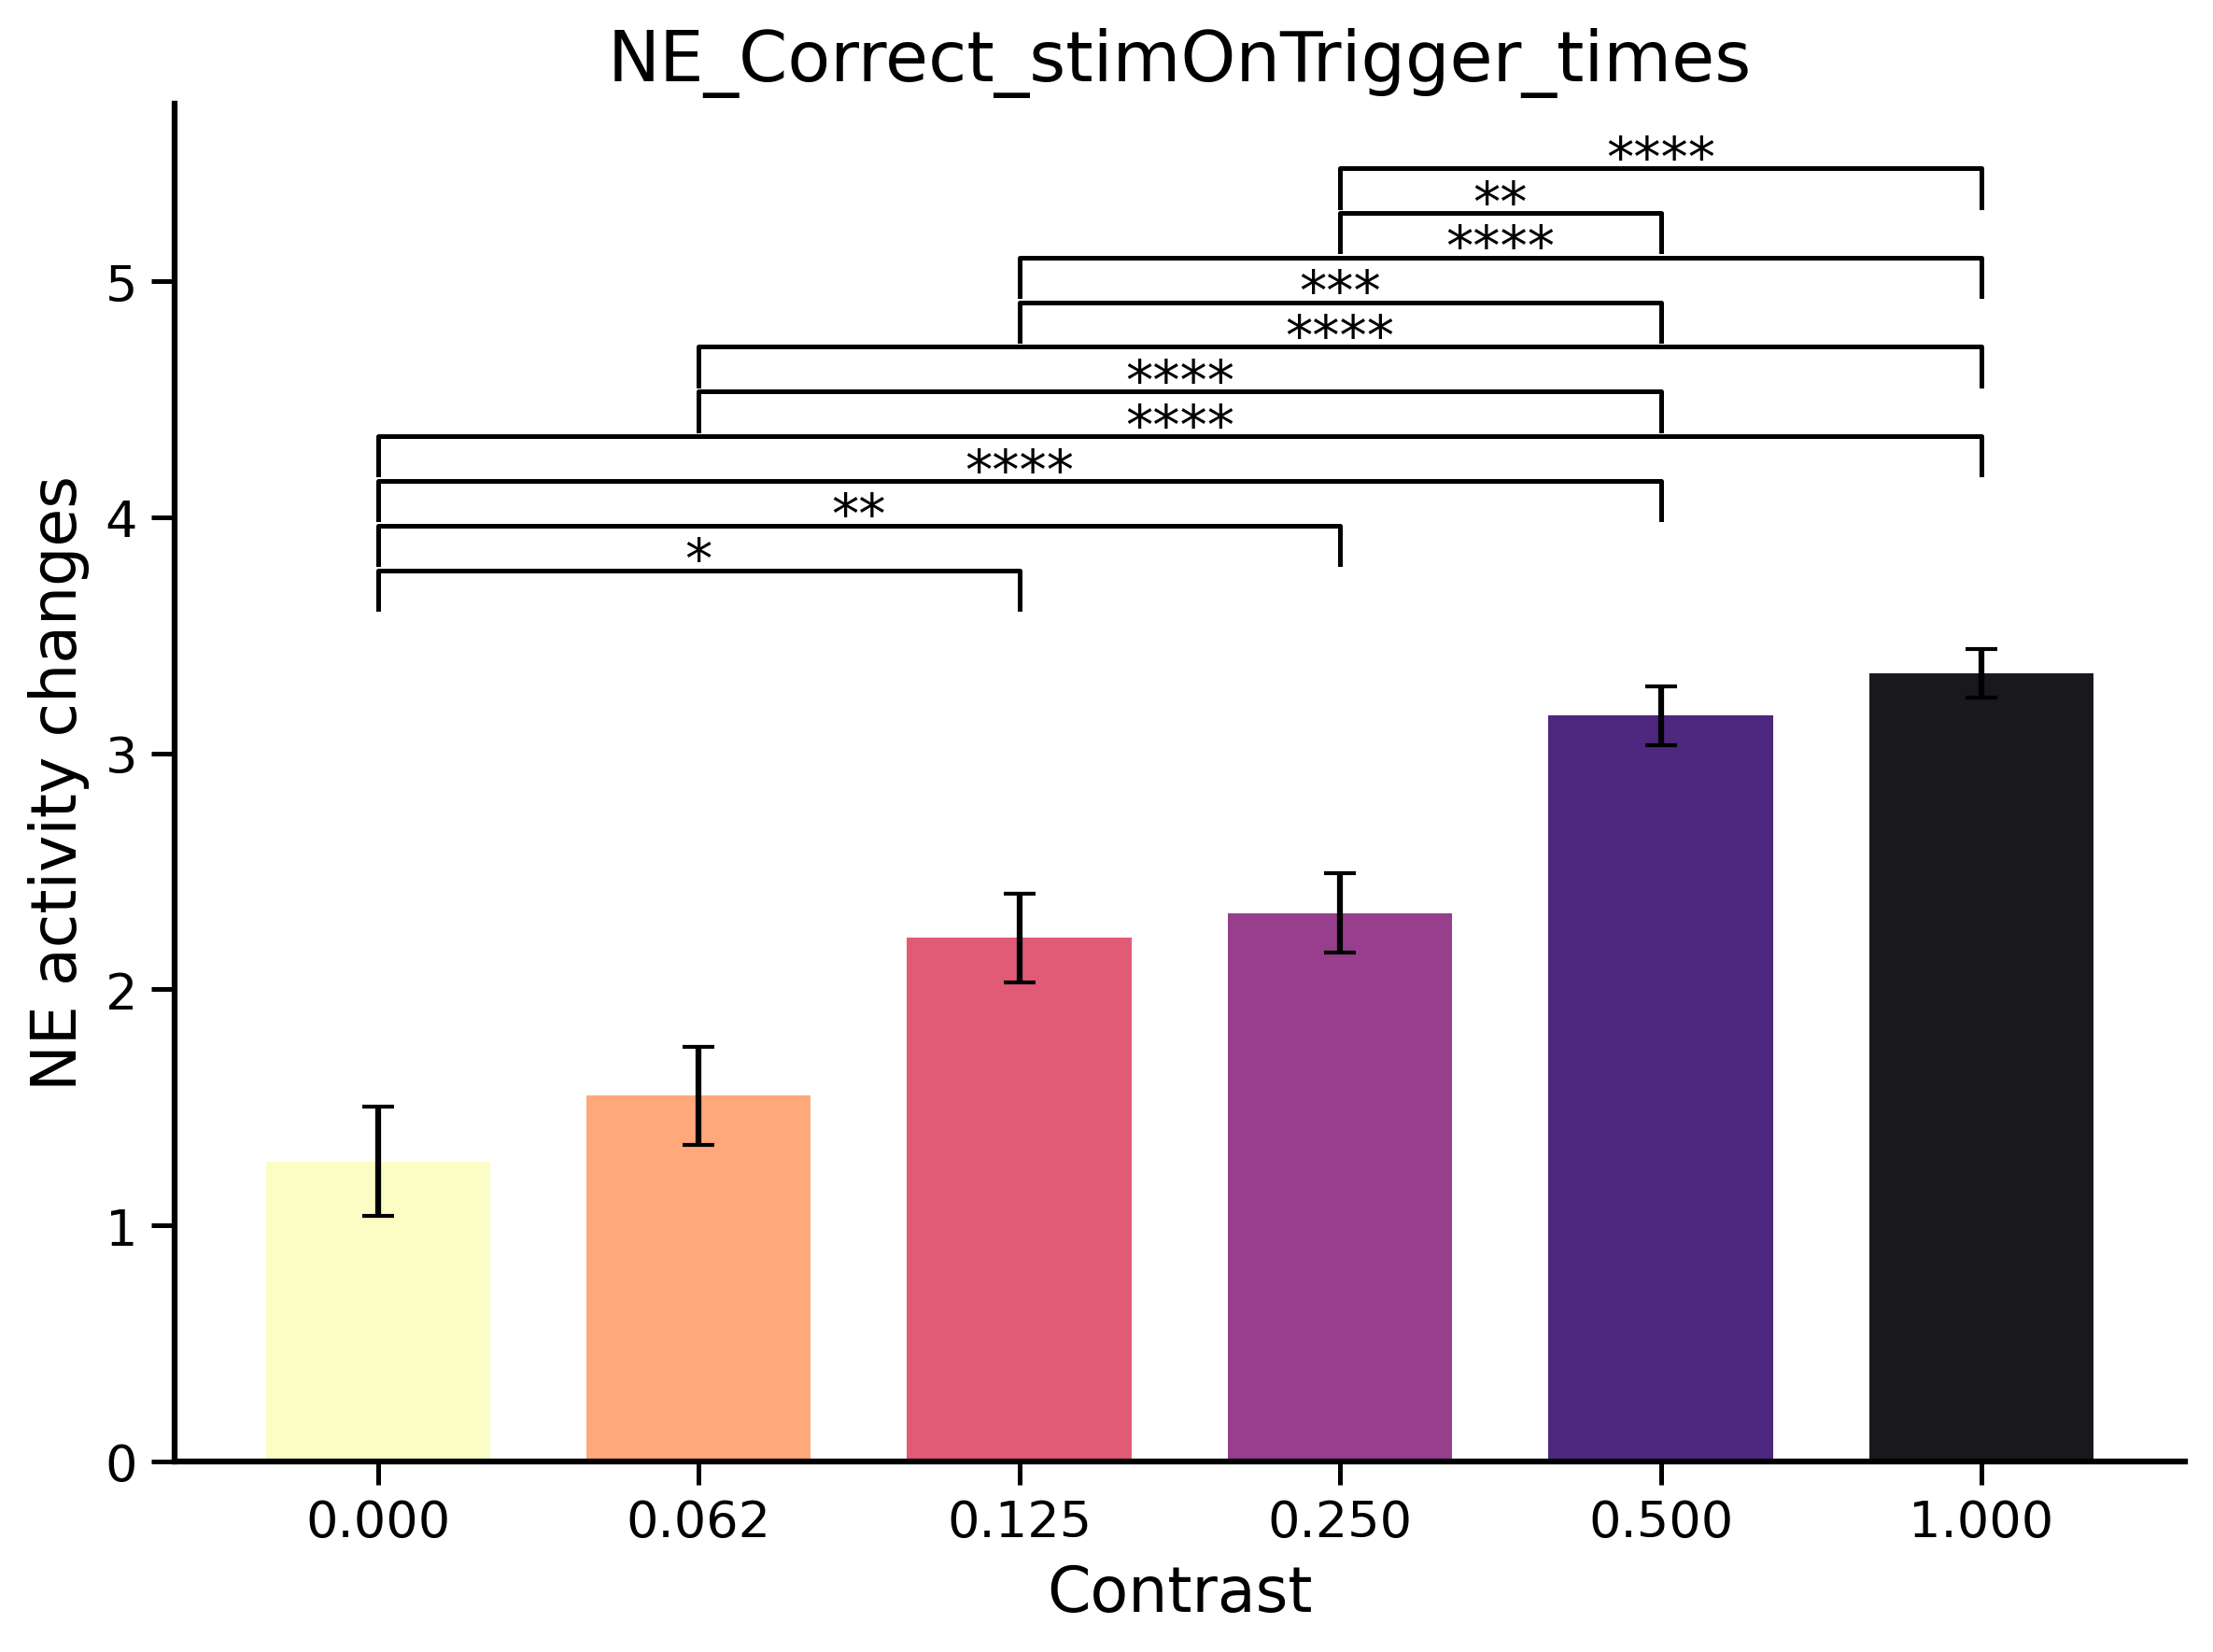

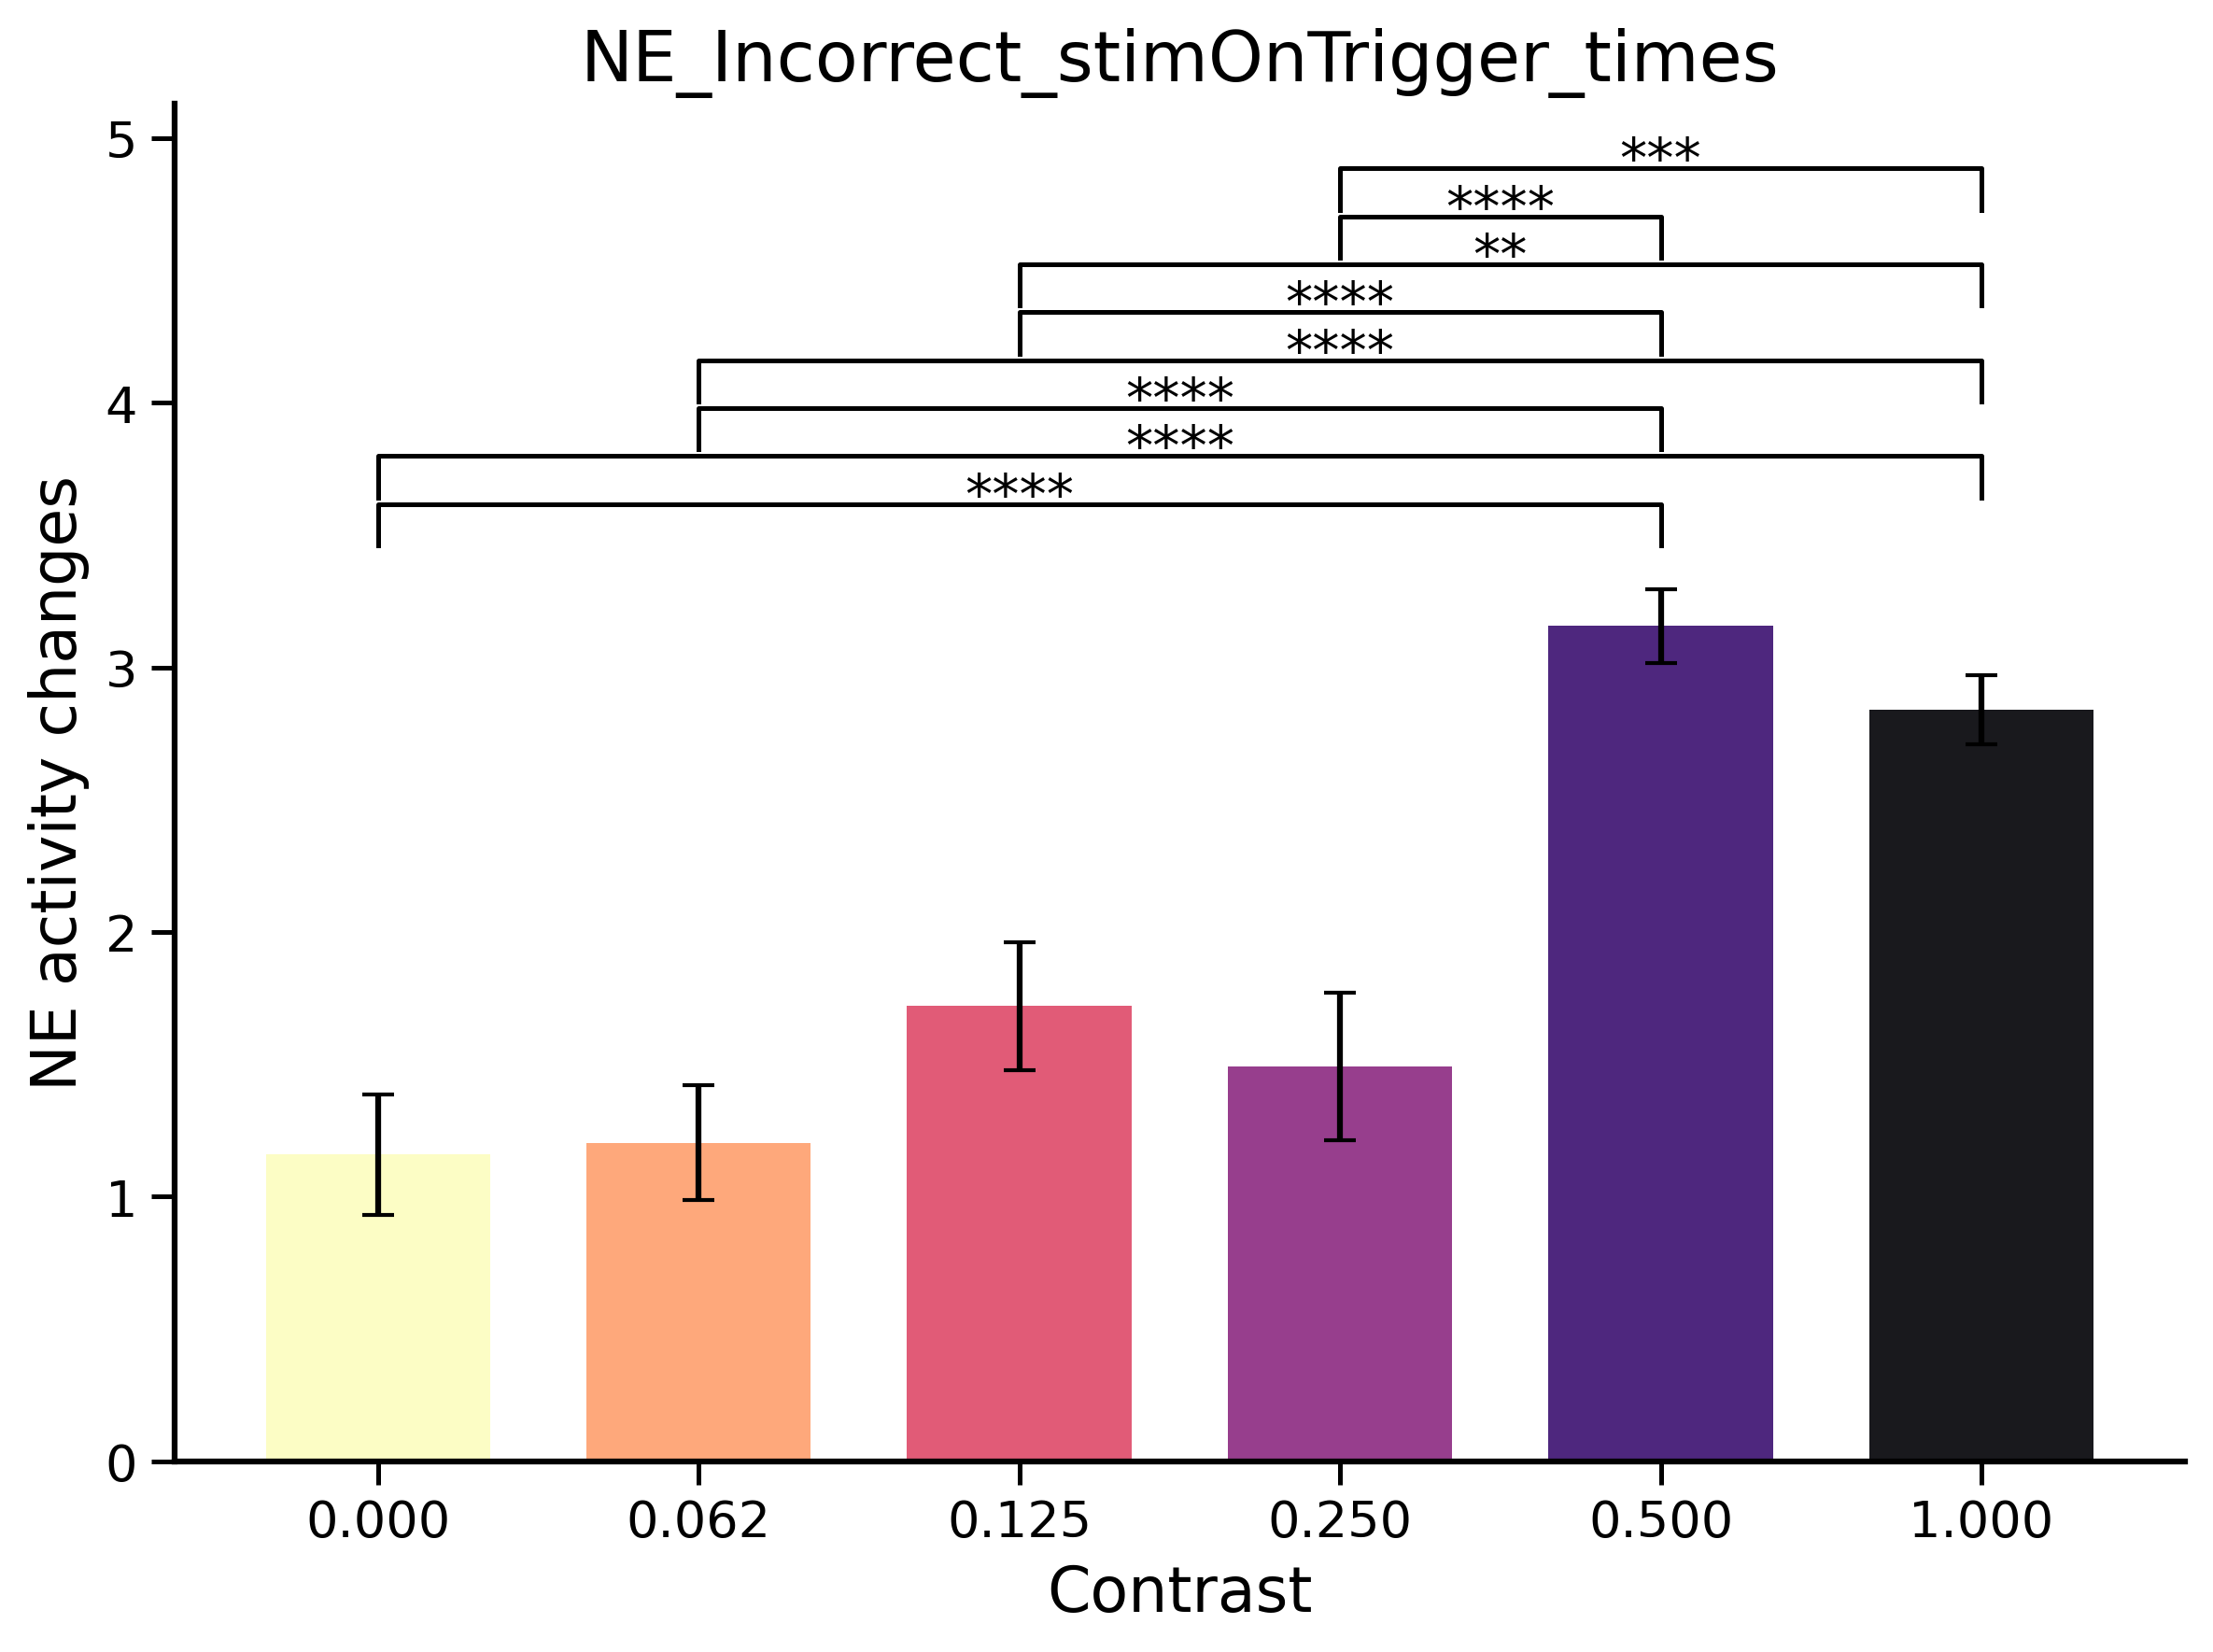

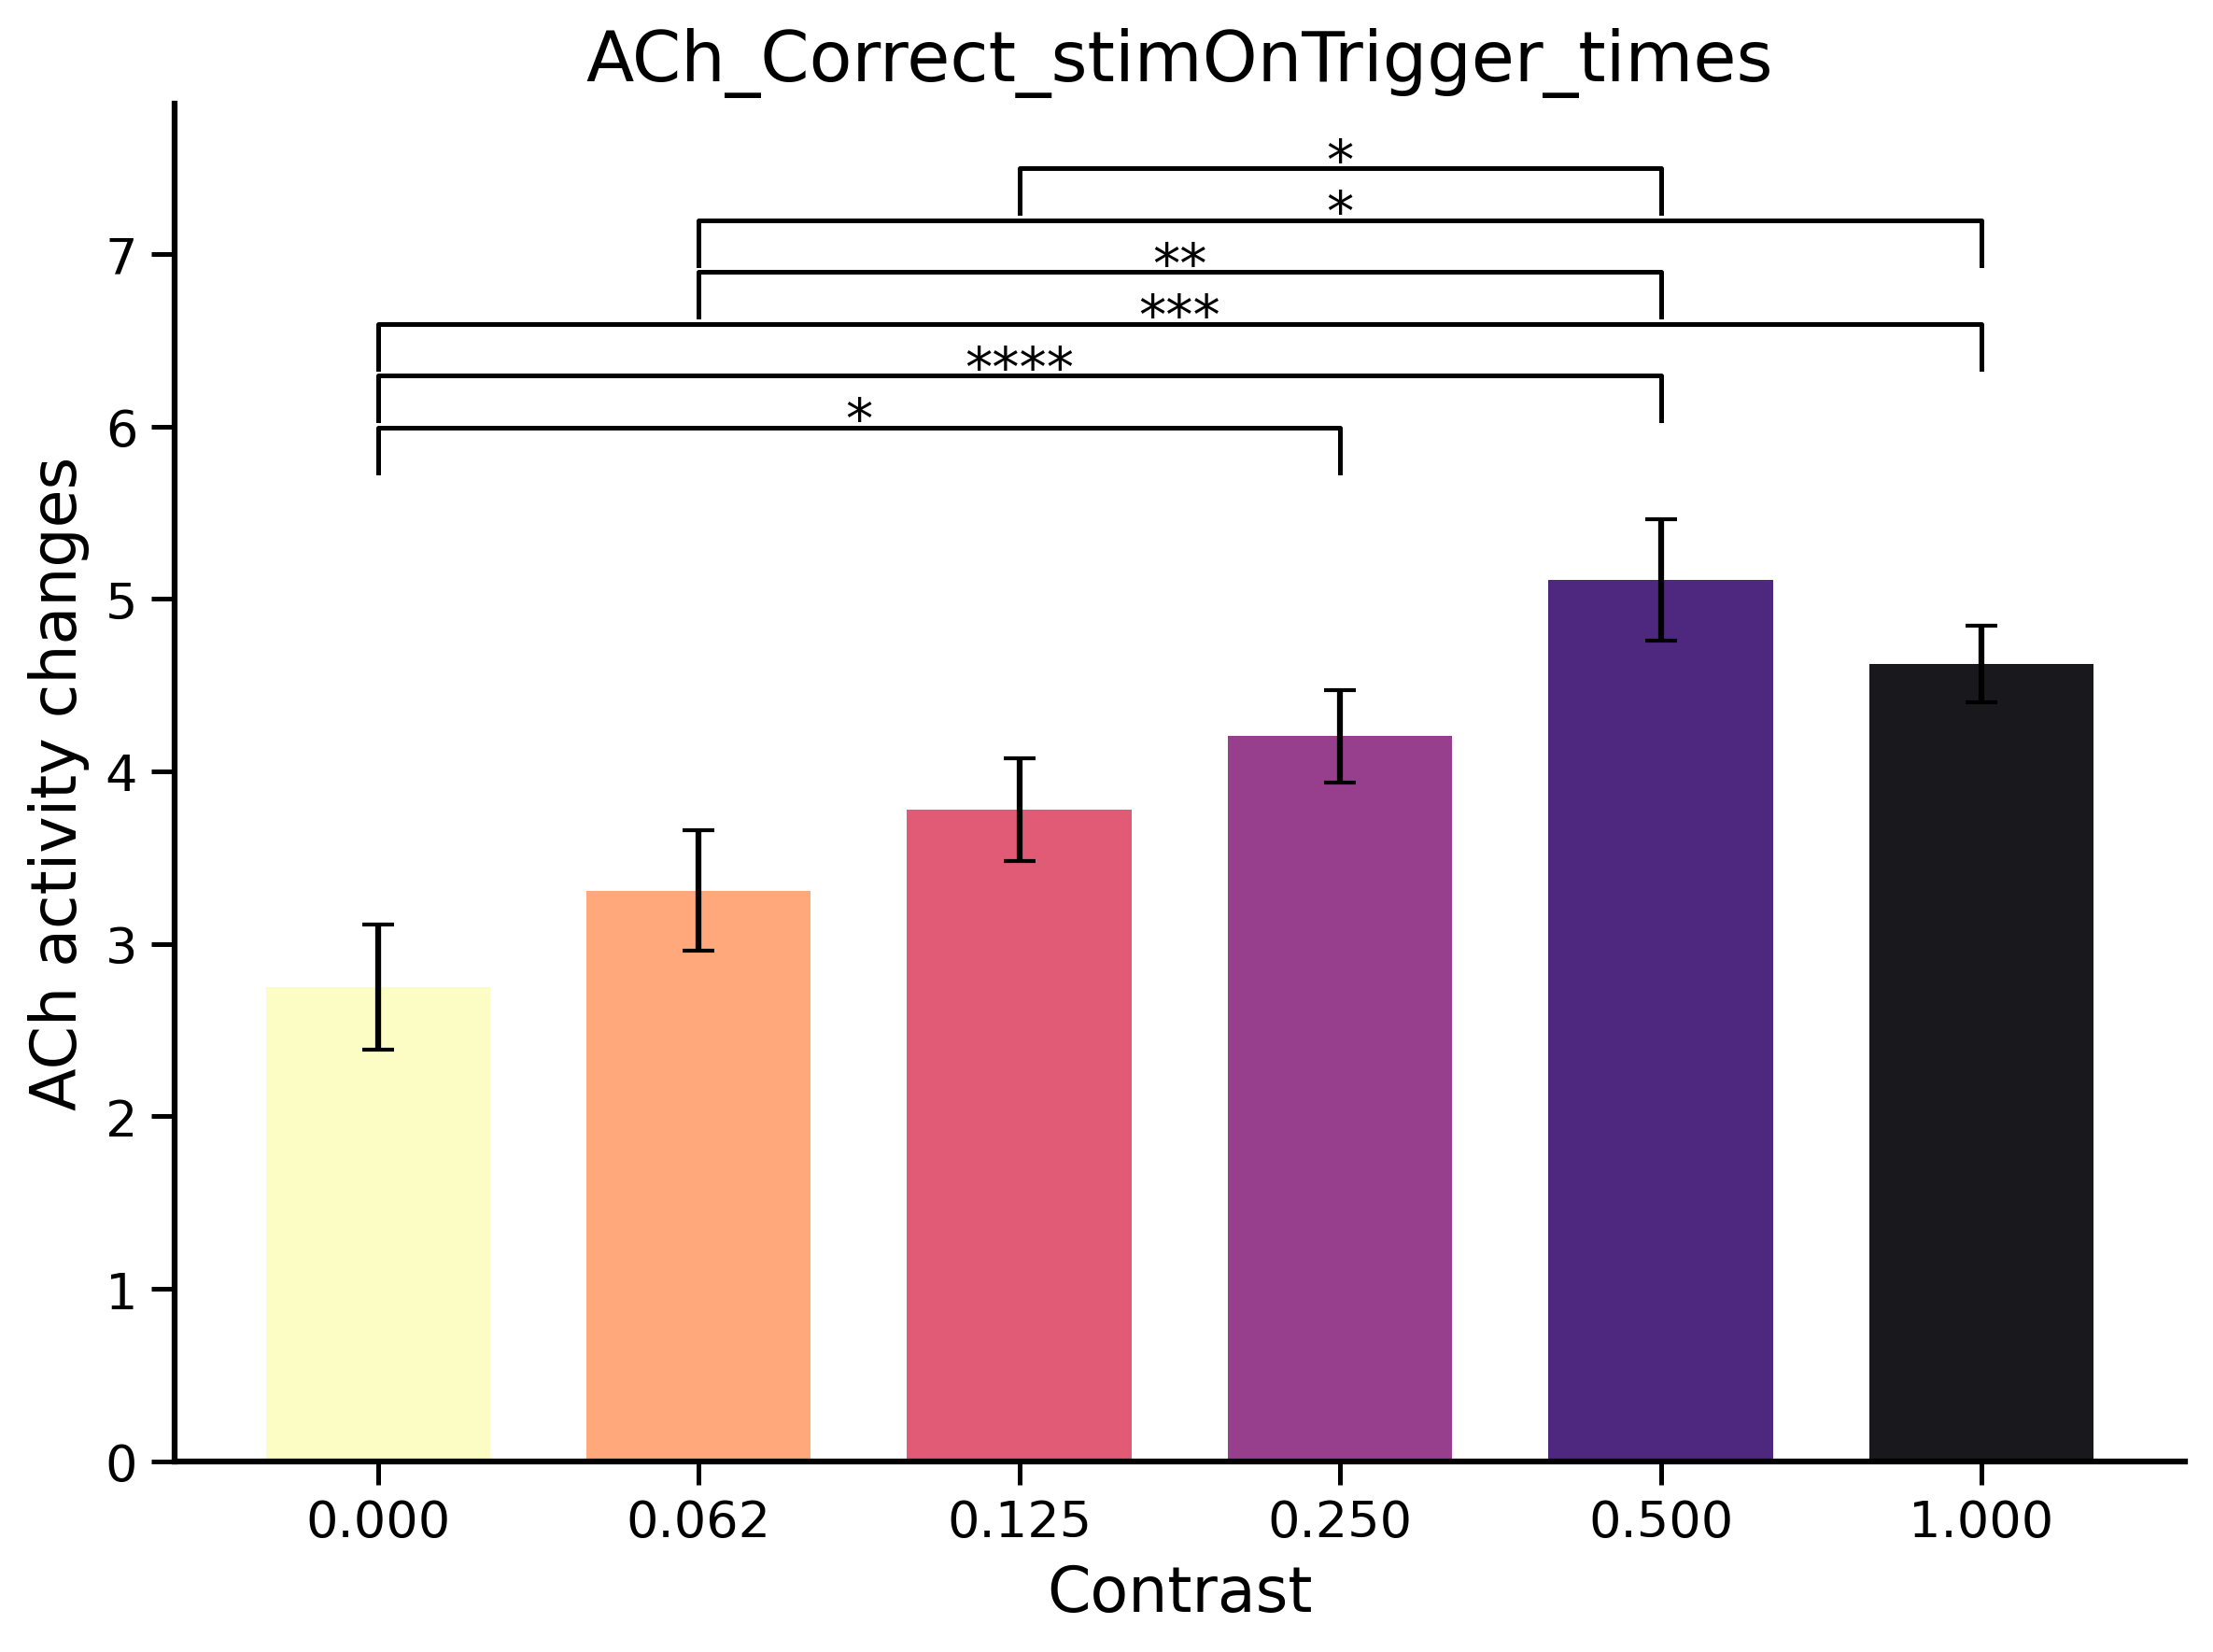

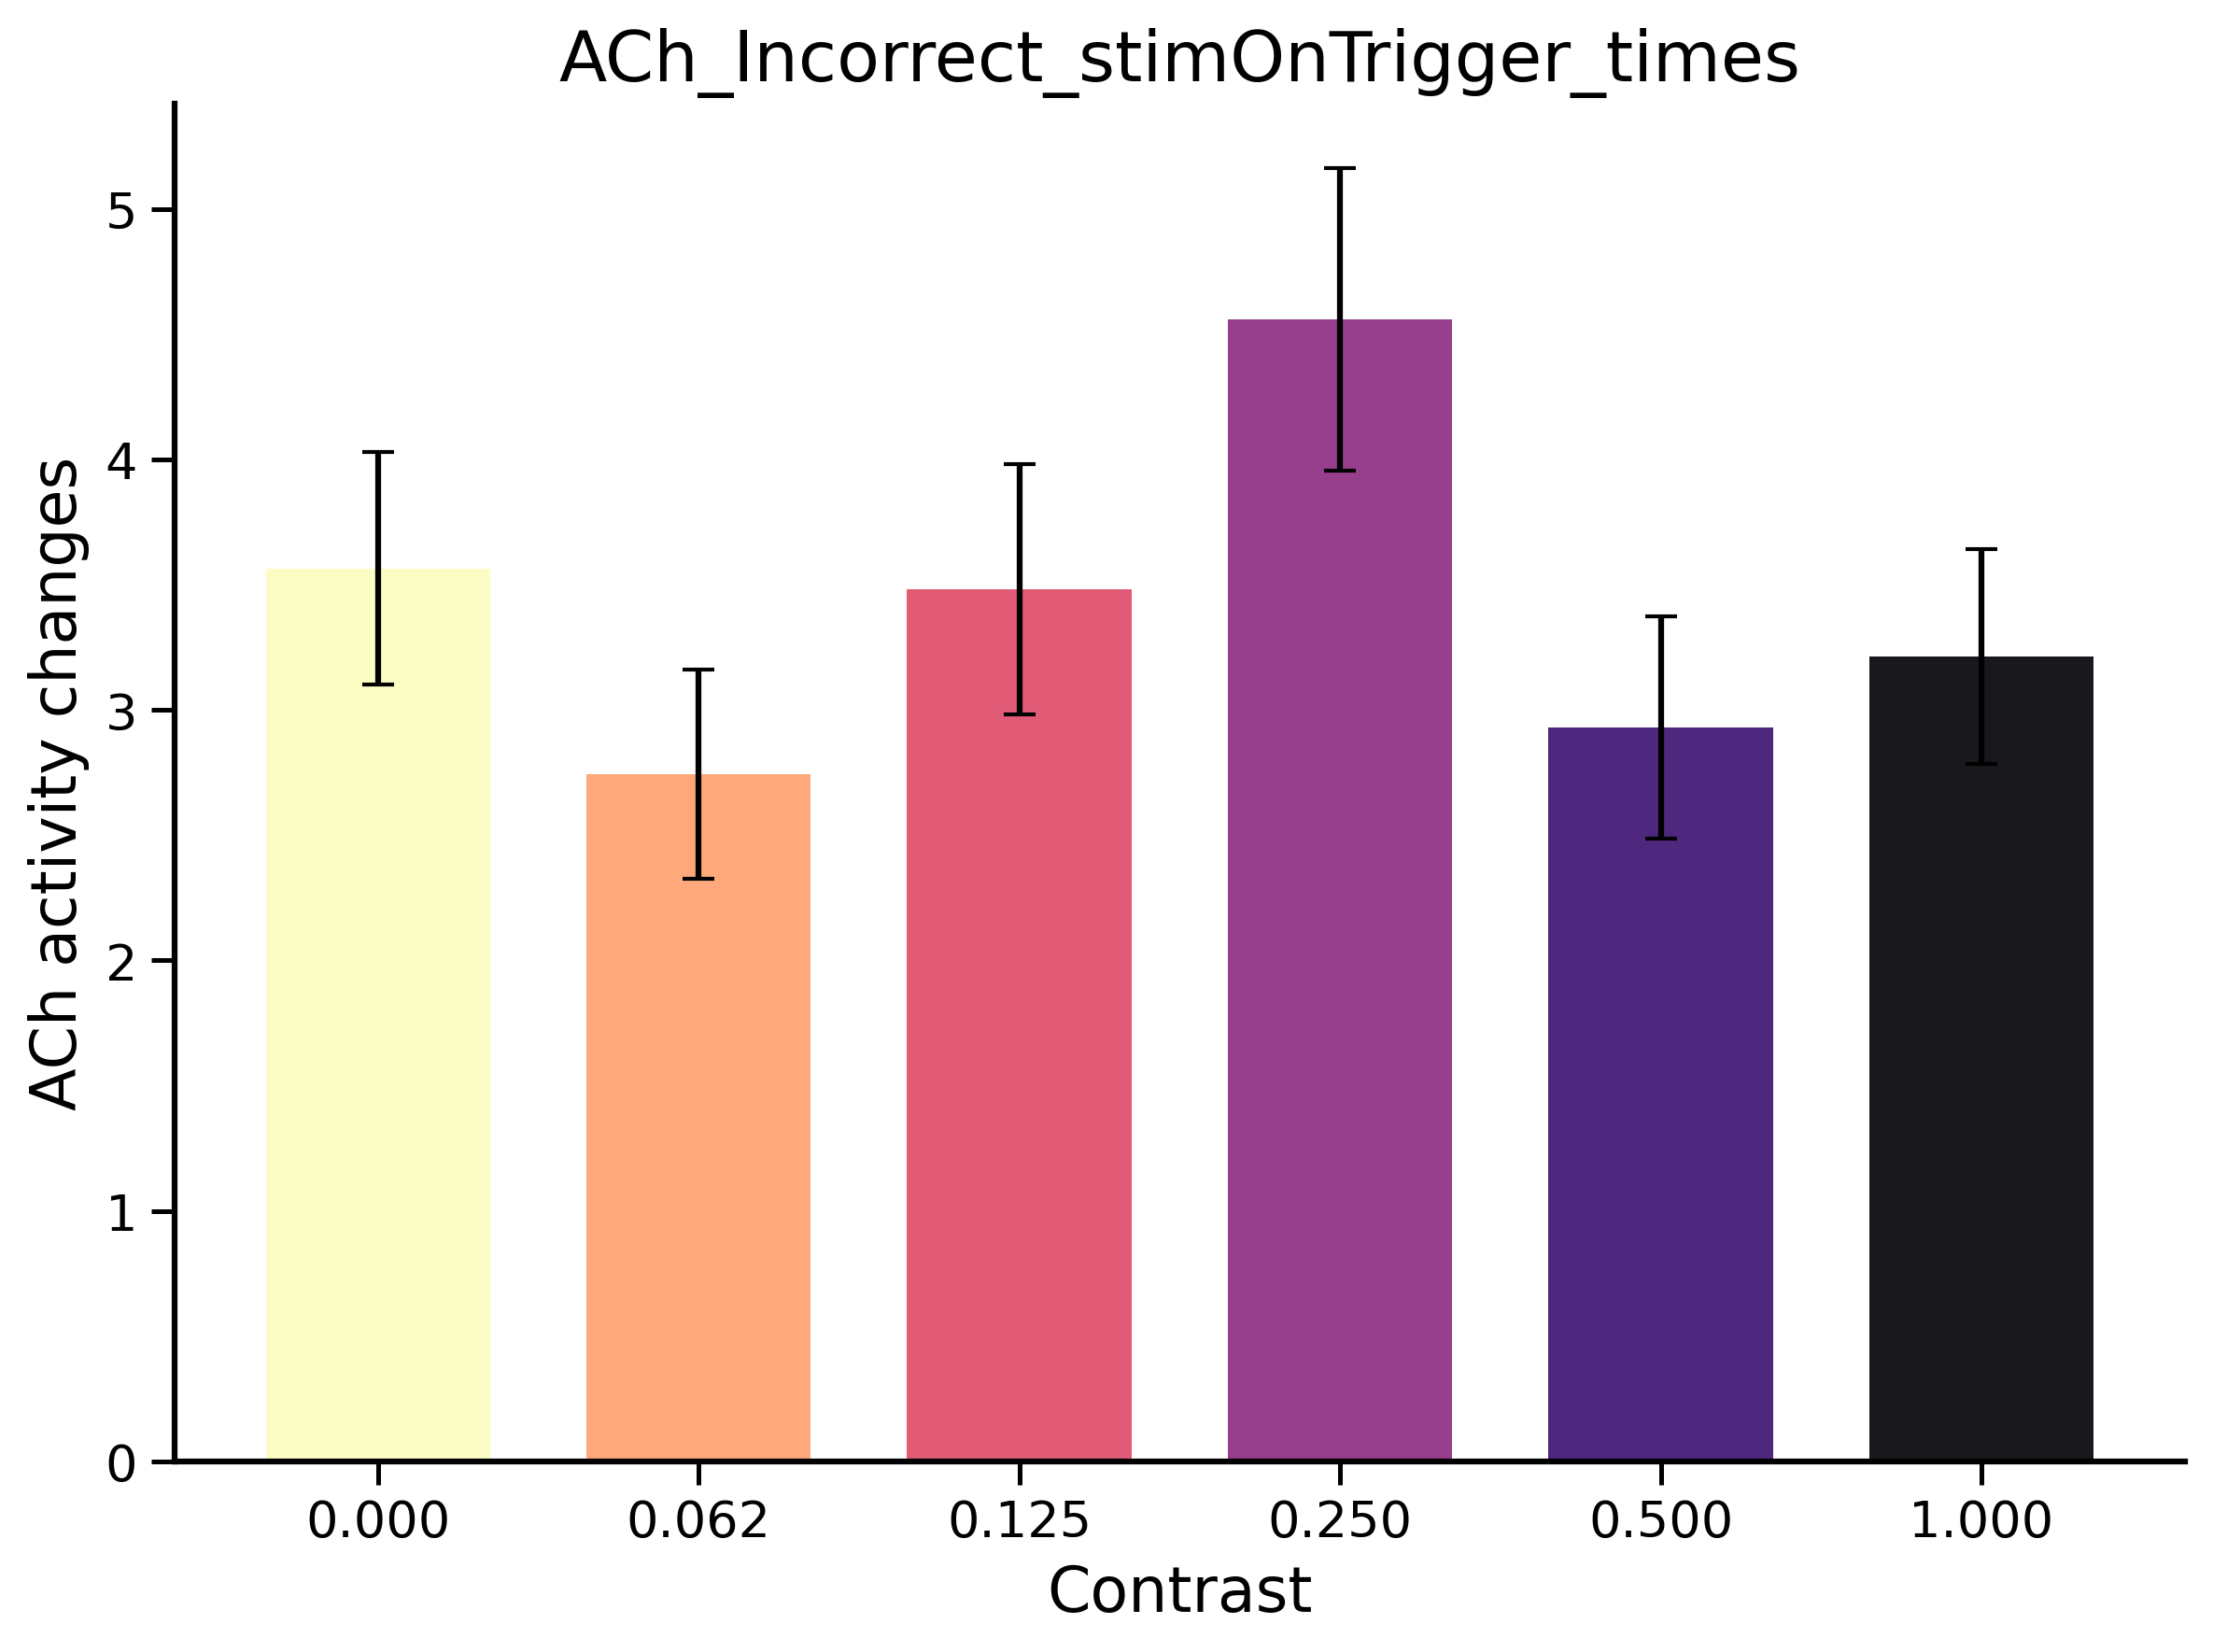

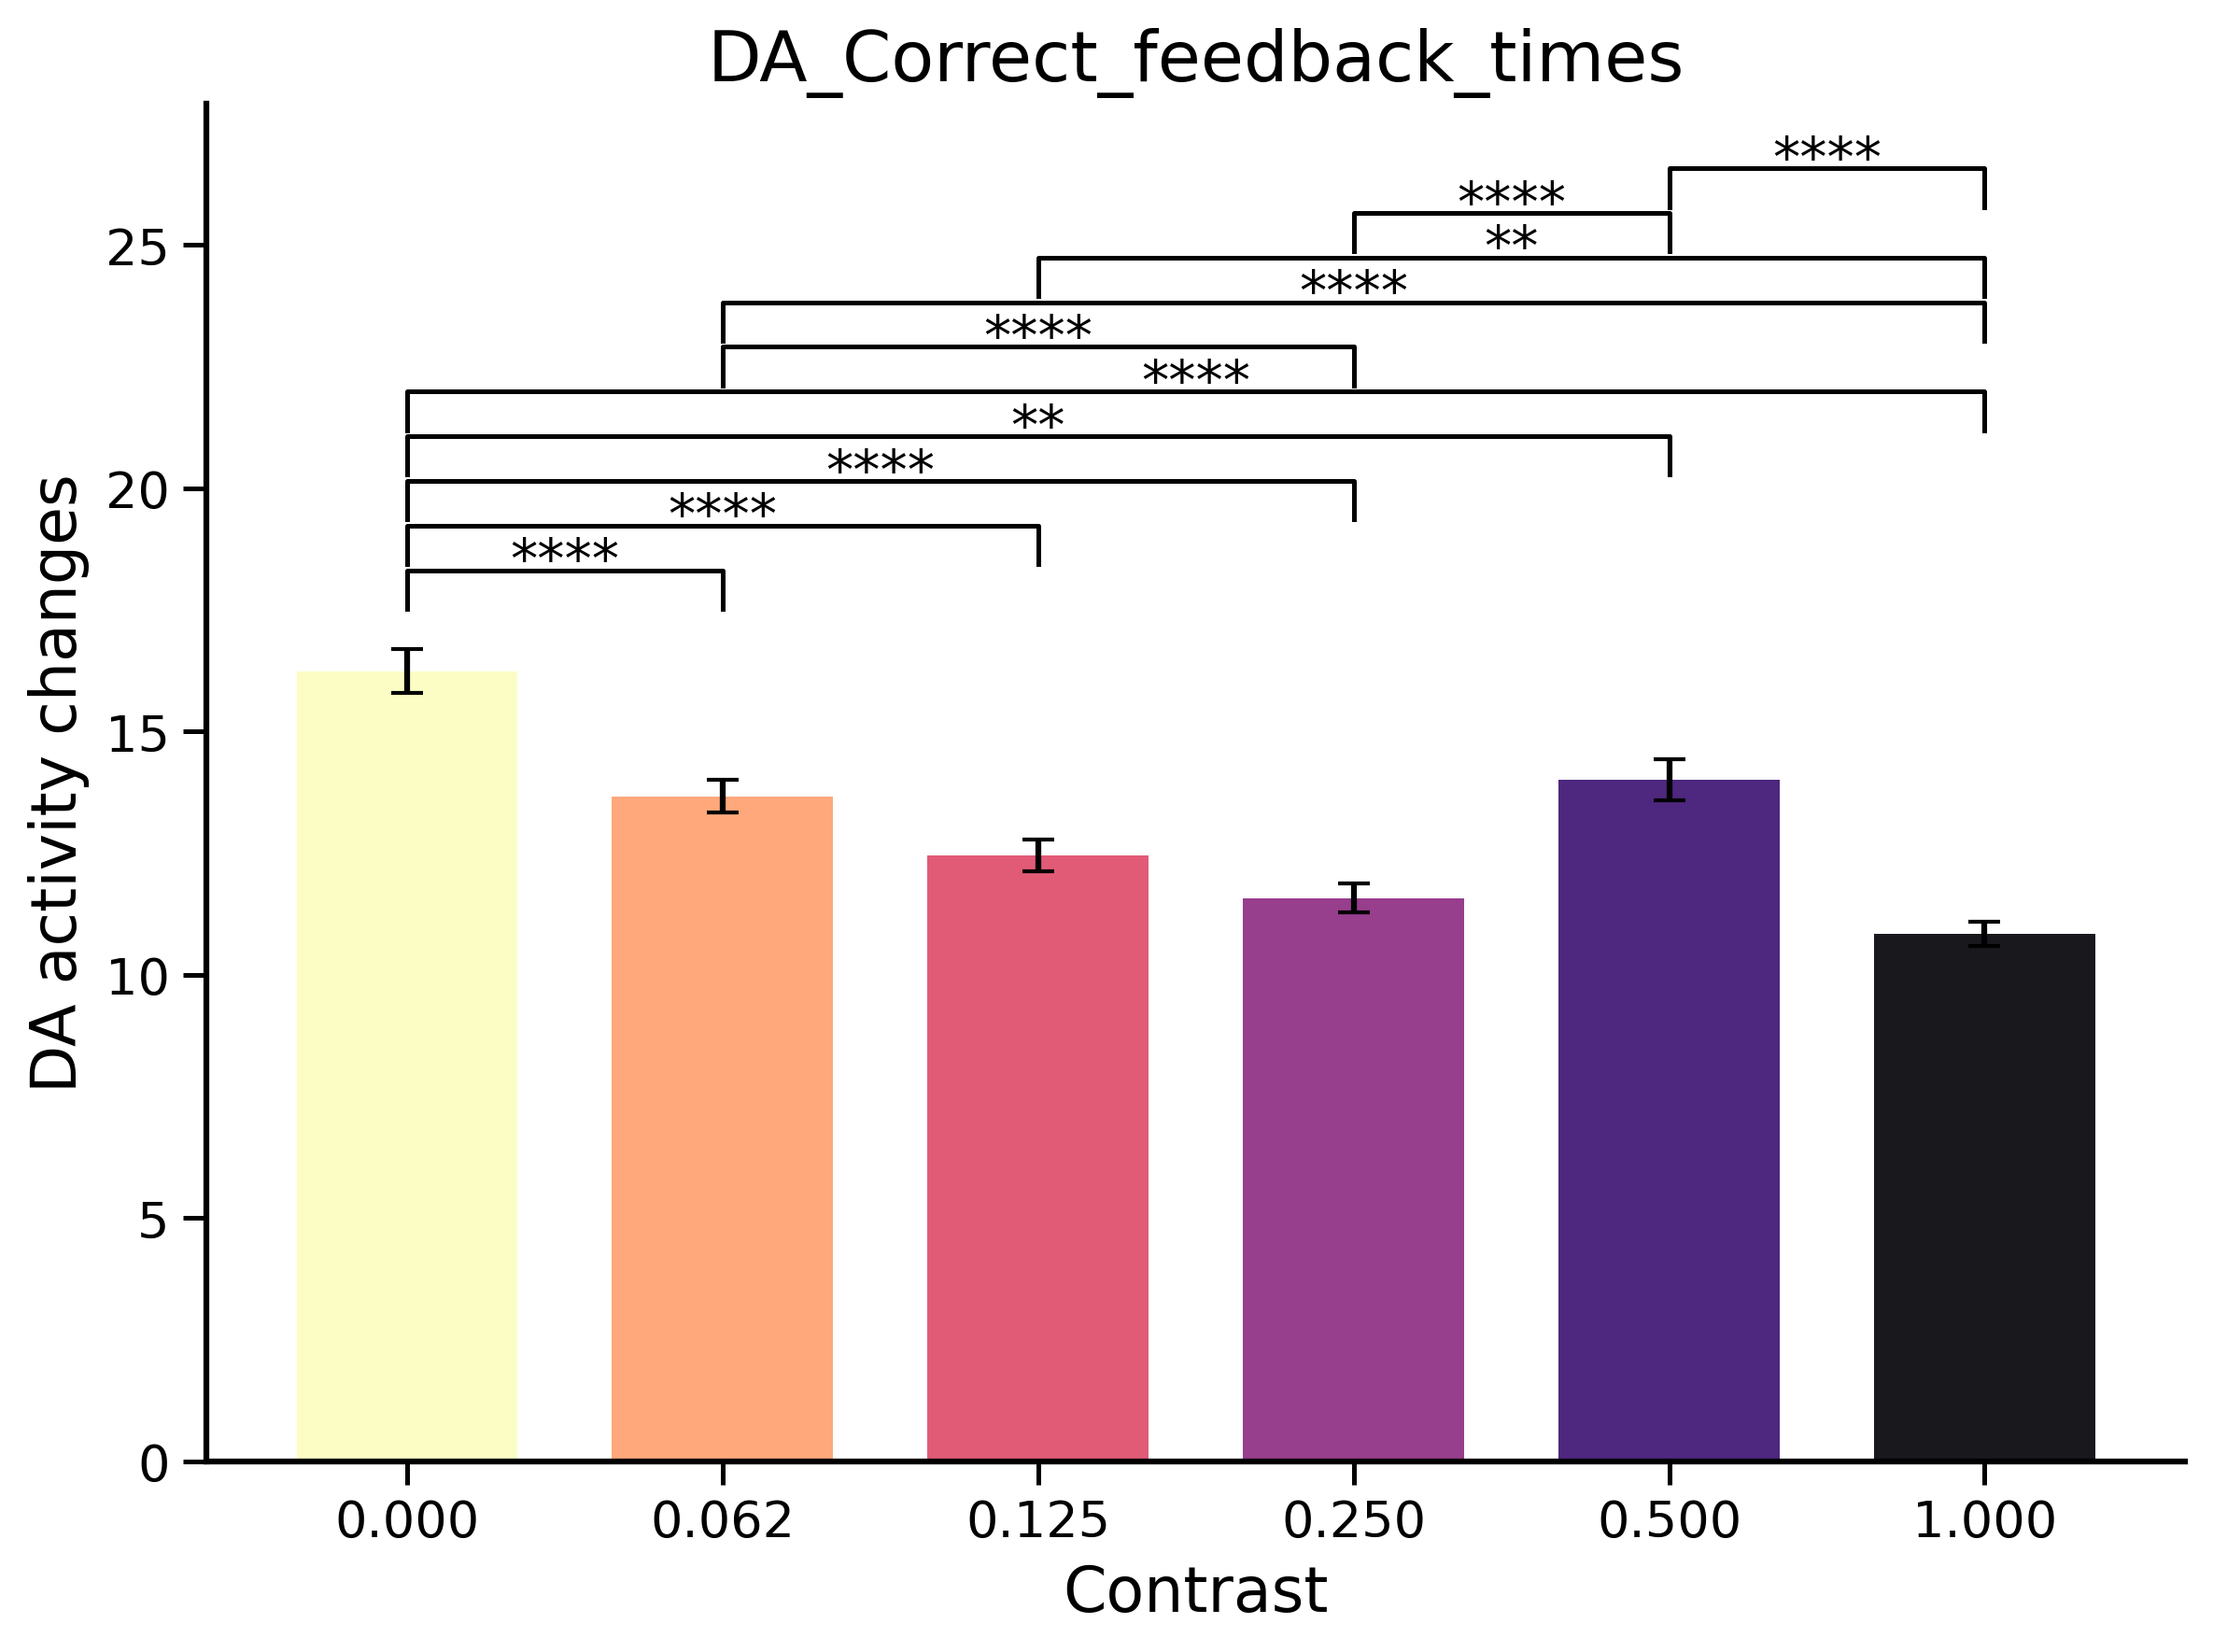

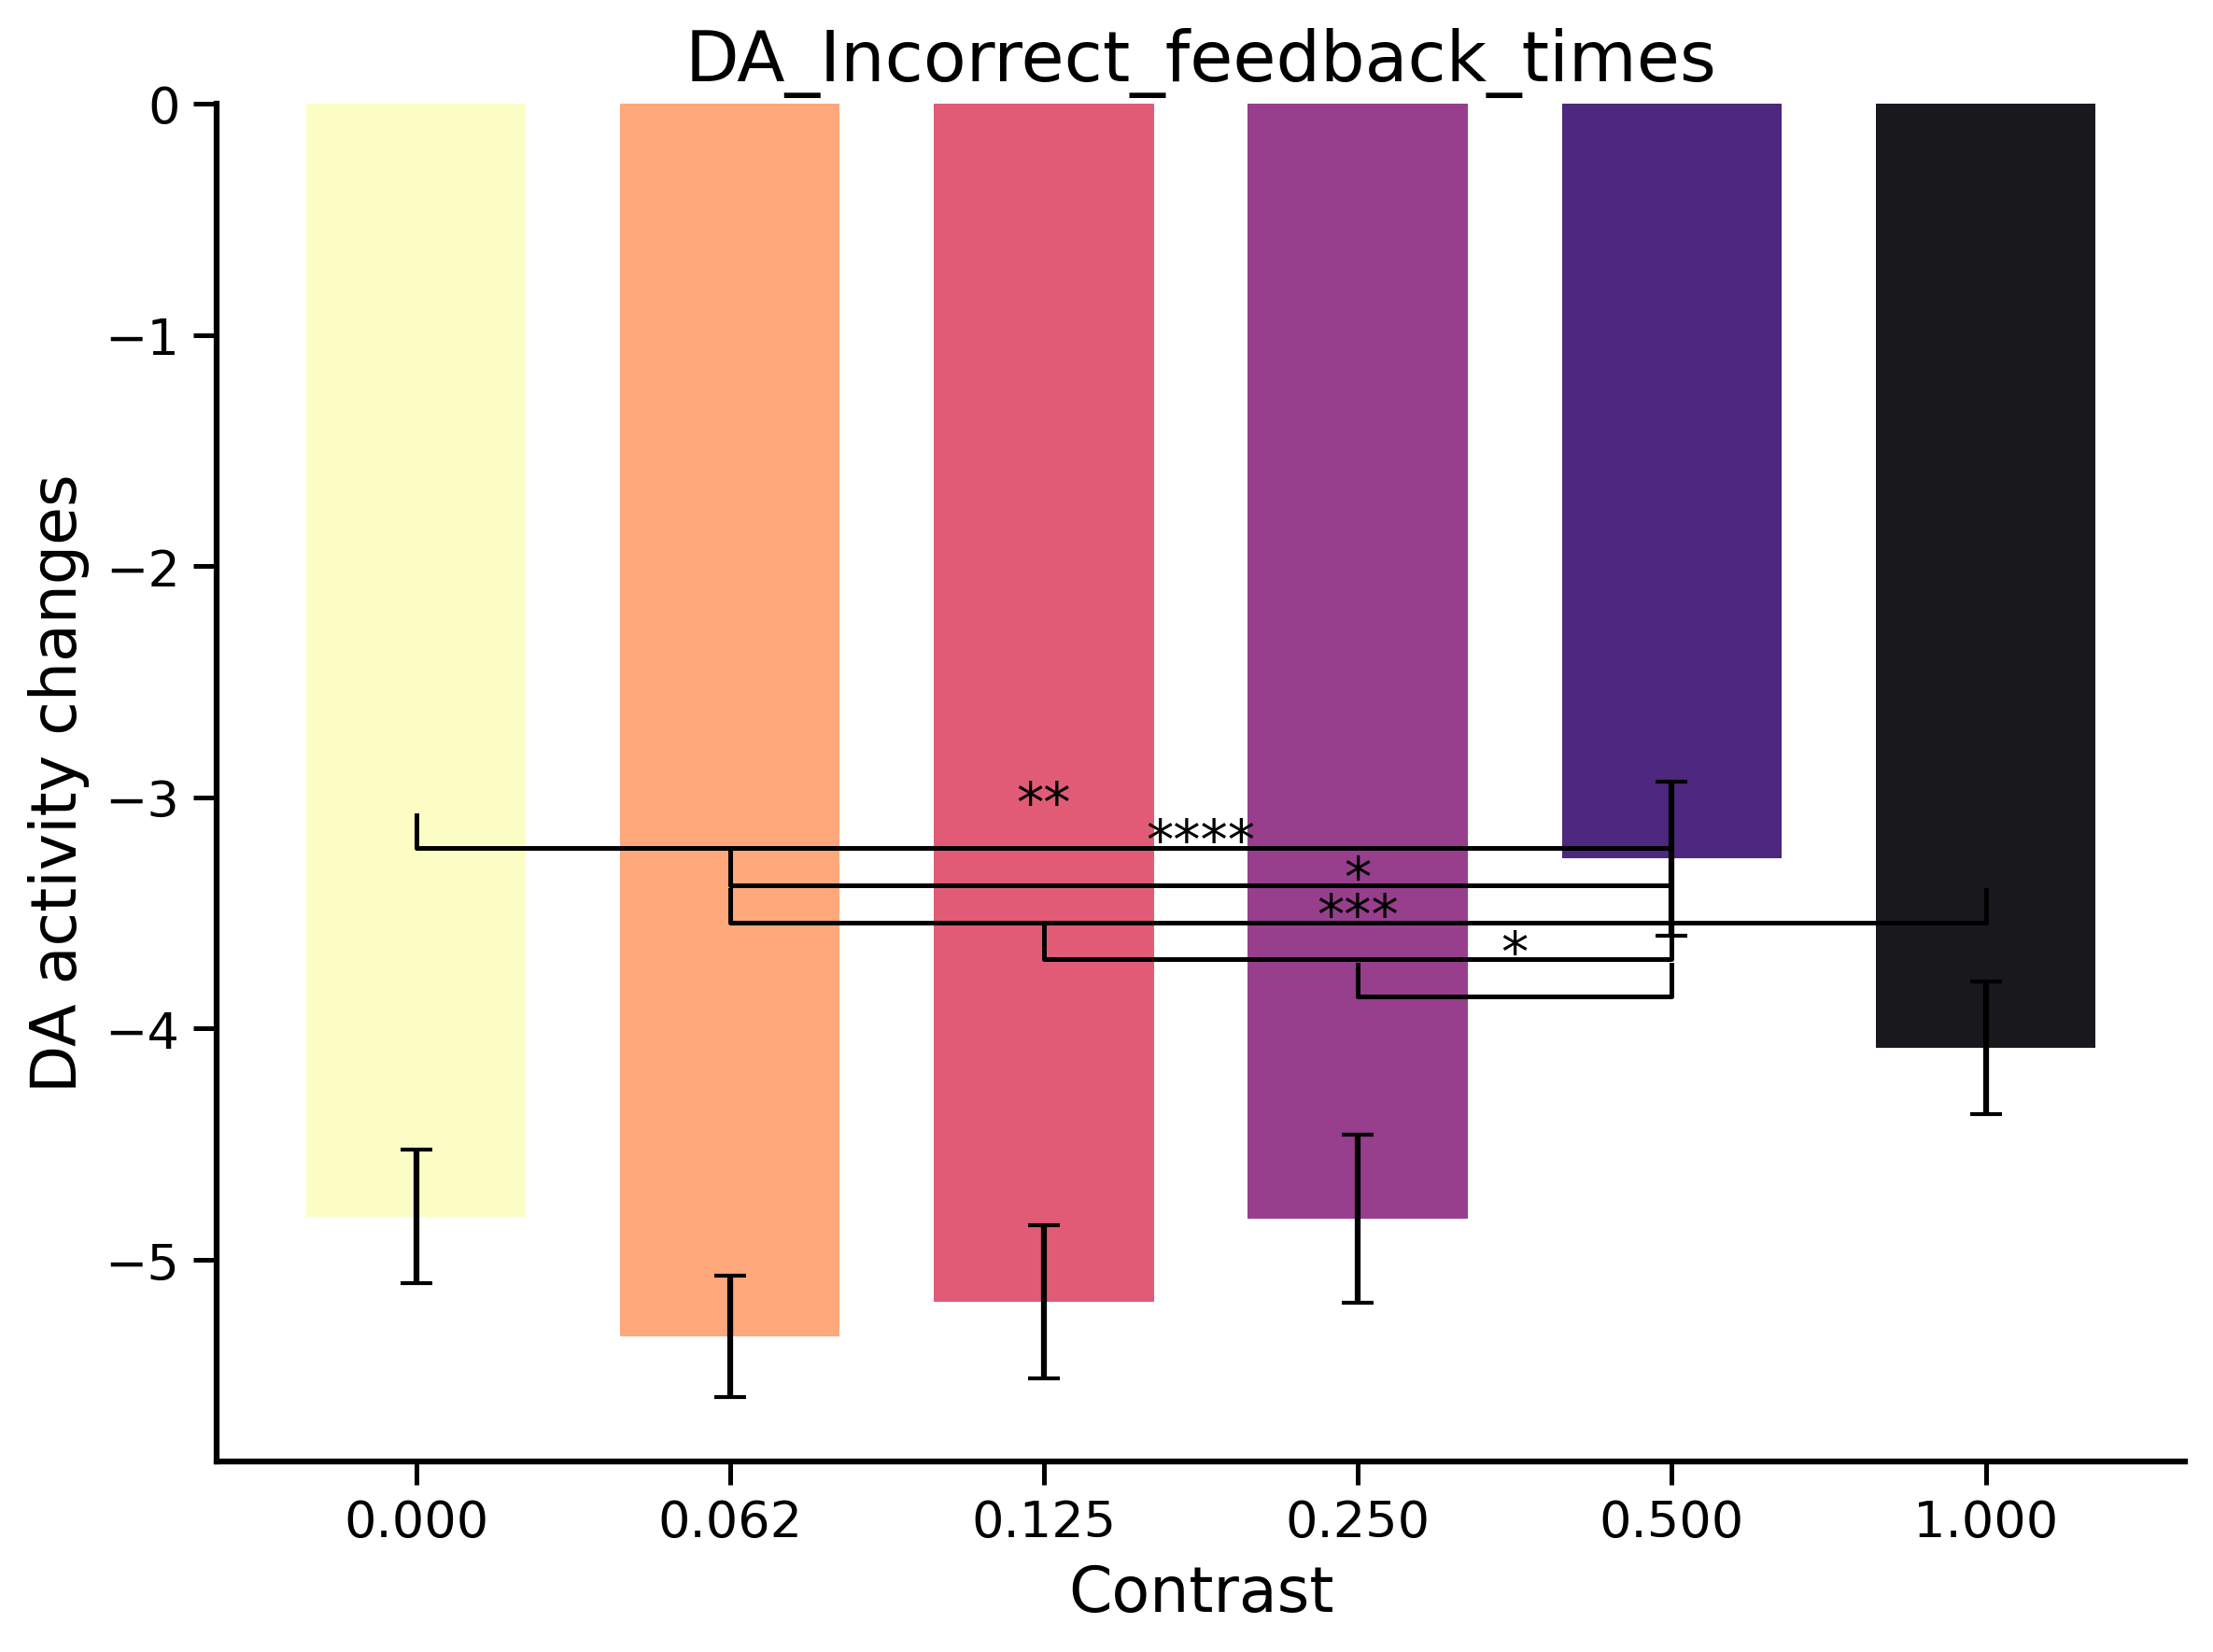

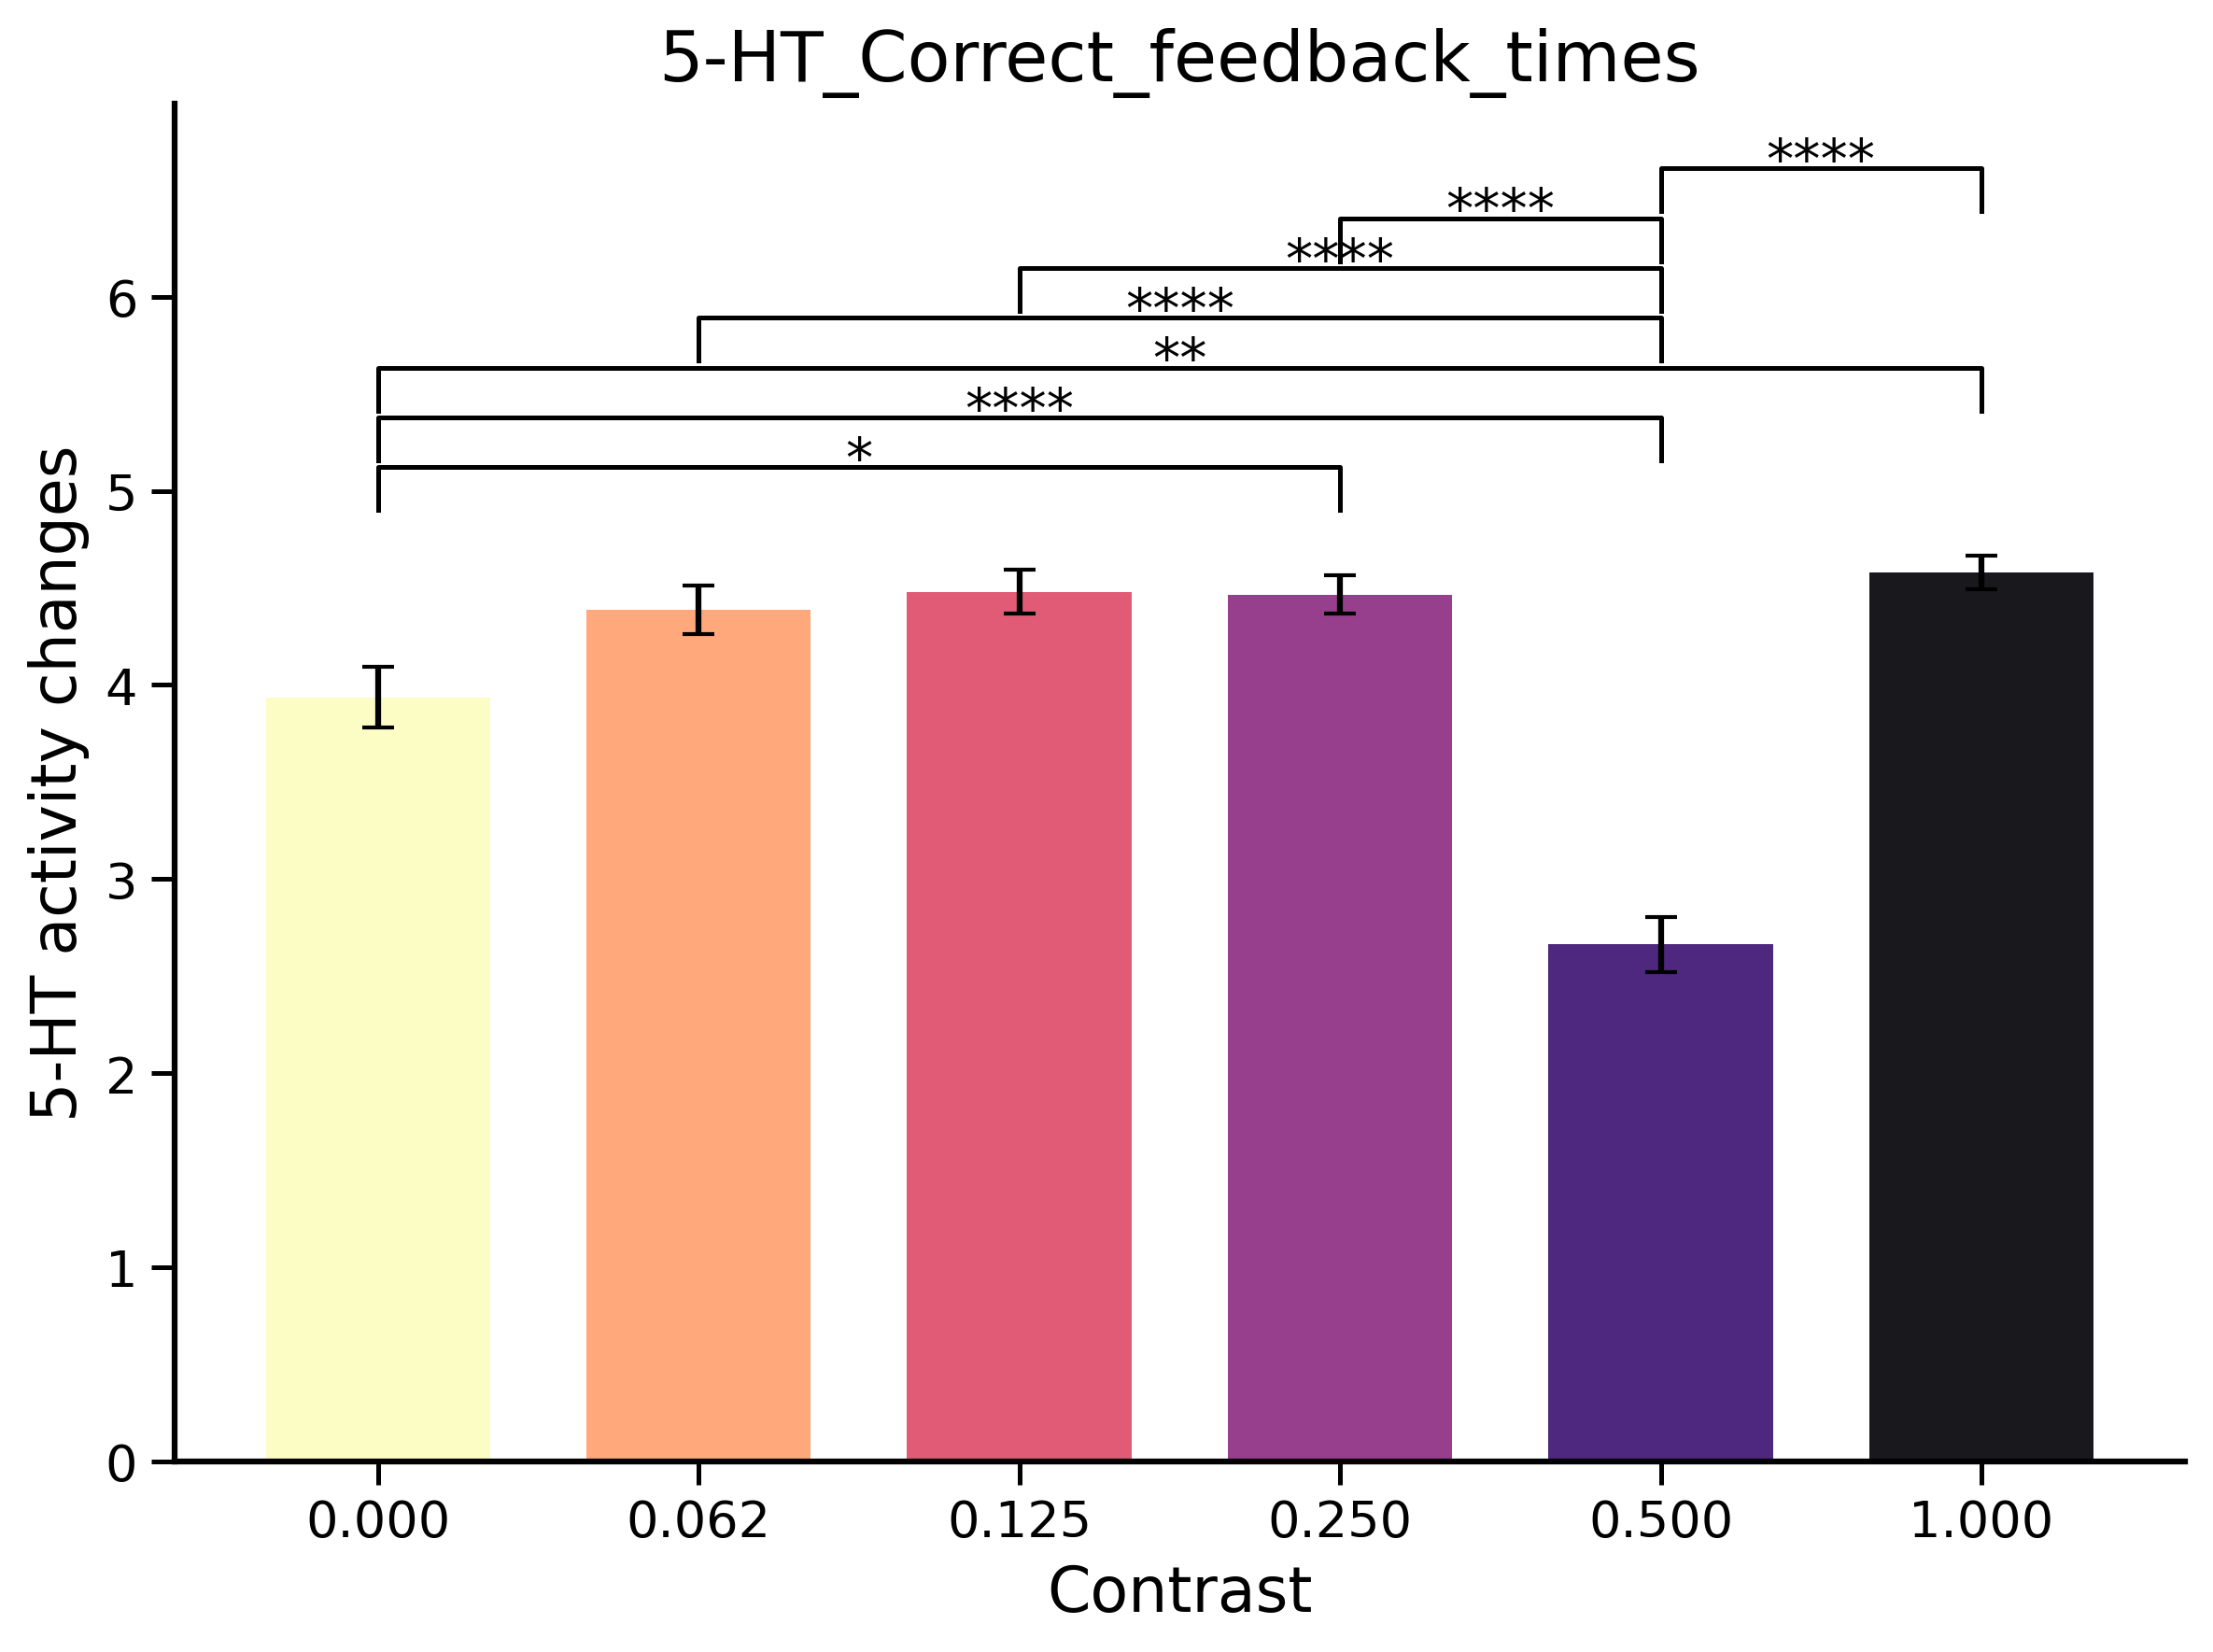

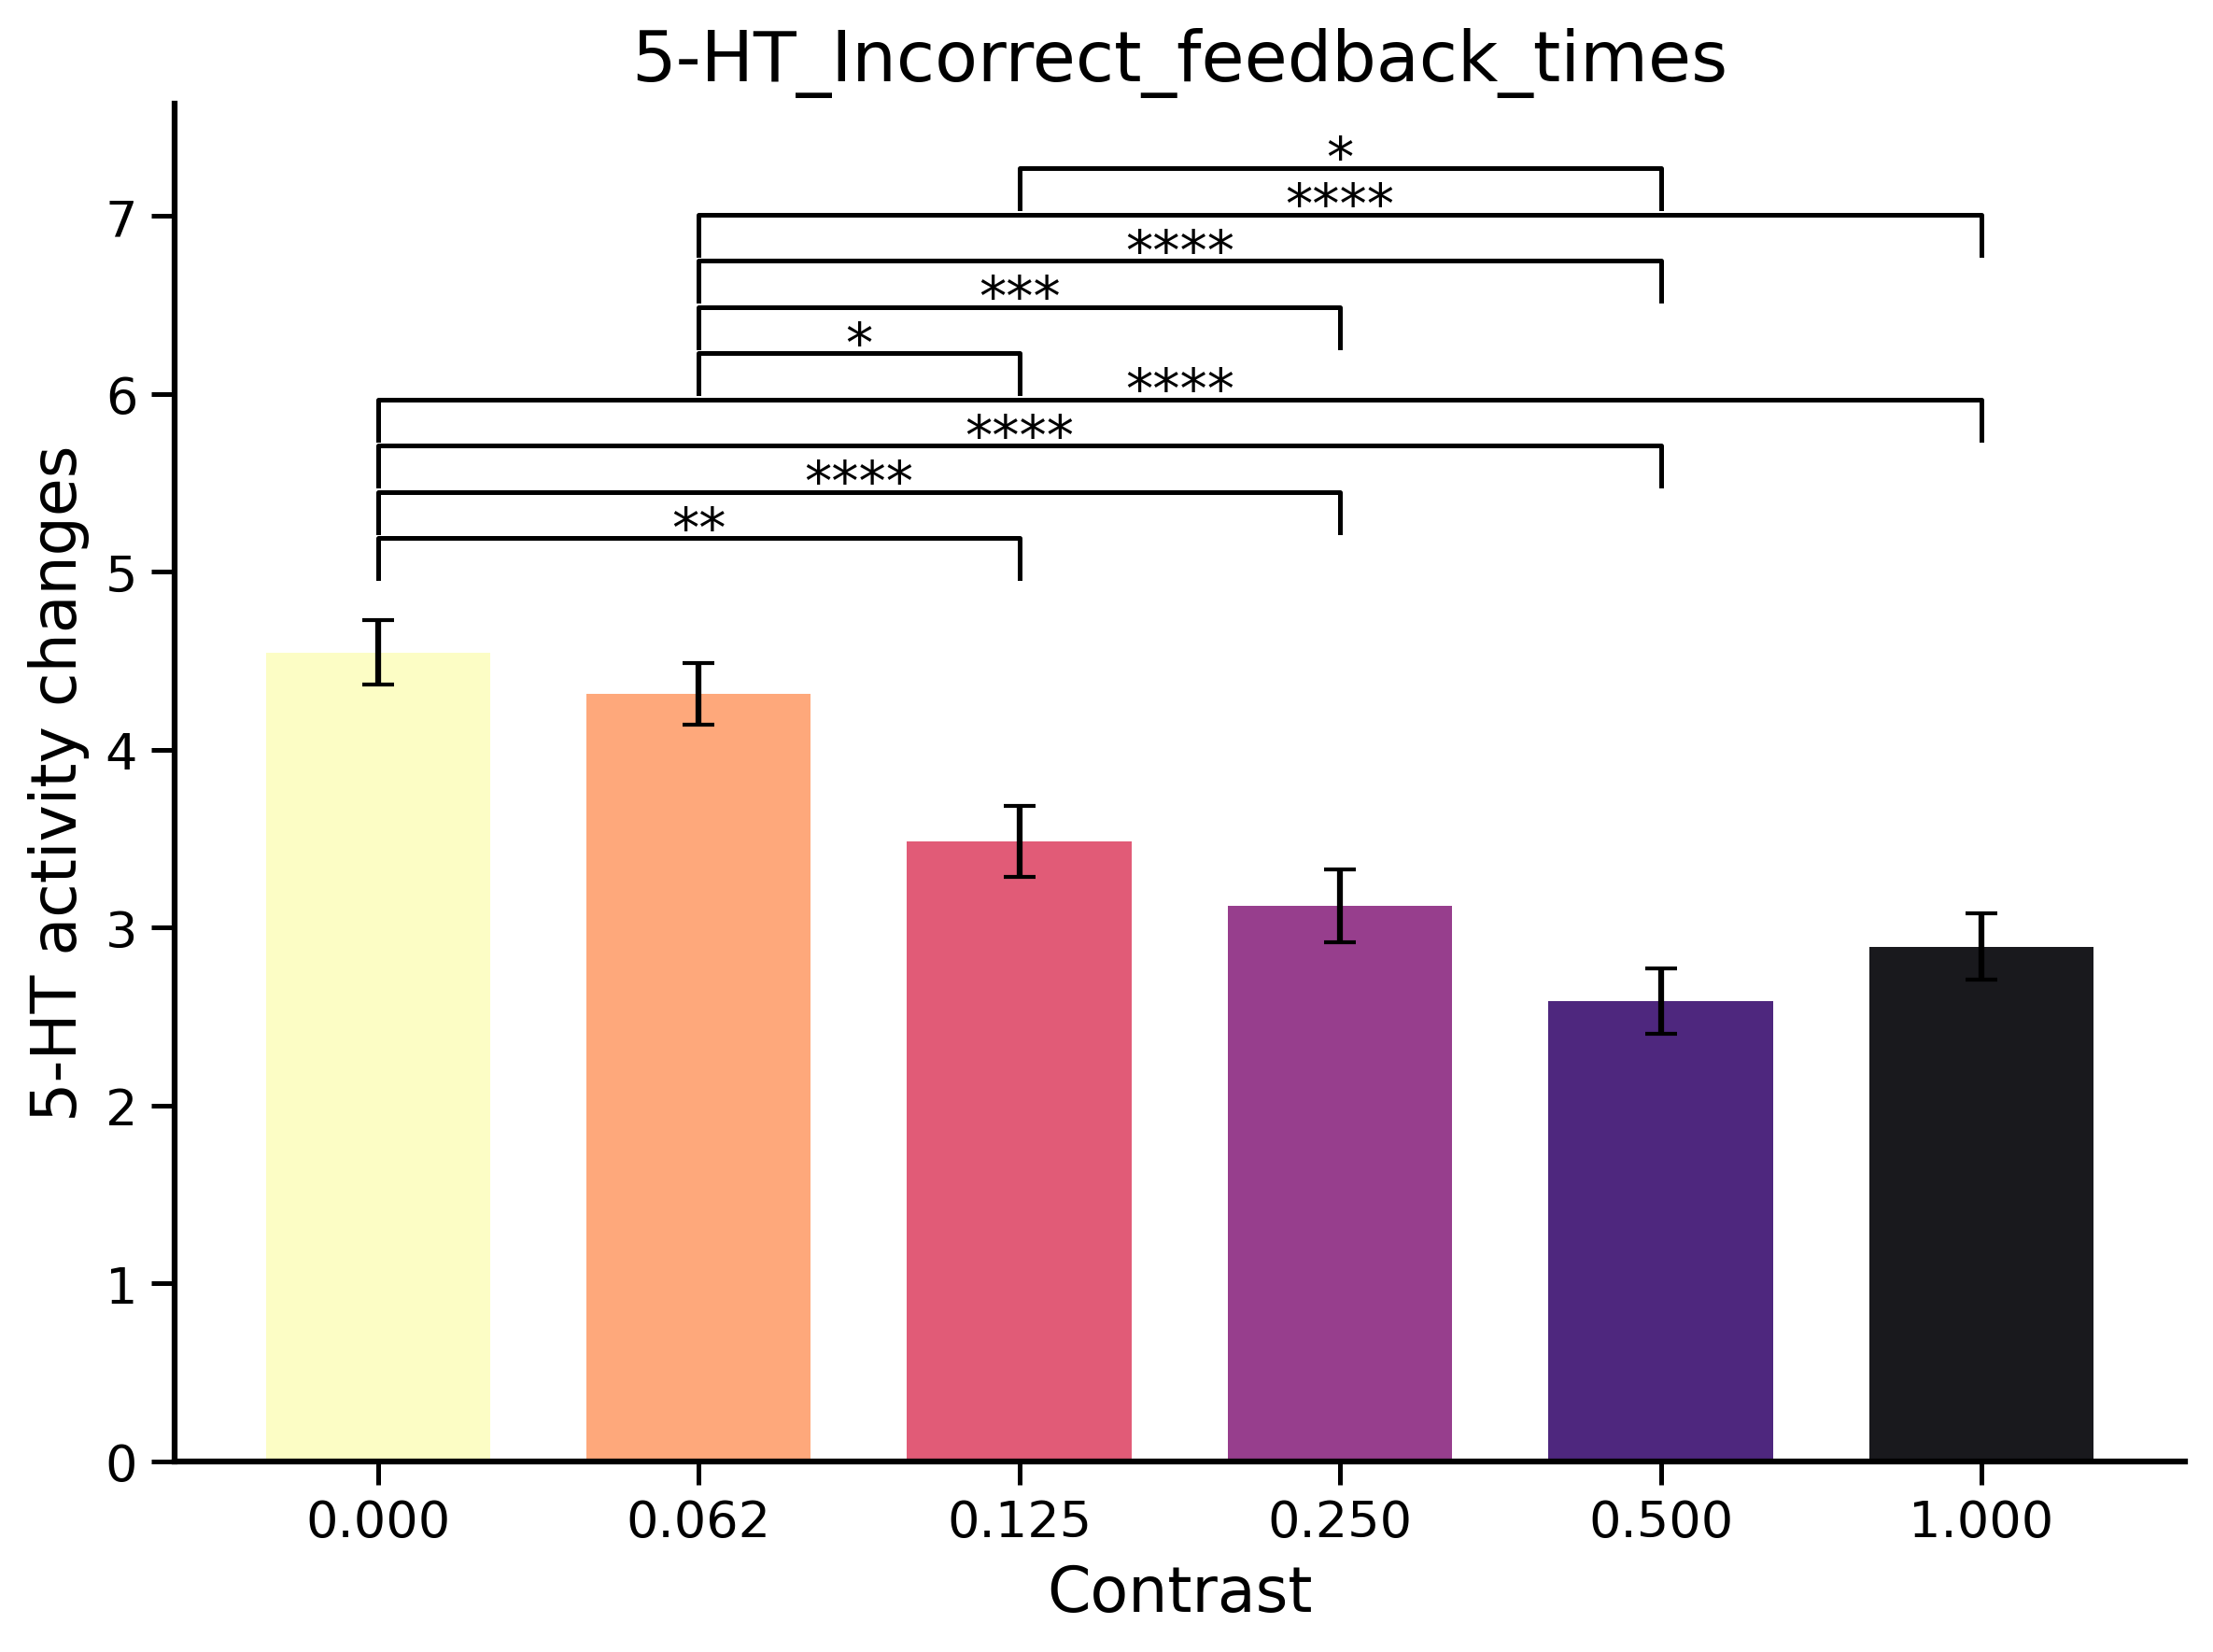

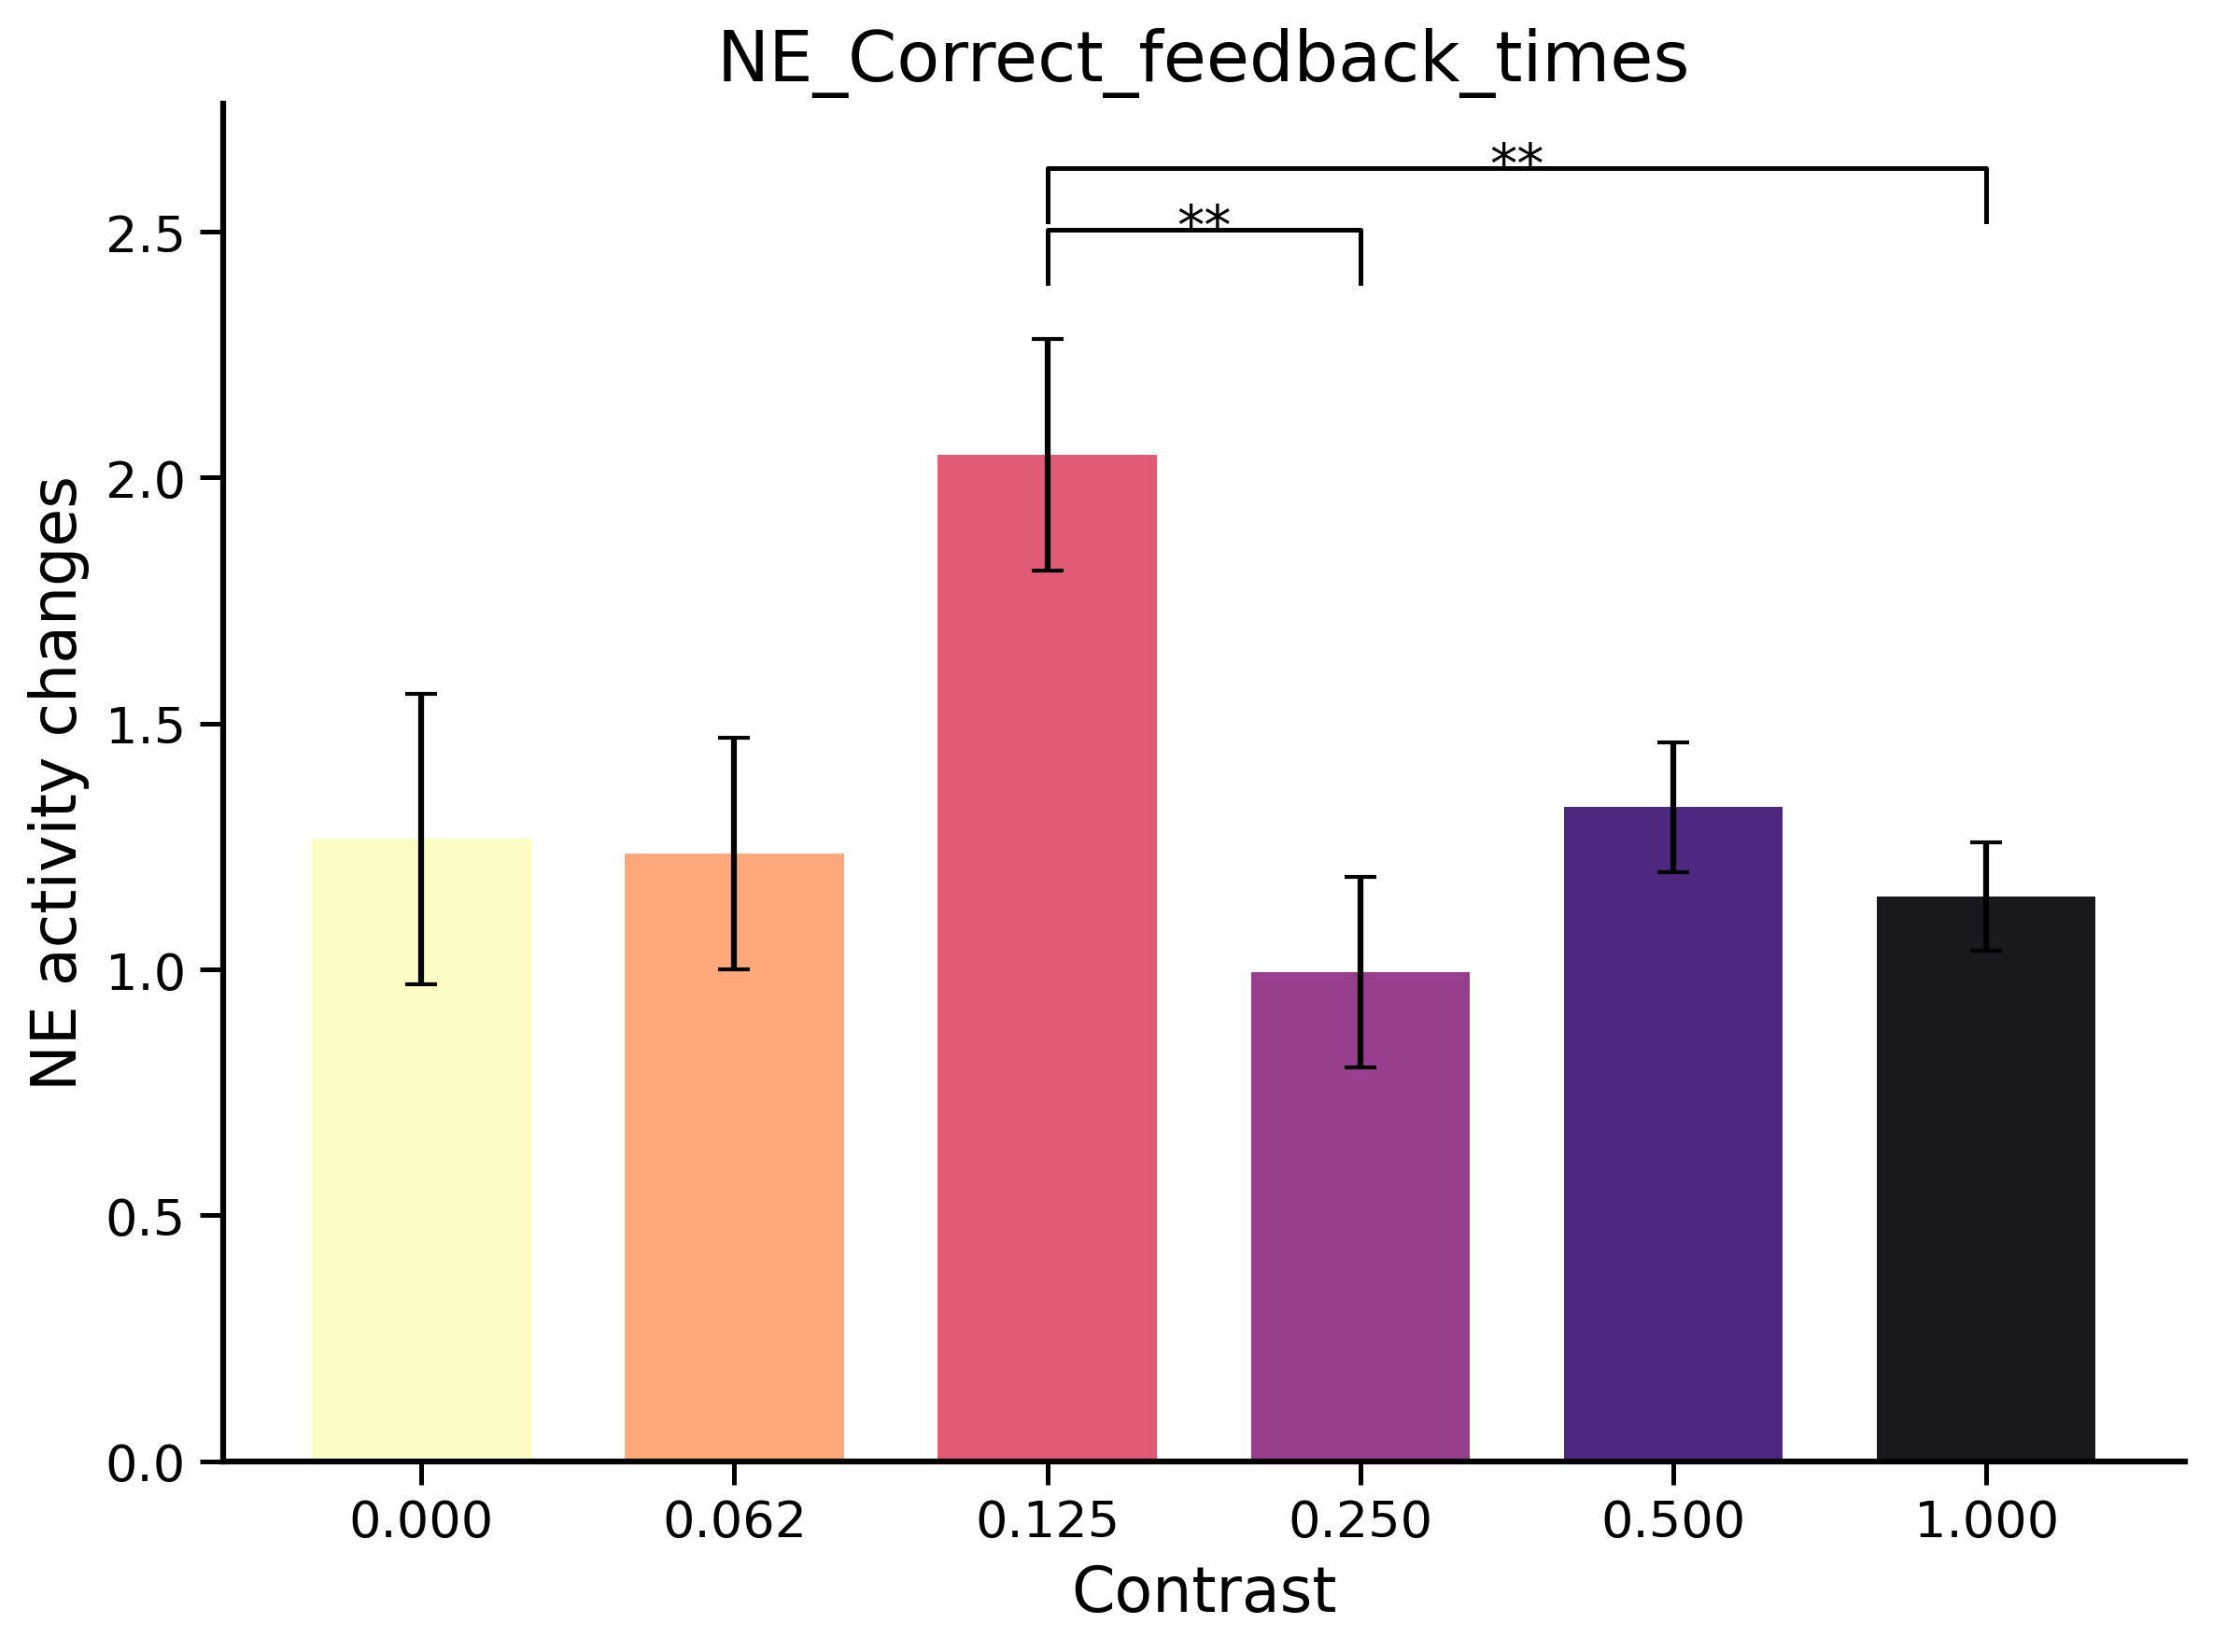

/home/kceniabougrova/.local/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


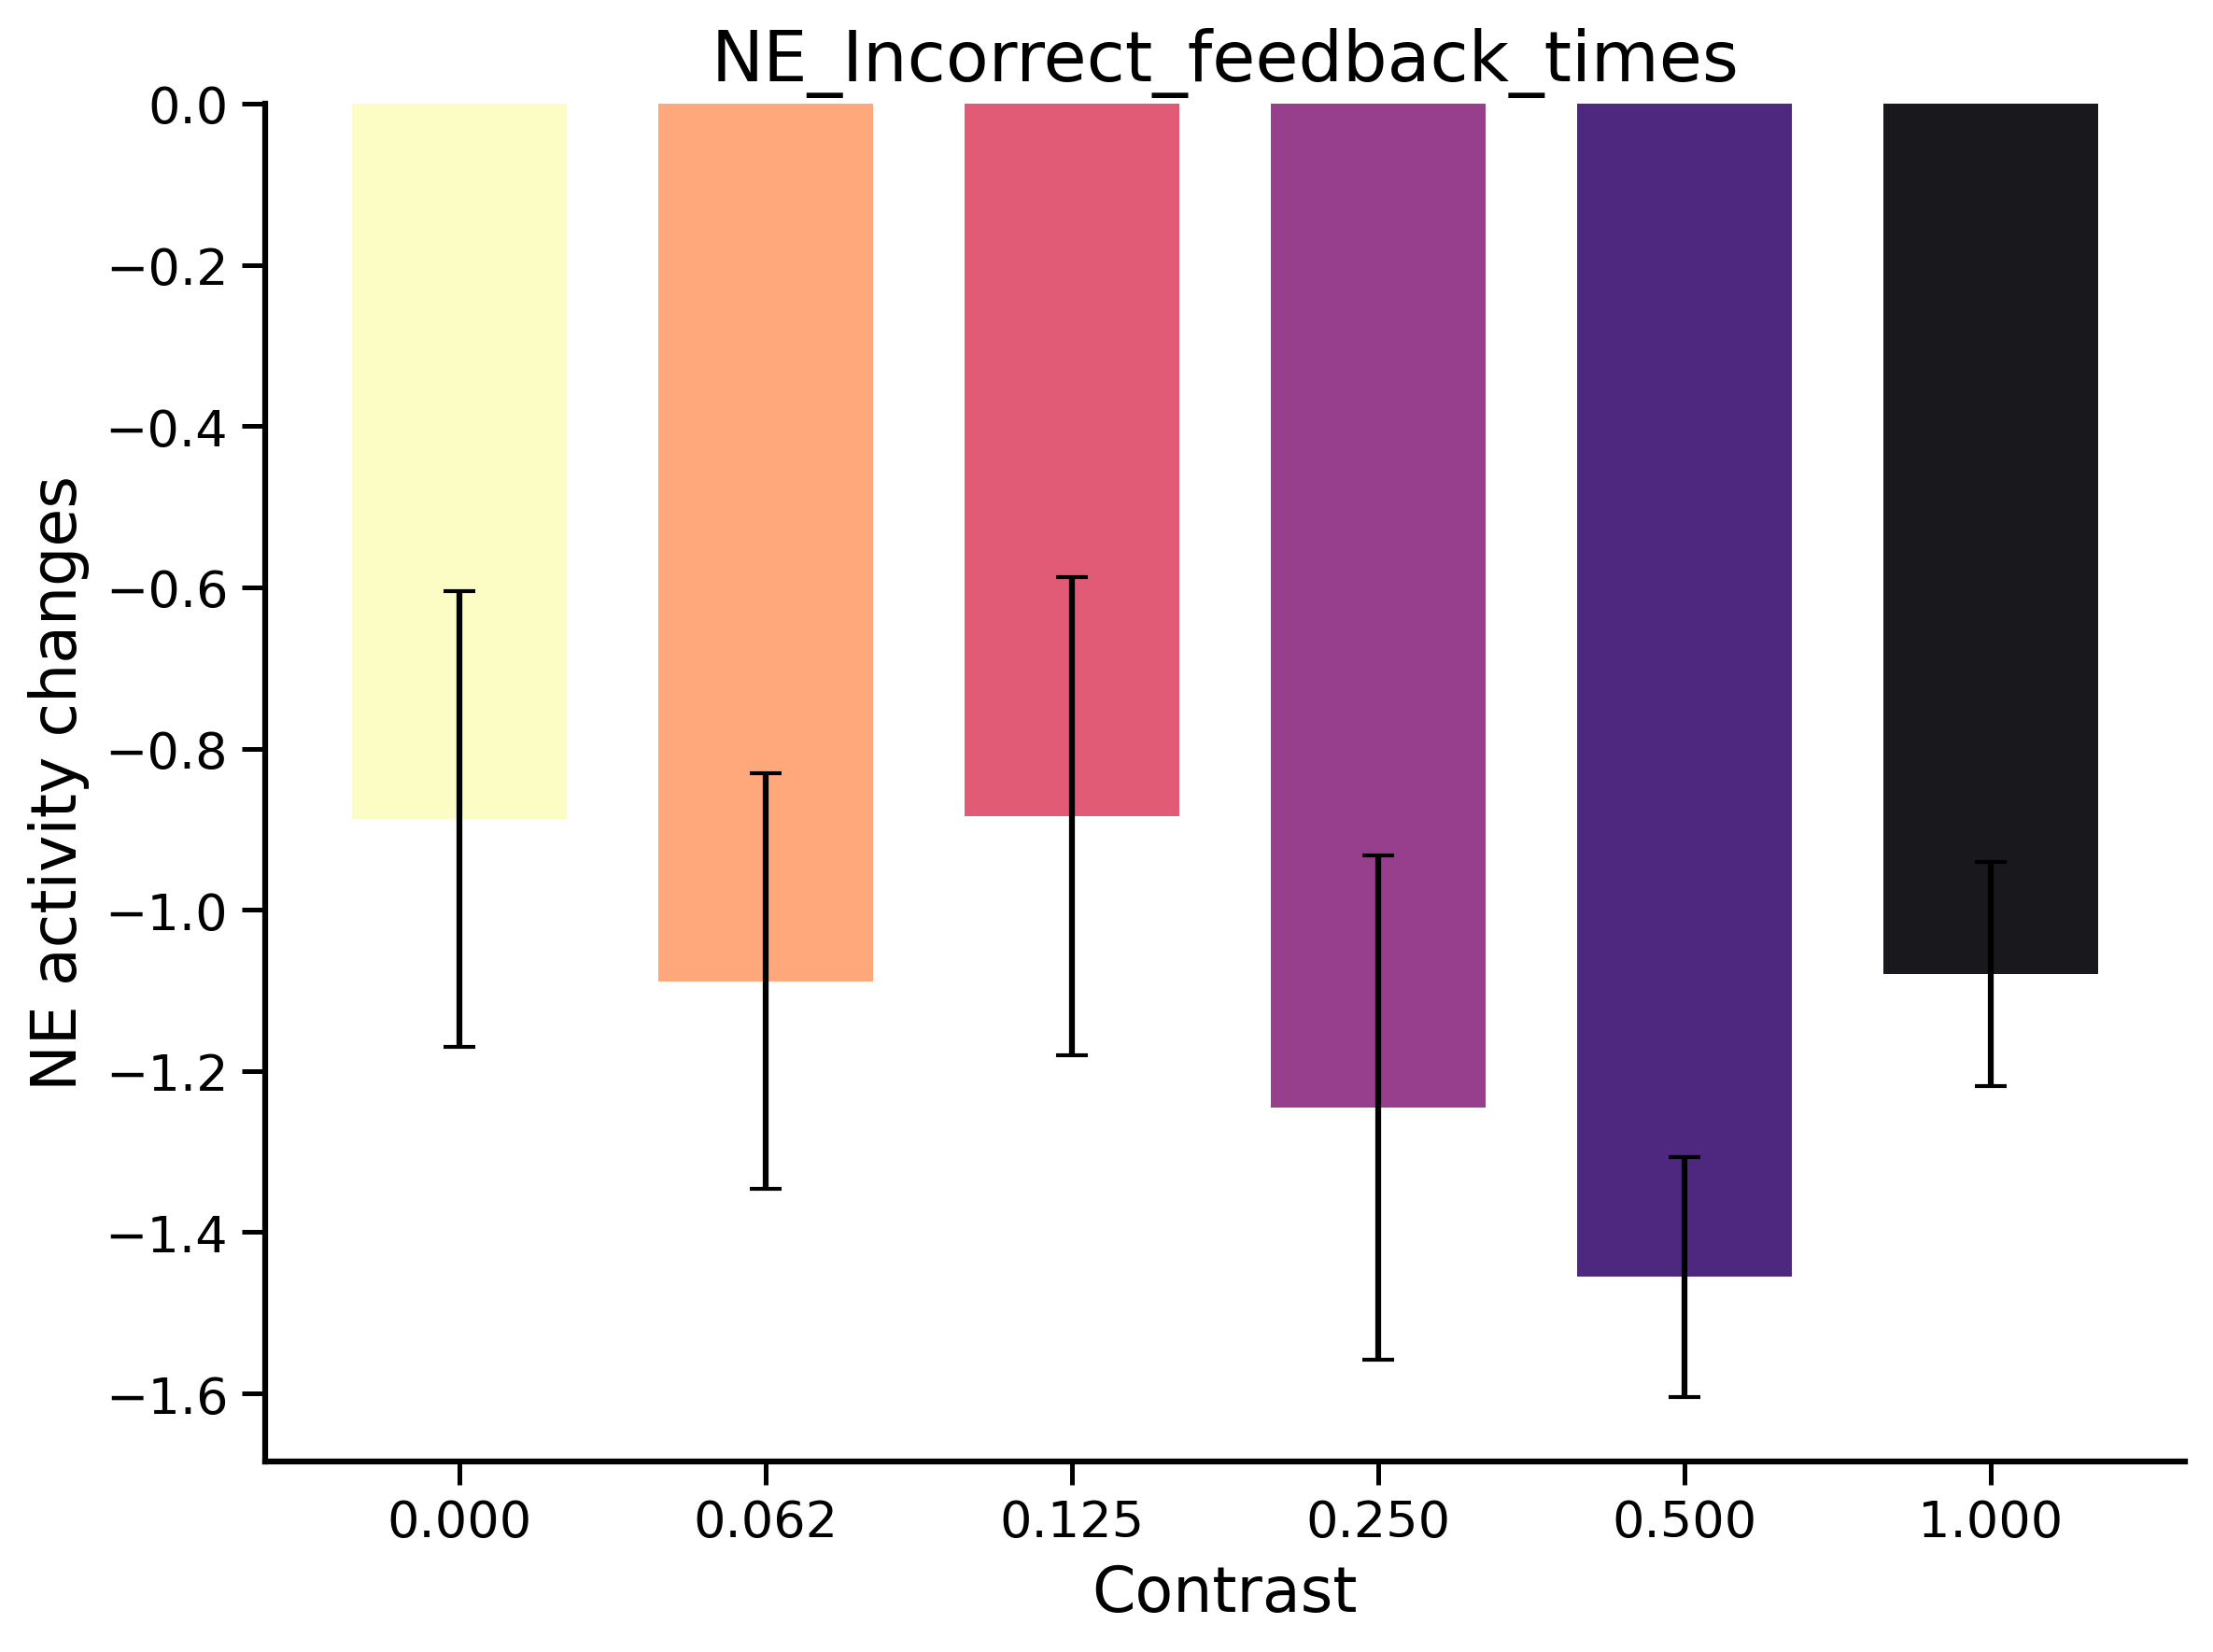

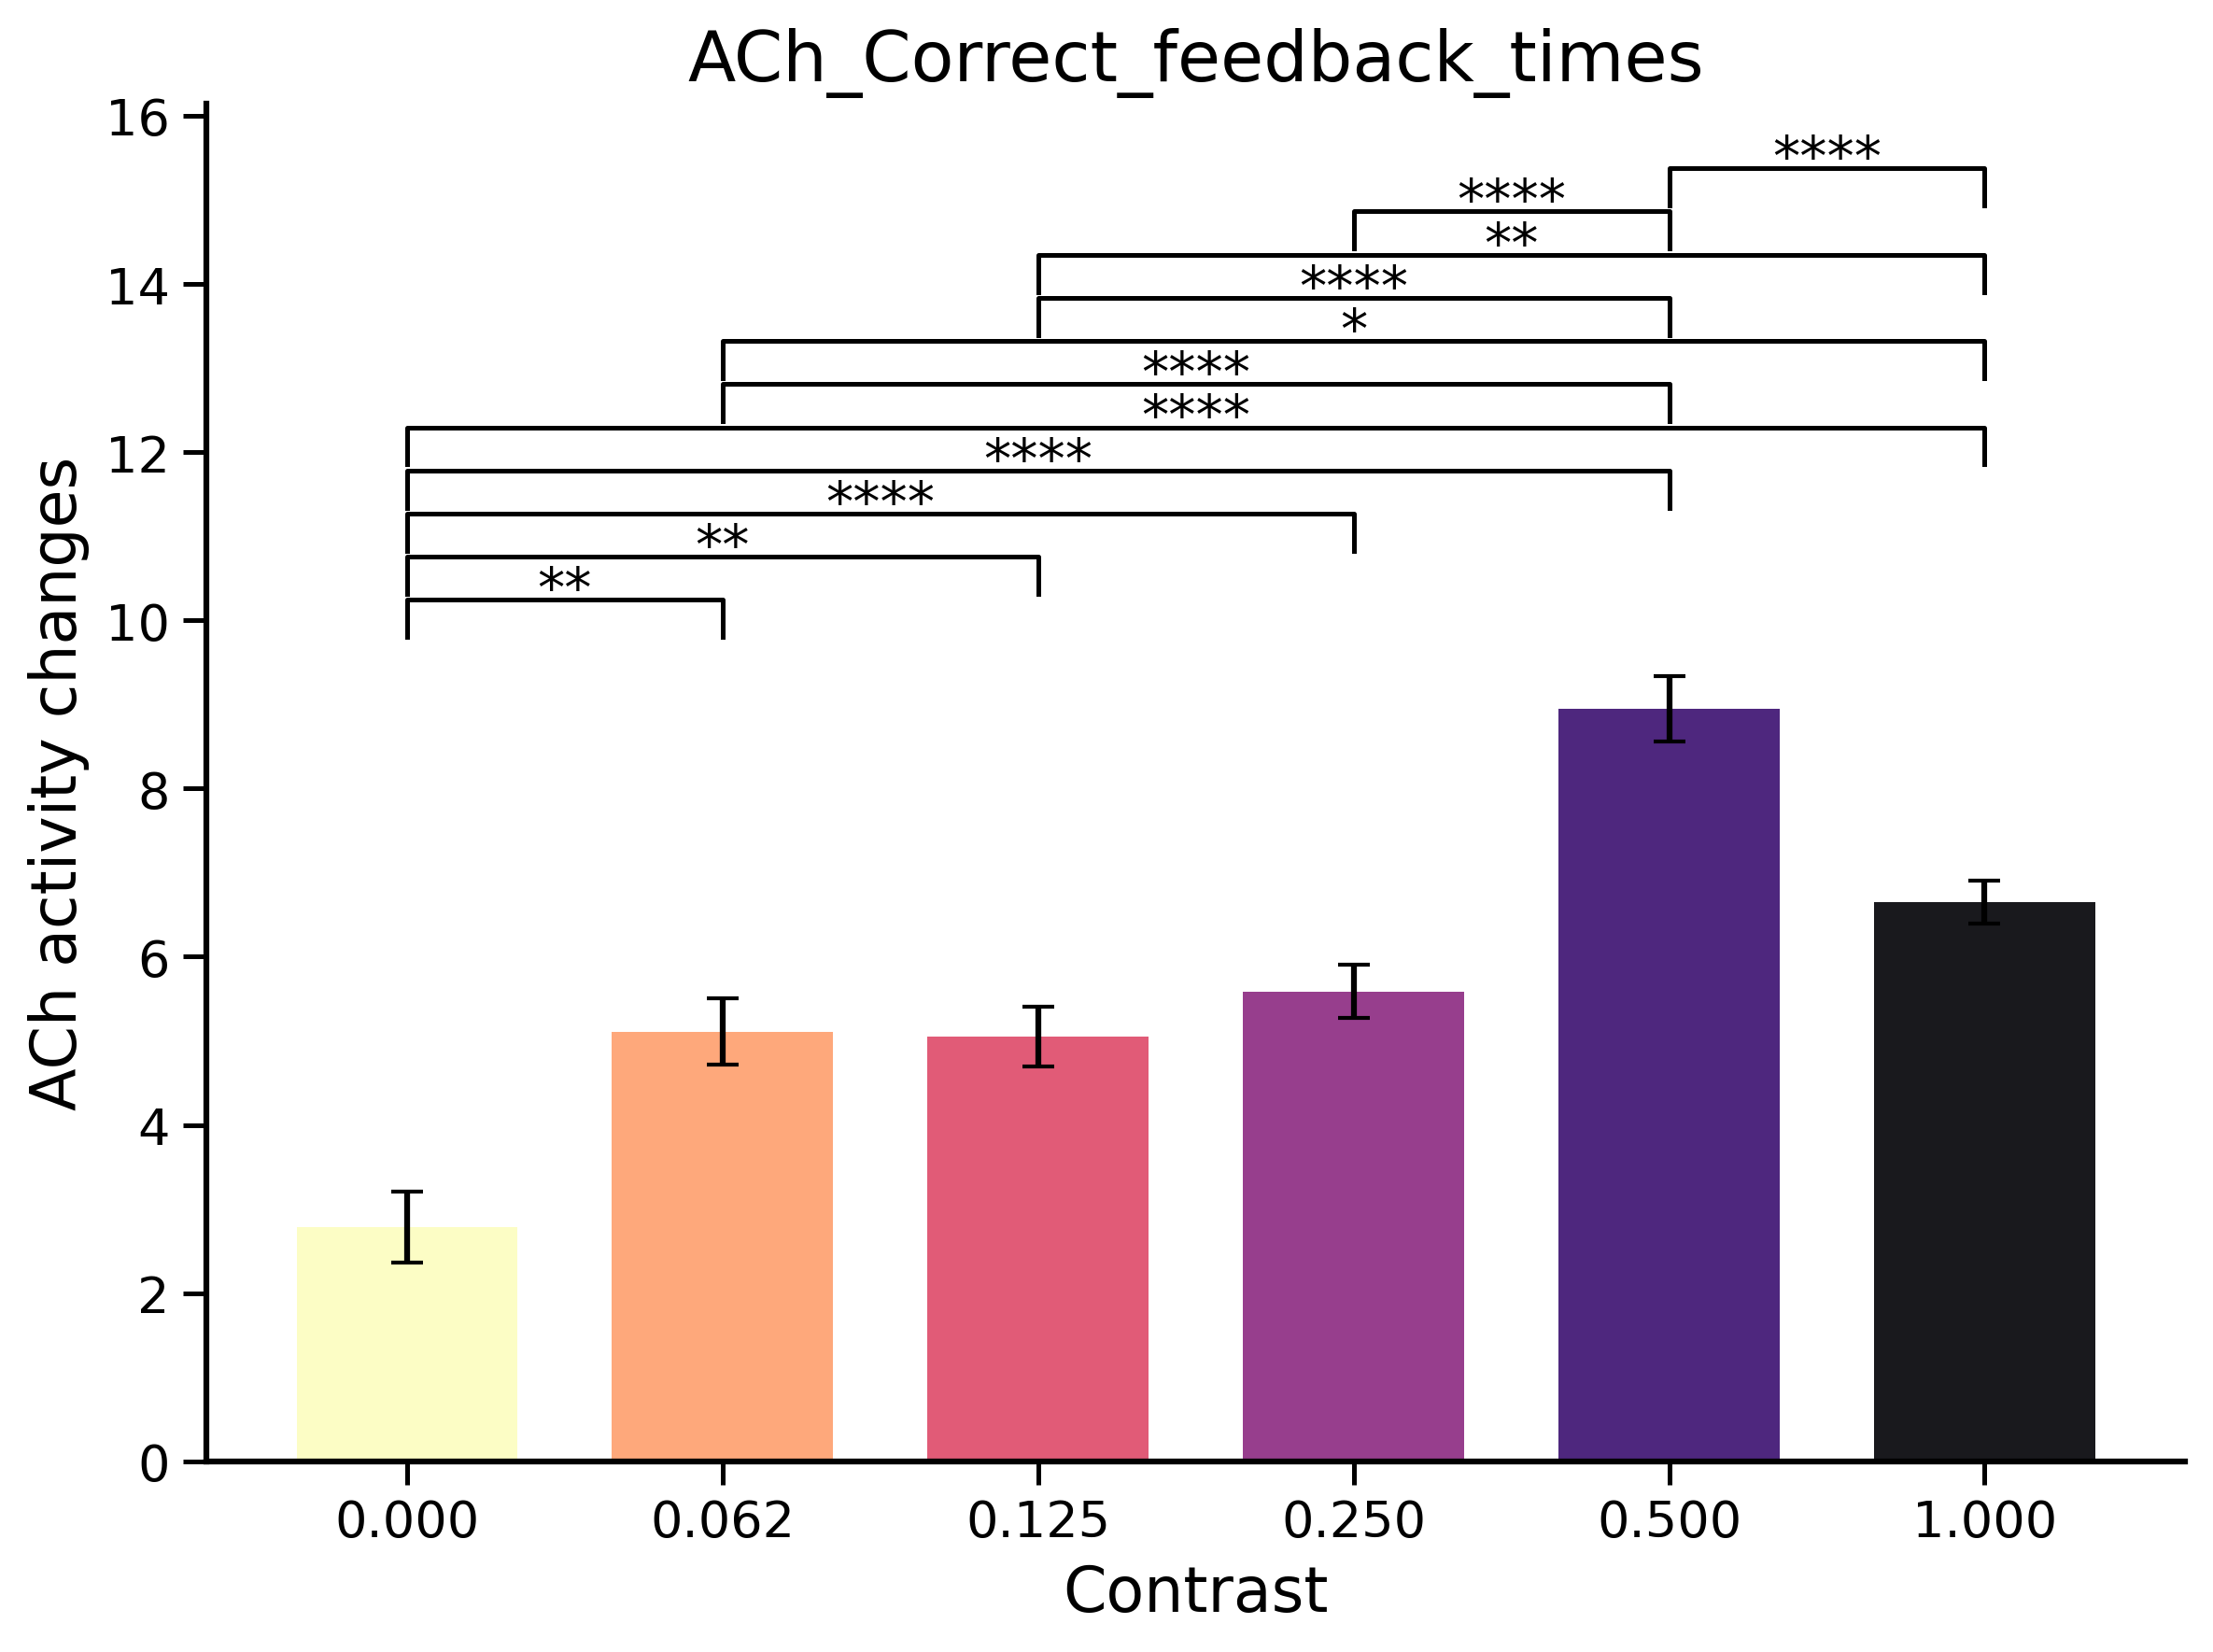

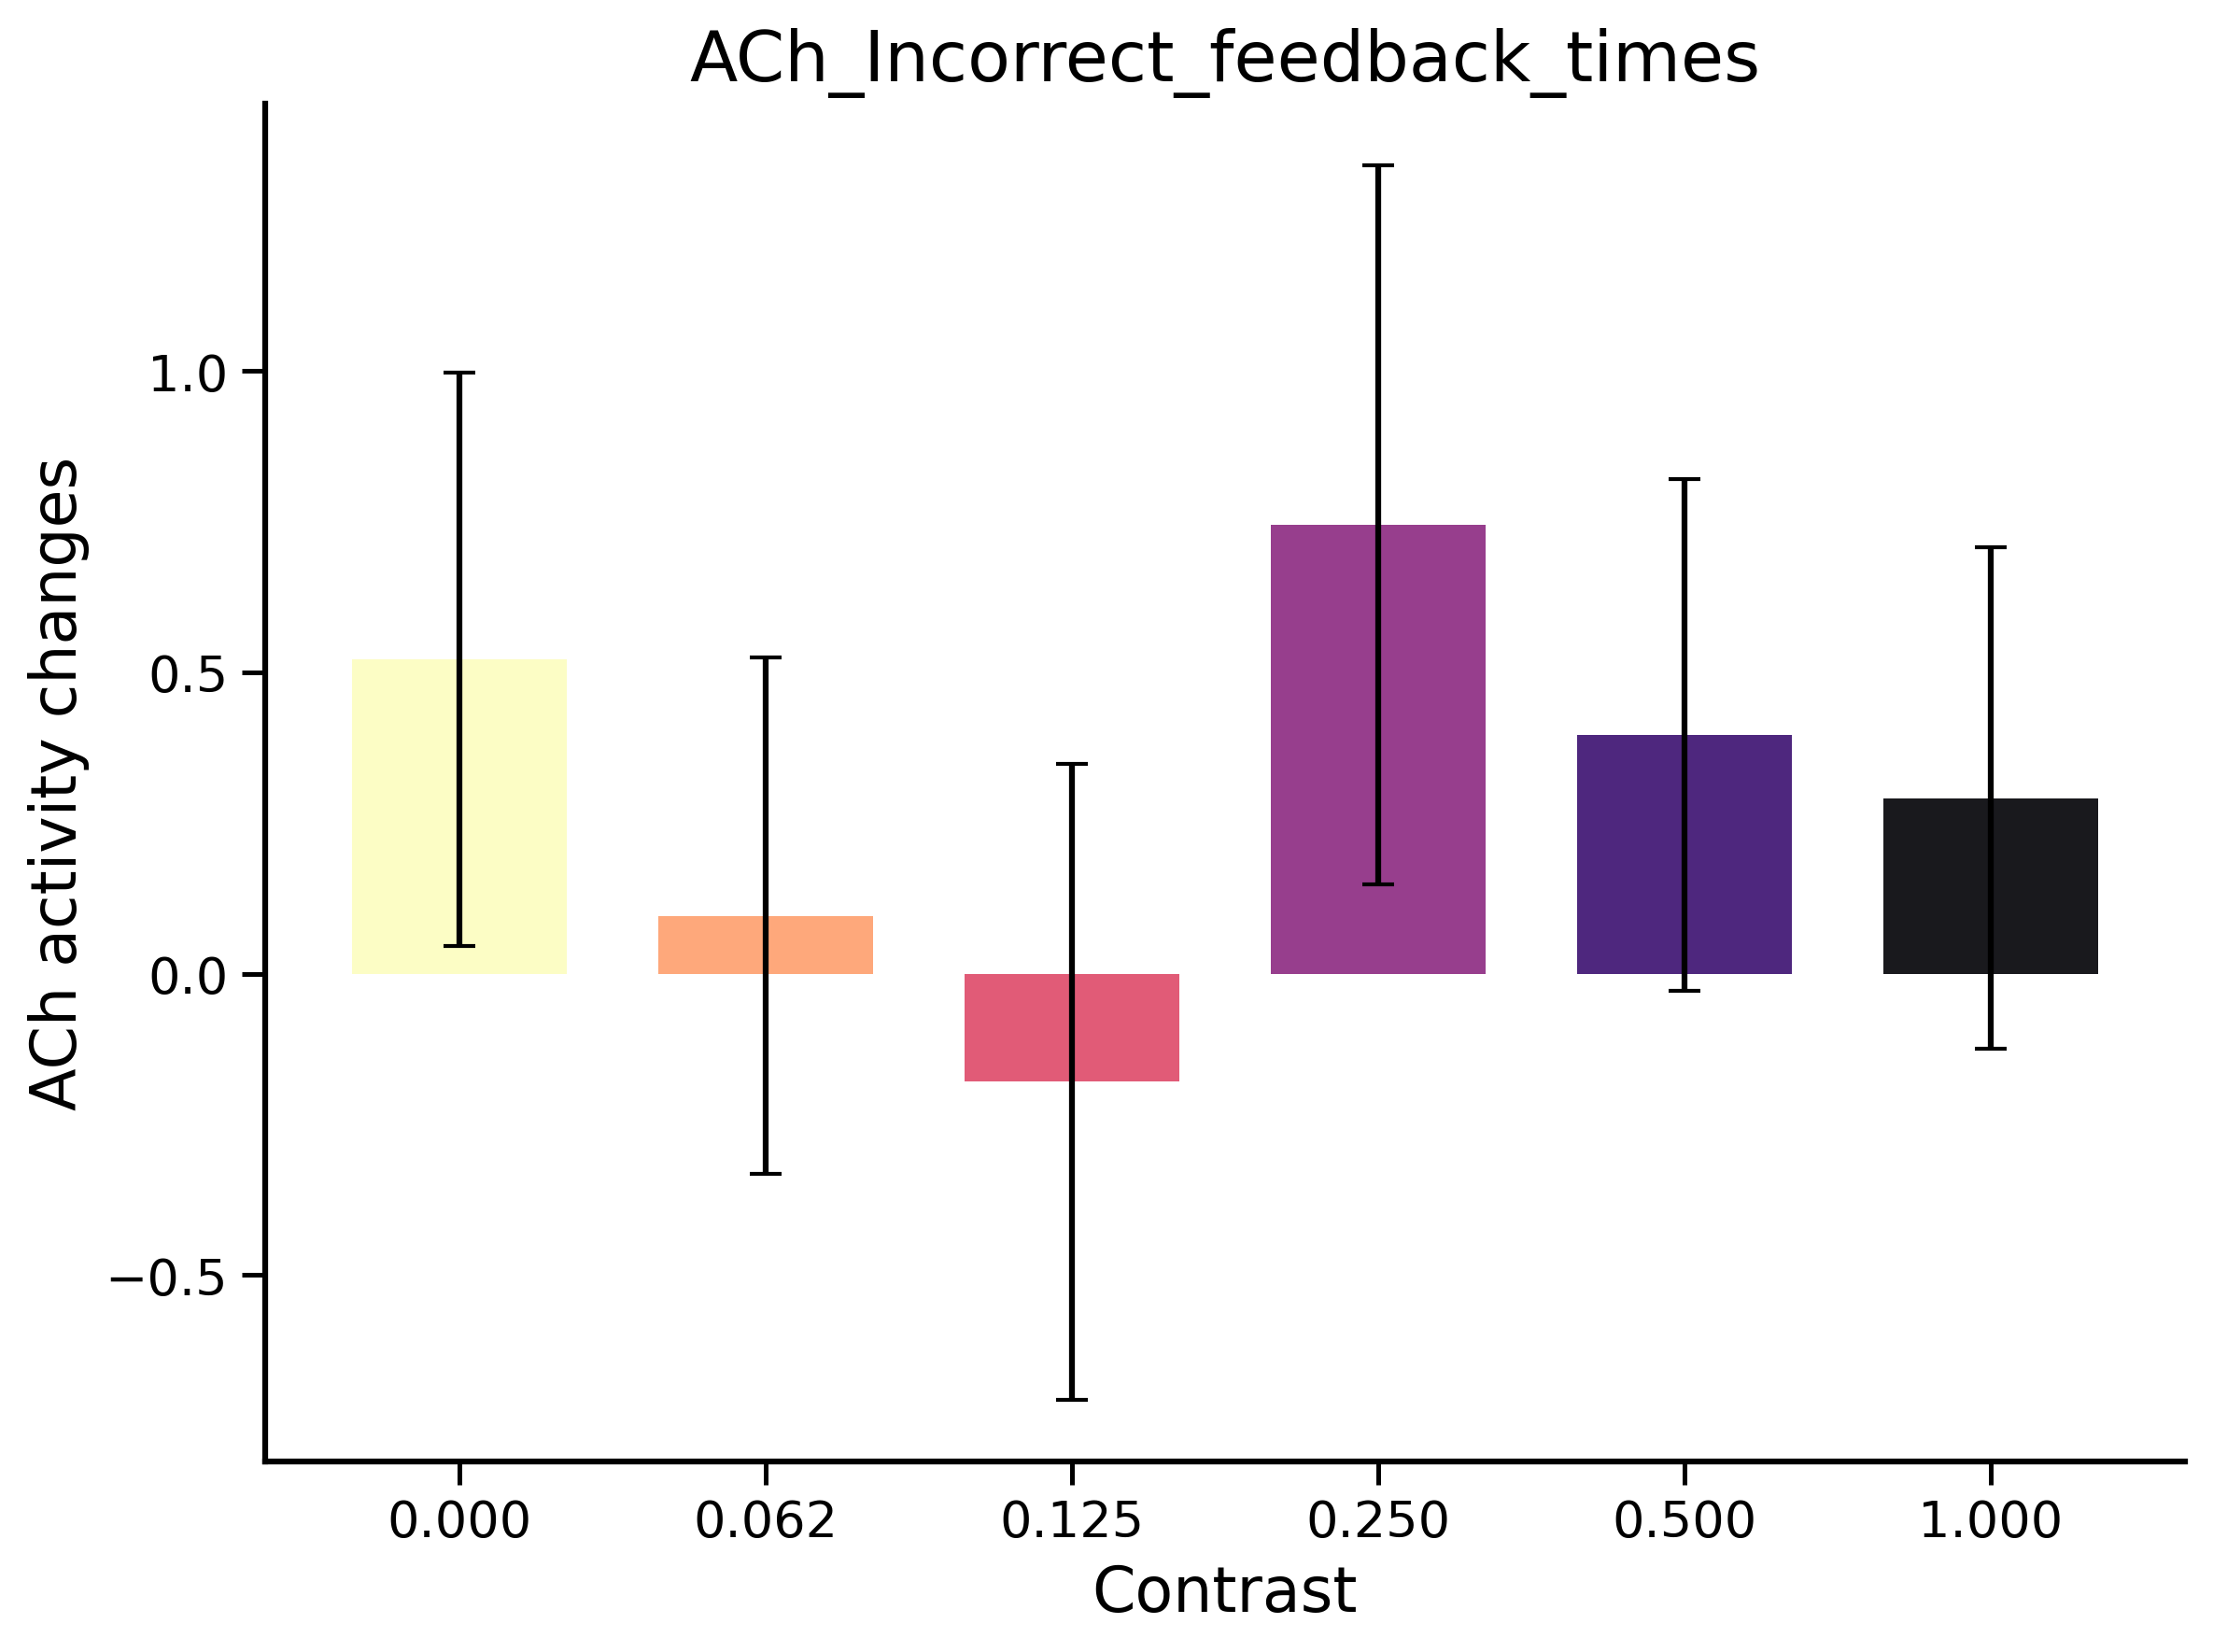

In [43]:
""" ALL THE CODE FOR THE CONTRASTS """

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from pingouin import pairwise_tukey
import pingouin as pg

import os
import matplotlib.patches as mpatches
import seaborn as sns

# path_to_data = '/mnt/h0/kb/Feb2025/data_behav_psth/Good_sessions/'
path_to_data = '/home/kceniabougrova/Documents/NM_project_fromIBLserver/Good_sessions'
EVENTS = ['feedback_times']


#===========================================================================
def pad_to_match_length(arr, target_length):
    """Pad or trim an array to match the target length along the time axis."""
    current_length = arr.shape[0]
    if current_length == target_length:
        return arr
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(arr, ((0, padding), (0, 0)), mode='constant')
    else:
        return arr[:target_length, :]

def load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW):
    """Load and pad/interpolate psth and df_trials for a group of mice to a common length."""
    combined_psth = []
    combined_trials = []
    target_rate = 30
    max_time_length = 0

    for mouse in group_mice:
        try:
            psth_path_30 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_30Hz.npy')
            psth_path_15 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_15Hz.npy')
            df_trials_path_30 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_30Hz.pqt')
            df_trials_path_15 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_15Hz.pqt')
            
            if os.path.exists(psth_path_30):
                psth = np.load(psth_path_30)
                df_trials = pd.read_parquet(df_trials_path_30)
            elif os.path.exists(psth_path_15):
                psth = np.load(psth_path_15)
                psth = interpolate_to_common_time(psth, current_rate=15, target_rate=30, PERIEVENT_WINDOW=PERIEVENT_WINDOW)
                df_trials = pd.read_parquet(df_trials_path_15)
            else:
                continue

            max_time_length = max(max_time_length, psth.shape[0])
            combined_psth.append(psth)
            combined_trials.append(df_trials)
        
        except Exception as e:
            print(f"Error loading data for {mouse} | Event: {event}: {e}")
    
    if combined_psth and combined_trials:
        # Pad all PSTH arrays to match the longest one
        combined_psth = [pad_to_match_length(psth, max_time_length) for psth in combined_psth]
        psth_combined = np.concatenate(combined_psth, axis=1)
        df_trials_combined = pd.concat(combined_trials, ignore_index=True)
        return psth_combined, df_trials_combined
    else:
        return None, None

# ============================
# Helper: Stars from p-values
# ============================
def p_to_stars(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# ============================
# Helper: Plot barplot + stars
# ============================
def plot_with_significance(pairs, title, filename, contrast_labels, means, sems, colors, group_name):
    x = np.arange(len(contrast_labels))
    bar_width = 0.7

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    for i in range(len(x)):
        ax.bar(x[i], means[i], width=bar_width, yerr=sems[i], color=colors[i], alpha=0.9, capsize=4)

    y_max = np.max(means + sems)
    y_offset = y_max * 0.05
    current_y = y_max + y_offset

    label_to_x = {label: xi for label, xi in zip(contrast_labels, x)}

    for c1, c2, p_val in pairs:
        i1, i2 = label_to_x[c1], label_to_x[c2]
        x1, x2 = min(i1, i2), max(i1, i2)
        leg_height = y_offset * 0.95 #it was 0.8
        ax.plot([x1, x1, x2, x2], [current_y, current_y + leg_height, current_y + leg_height, current_y], lw=1.2, c='black')
        ax.text((x1 + x2) / 2, current_y + y_offset * 0.5, p_to_stars(p_val), ha='center', va='bottom', fontsize=14)
        current_y += y_offset * 1.1

    ax.set_xticks(x)
    ax.set_xticklabels(contrast_labels, fontsize=16)
    ax.set_xlabel("Contrast", fontsize=16)
    ax.set_ylabel(f"{group_name} activity changes", fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1.2, labelsize=13)
    ax.grid(False)
    plt.tight_layout()
    """ TO SAVE """
    # fig.savefig(f"/mnt/h0/kb/code_kcenia/stats/{filename}.png", dpi=300, bbox_inches='tight')
    # fig.savefig(f"/mnt/h0/kb/code_kcenia/stats/{filename}.pdf", dpi=300, bbox_inches='tight') 
    # fig.savefig(f"/home/kceniabougrova/Documents/Thesis_correction_figures/Contrasts/{filename}.png", dpi=300, bbox_inches='tight')
    # fig.savefig(f"/home/kceniabougrova/Documents/Thesis_correction_figures/Contrasts/{filename}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# ============================
# Data extraction + normalization
# ============================
def extract_normalized_response(df_trials, psth_data, contrast_list, feedback_code, time_vector, response_idx, baseline_idx, epsilon=1e-6):
    result = []
    for contrast in contrast_list:
        idx = (df_trials['feedbackType'].values == feedback_code) & (df_trials['allContrasts'].values == contrast)
        if np.sum(idx) < 5:
            continue
        psth_subset = psth_data[idx]
        baseline = np.mean(psth_subset[:, baseline_idx], axis=1, keepdims=True)
        baseline_std = np.std(psth_subset[:, baseline_idx], axis=1, keepdims=True)
        aligned = psth_subset - baseline
        # normalized = aligned / (baseline_std + epsilon) 
        # normalized = aligned / (np.abs(baseline_std)) #COMMENTED ON 02072025
        # safe_baseline = np.maximum(np.abs(baseline), 0.05)
        # normalized = aligned / safe_baseline

        safe_baseline = np.maximum(np.abs(baseline), 0.05)
        normalized = (aligned) / safe_baseline #deltaF_over_F = normalized
        
        safe_baseline = np.maximum(np.abs(baseline), 0.05)
        percent_change = (aligned / safe_baseline) * 100
        response_vals = np.mean(percent_change[:, response_idx], axis=1)



        # normalized = aligned / (np.abs(baseline) + 1e-6) #std ADDED ON 02072025 only baseline added on 15072025 
        # response_vals = np.mean(normalized[:, response_idx], axis=1) #commented on 15072025
        for v in response_vals:
            result.append({'value': v, 'contrast': contrast, 'feedbackType': 'Correct' if feedback_code == 1 else 'Incorrect'})
    return pd.DataFrame(result)

# ============================
# Main analysis loop
# ============================
groups = {
    "DA": ["ZFM-03447", "ZFM-04026", "ZFM-04022_R", "ZFM-03448", "ZFM-04019", "ZFM-04022_L"],
    # "VTA": ["ZFM-03447", "ZFM-04026", "ZFM-04022_R"],
    # "SNc": ["ZFM-03448", "ZFM-04019", "ZFM-04022_L"],
    "5-HT": ["ZFM-03059", "ZFM-03065", "ZFM-03061", "ZFM-03062", "ZFM-04392_DRN", "ZFM-05235", "ZFM-05236", "ZFM-05245", "ZFM-05248"],
    # "DR": ["ZFM-03059", "ZFM-03065", "ZFM-03061", "ZFM-04392_DRN", "ZFM-05235", "ZFM-05236", "ZFM-05245", "ZFM-05248"],
    # "MR": ["ZFM-03062"],
    "NE": ["ZFM-04533", "ZFM-04534_LC", "ZFM-06268", "ZFM-06271", "ZFM-06272_L", "ZFM-06272_R", "ZFM-06171", "ZFM-06275_L", "ZFM-06275_R"],
    # "LC_L": ["ZFM-04533", "ZFM-04534_LC", "ZFM-06268", "ZFM-06271", "ZFM-06272_L", "ZFM-06171", "ZFM-06275_L"],
    # "LC_R": ["ZFM-06272_R", "ZFM-06275_R"],
    # "ACh": ["ZFM-06305_L", "ZFM-06305_R", "ZFM-06948"],
    "ACh": ["ZFM-06305_L", "ZFM-06948"]
    # "SI_R": ["ZFM-06305_R"]
}


time_vector = np.linspace(-1, 2, 91)
baseline_idx = np.where((time_vector >= -0.2) & (time_vector < 0))[0]
response_idx = np.where((time_vector >= 0) & (time_vector < 0.5))[0]
cmap = get_cmap('magma_r')

events = ['stimOnTrigger_times', 'feedback_times']
feedback_types = {'Correct': 1, 'Incorrect': -1}

for event in events:
    for group_name, group_mice in groups.items():
        psth_combined, df_trials_combined = load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW=[-1, 2])
        if psth_combined.shape[0] == 91:
            psth_combined = psth_combined.T
        unique_contrasts = np.sort(np.unique(df_trials_combined['allContrasts'].values))
        colors = cmap(np.linspace(0, 1, len(unique_contrasts)))

        for fb_label, fb_code in feedback_types.items():
            df_plot = extract_normalized_response(df_trials_combined, psth_combined, unique_contrasts,
                                                  feedback_code=fb_code,
                                                  time_vector=time_vector,
                                                  response_idx=response_idx,
                                                  baseline_idx=baseline_idx)
            aov = pg.anova(data=df_plot, dv='value', between='contrast', detailed=True)
            posthoc = pg.pairwise_tukey(data=df_plot, dv='value', between='contrast')

            contrast_labels = [f"{c:.3f}" for c in unique_contrasts]
            means = df_plot.groupby('contrast')['value'].mean().reindex(unique_contrasts).values
            sems = df_plot.groupby('contrast')['value'].sem().reindex(unique_contrasts).values

            significant_pairs_all = [
                (f"{row['A']:.3f}", f"{row['B']:.3f}", row['p-tukey'])
                for _, row in posthoc.iterrows() if row['p-tukey'] < 0.05
            ]

            filename = f"barplot_{group_name}_{event}_{fb_label}".replace(" ", "_")
            plot_with_significance(significant_pairs_all, title=f"{group_name}_{fb_label}_{event}",
                                   filename=filename,
                                   contrast_labels=contrast_labels,
                                   means=means,
                                   sems=sems,
                                   colors=colors,
                                   group_name=group_name)

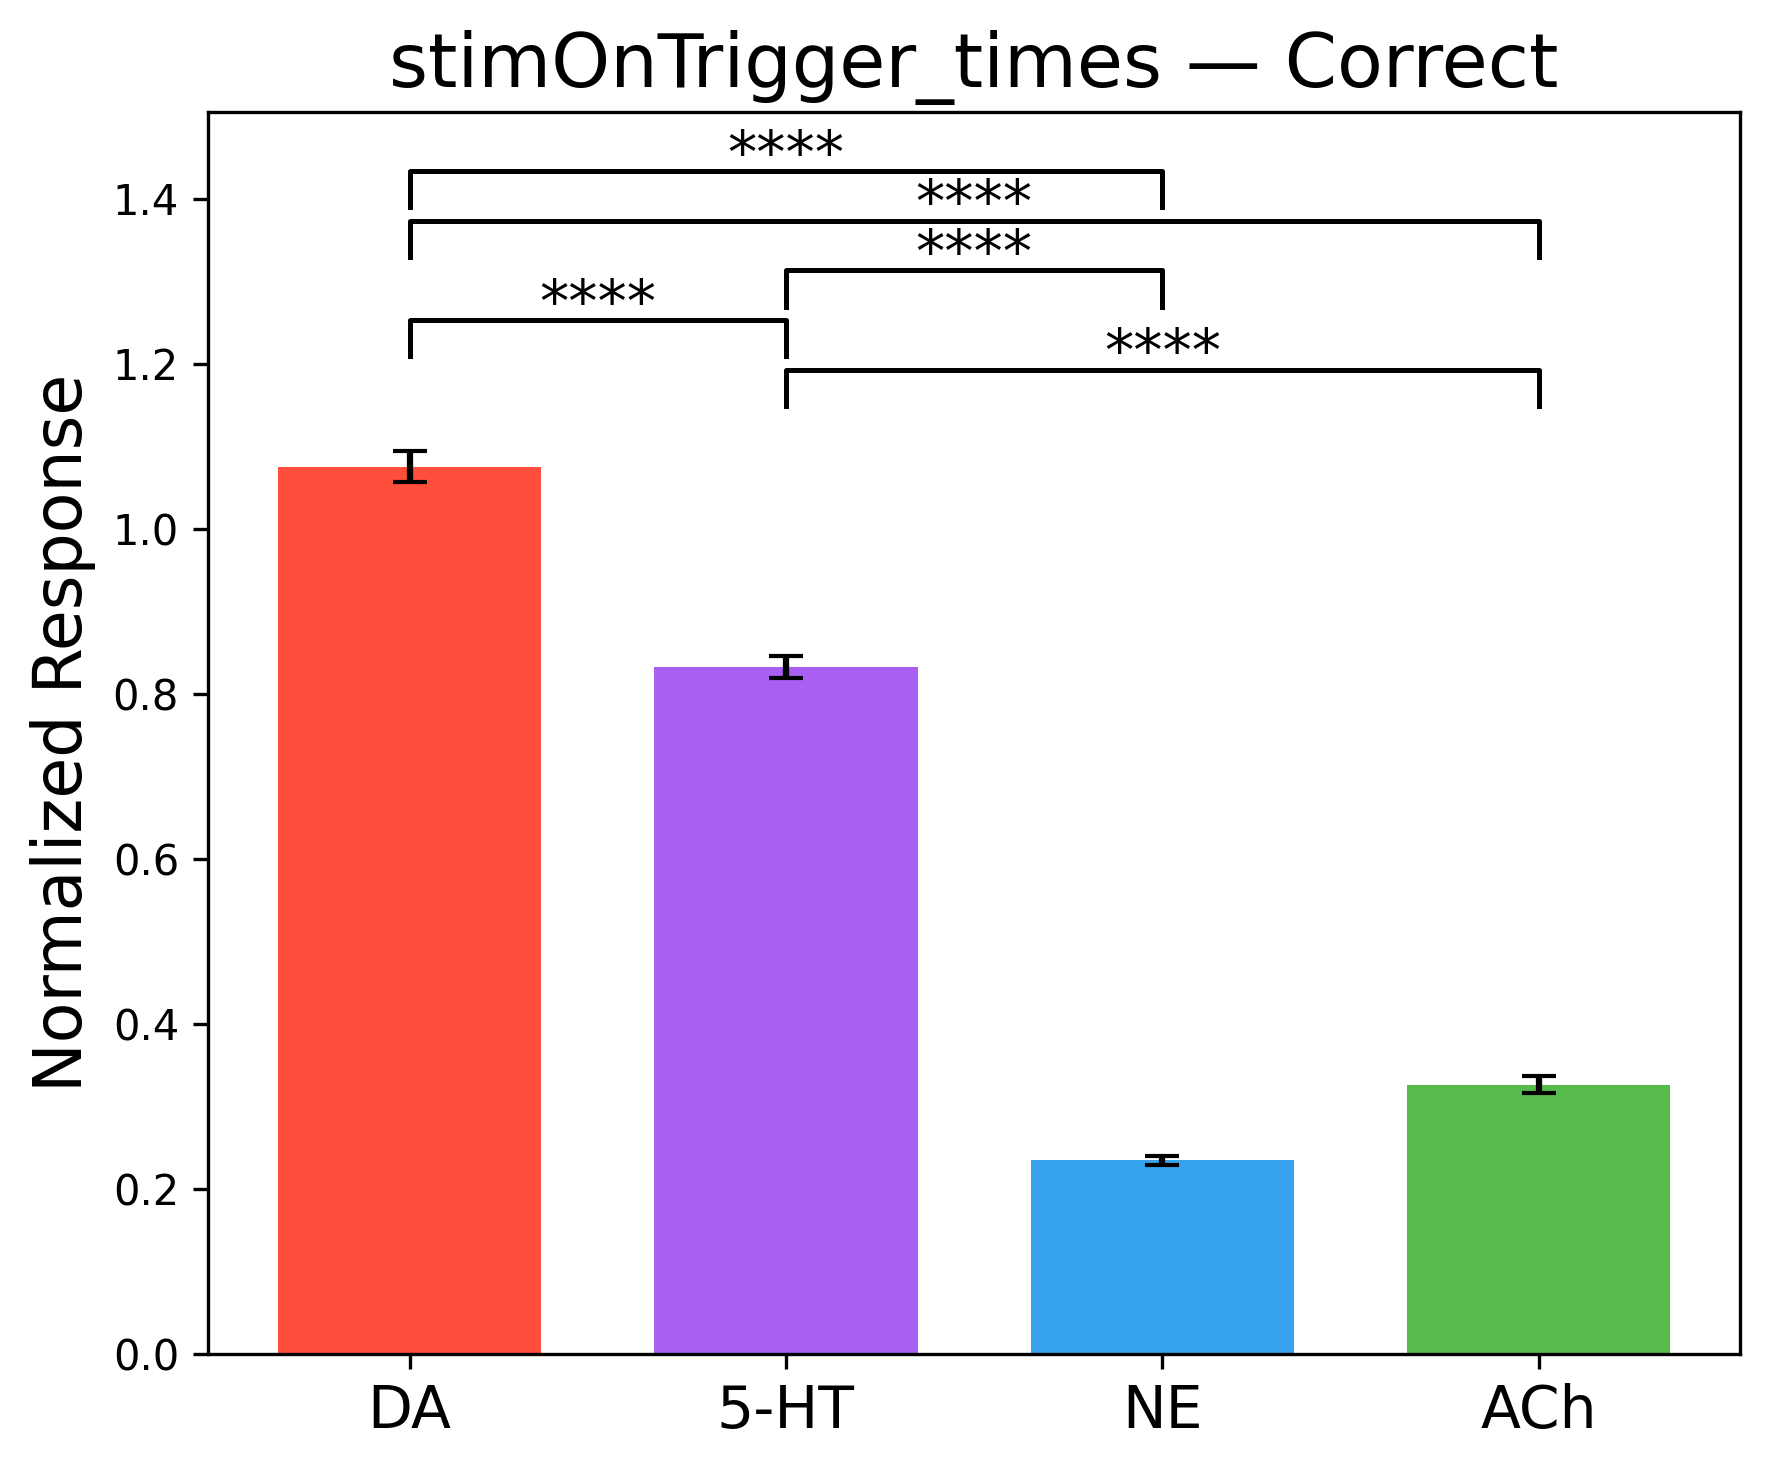

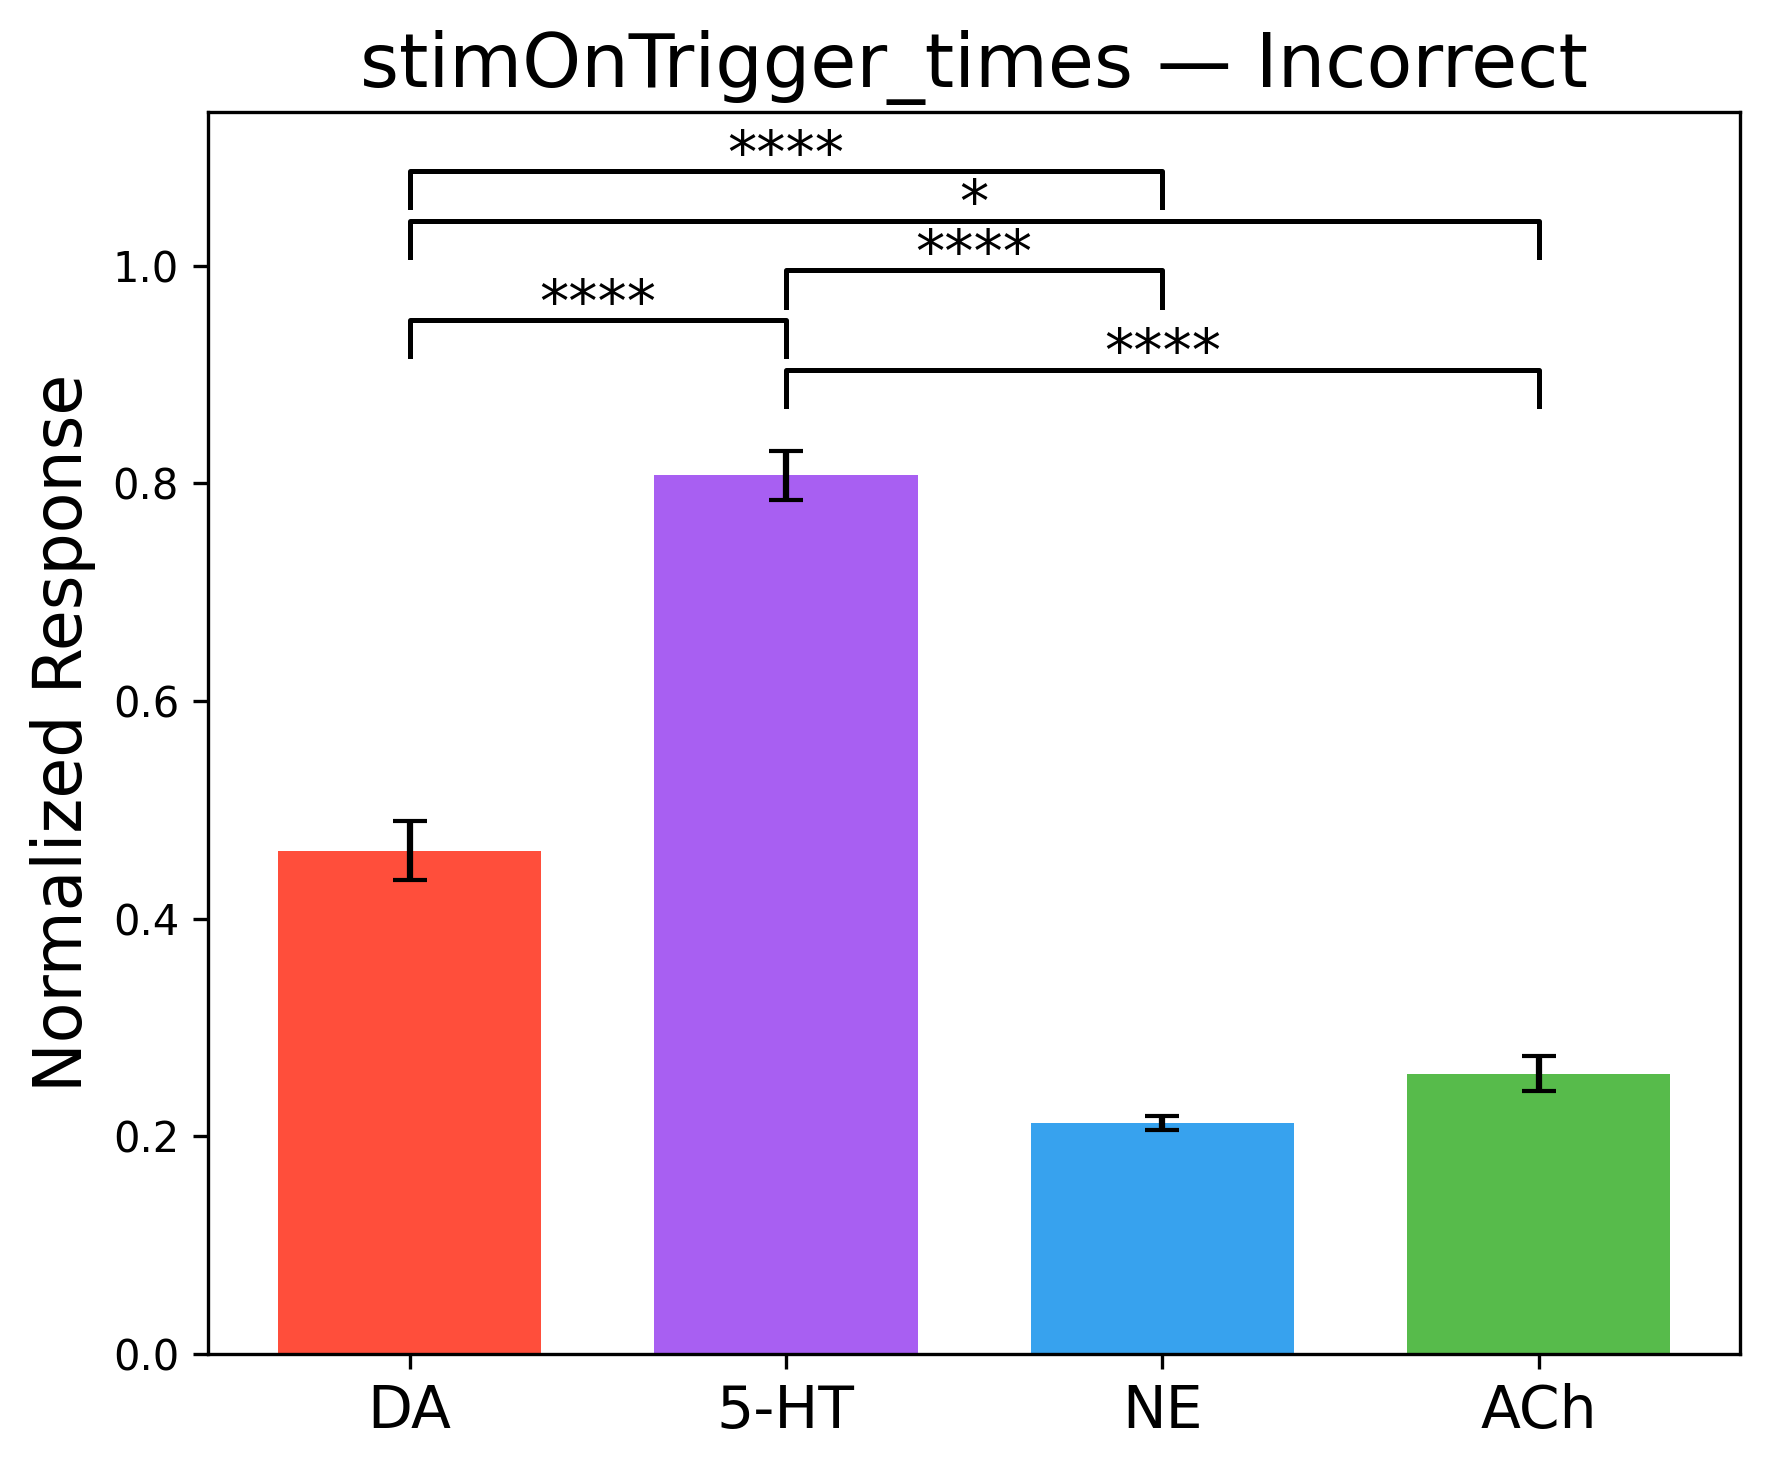

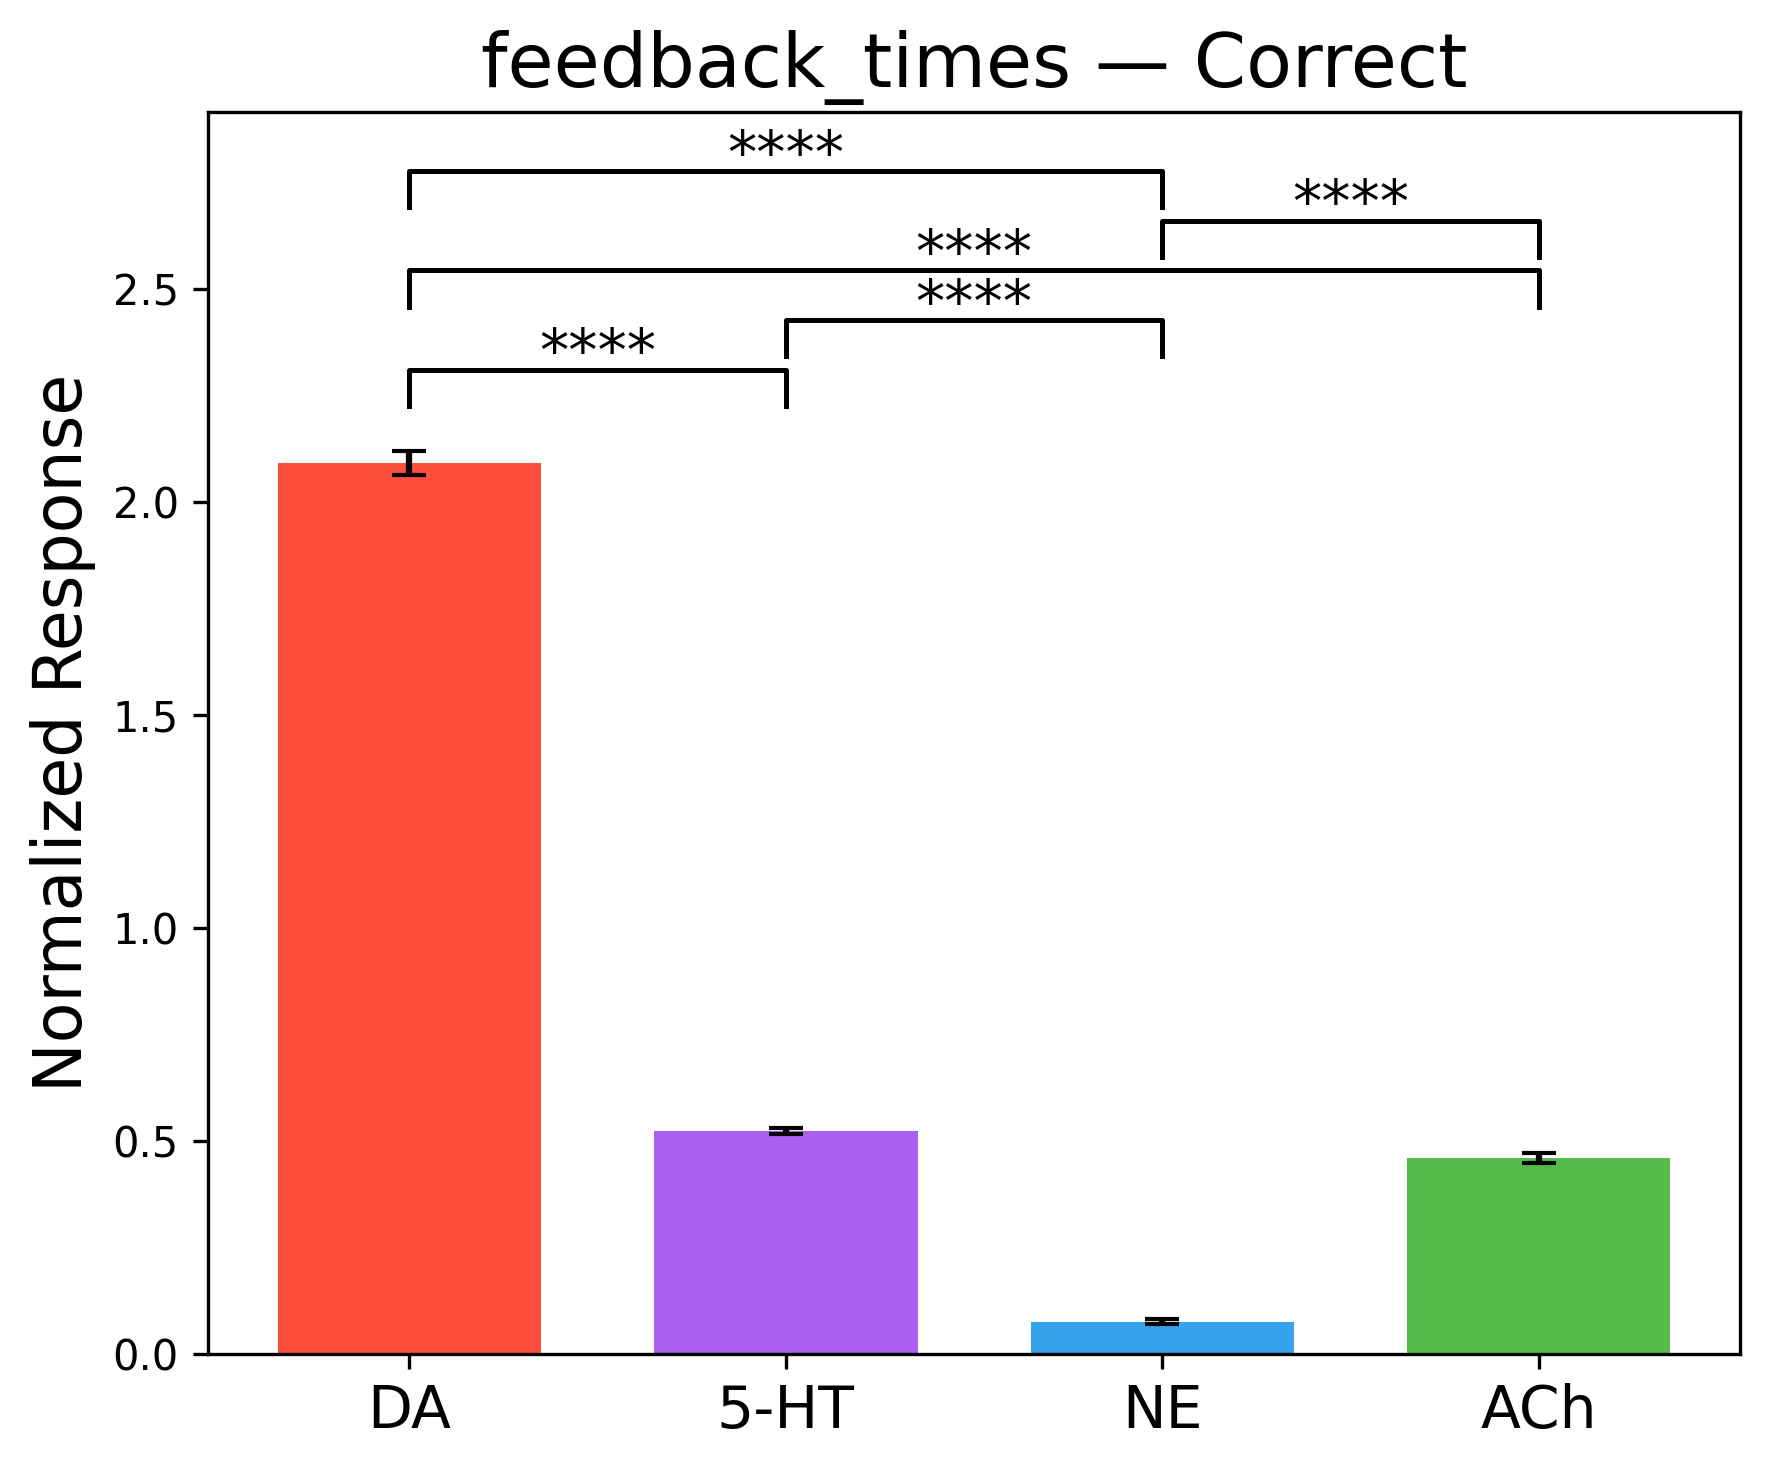

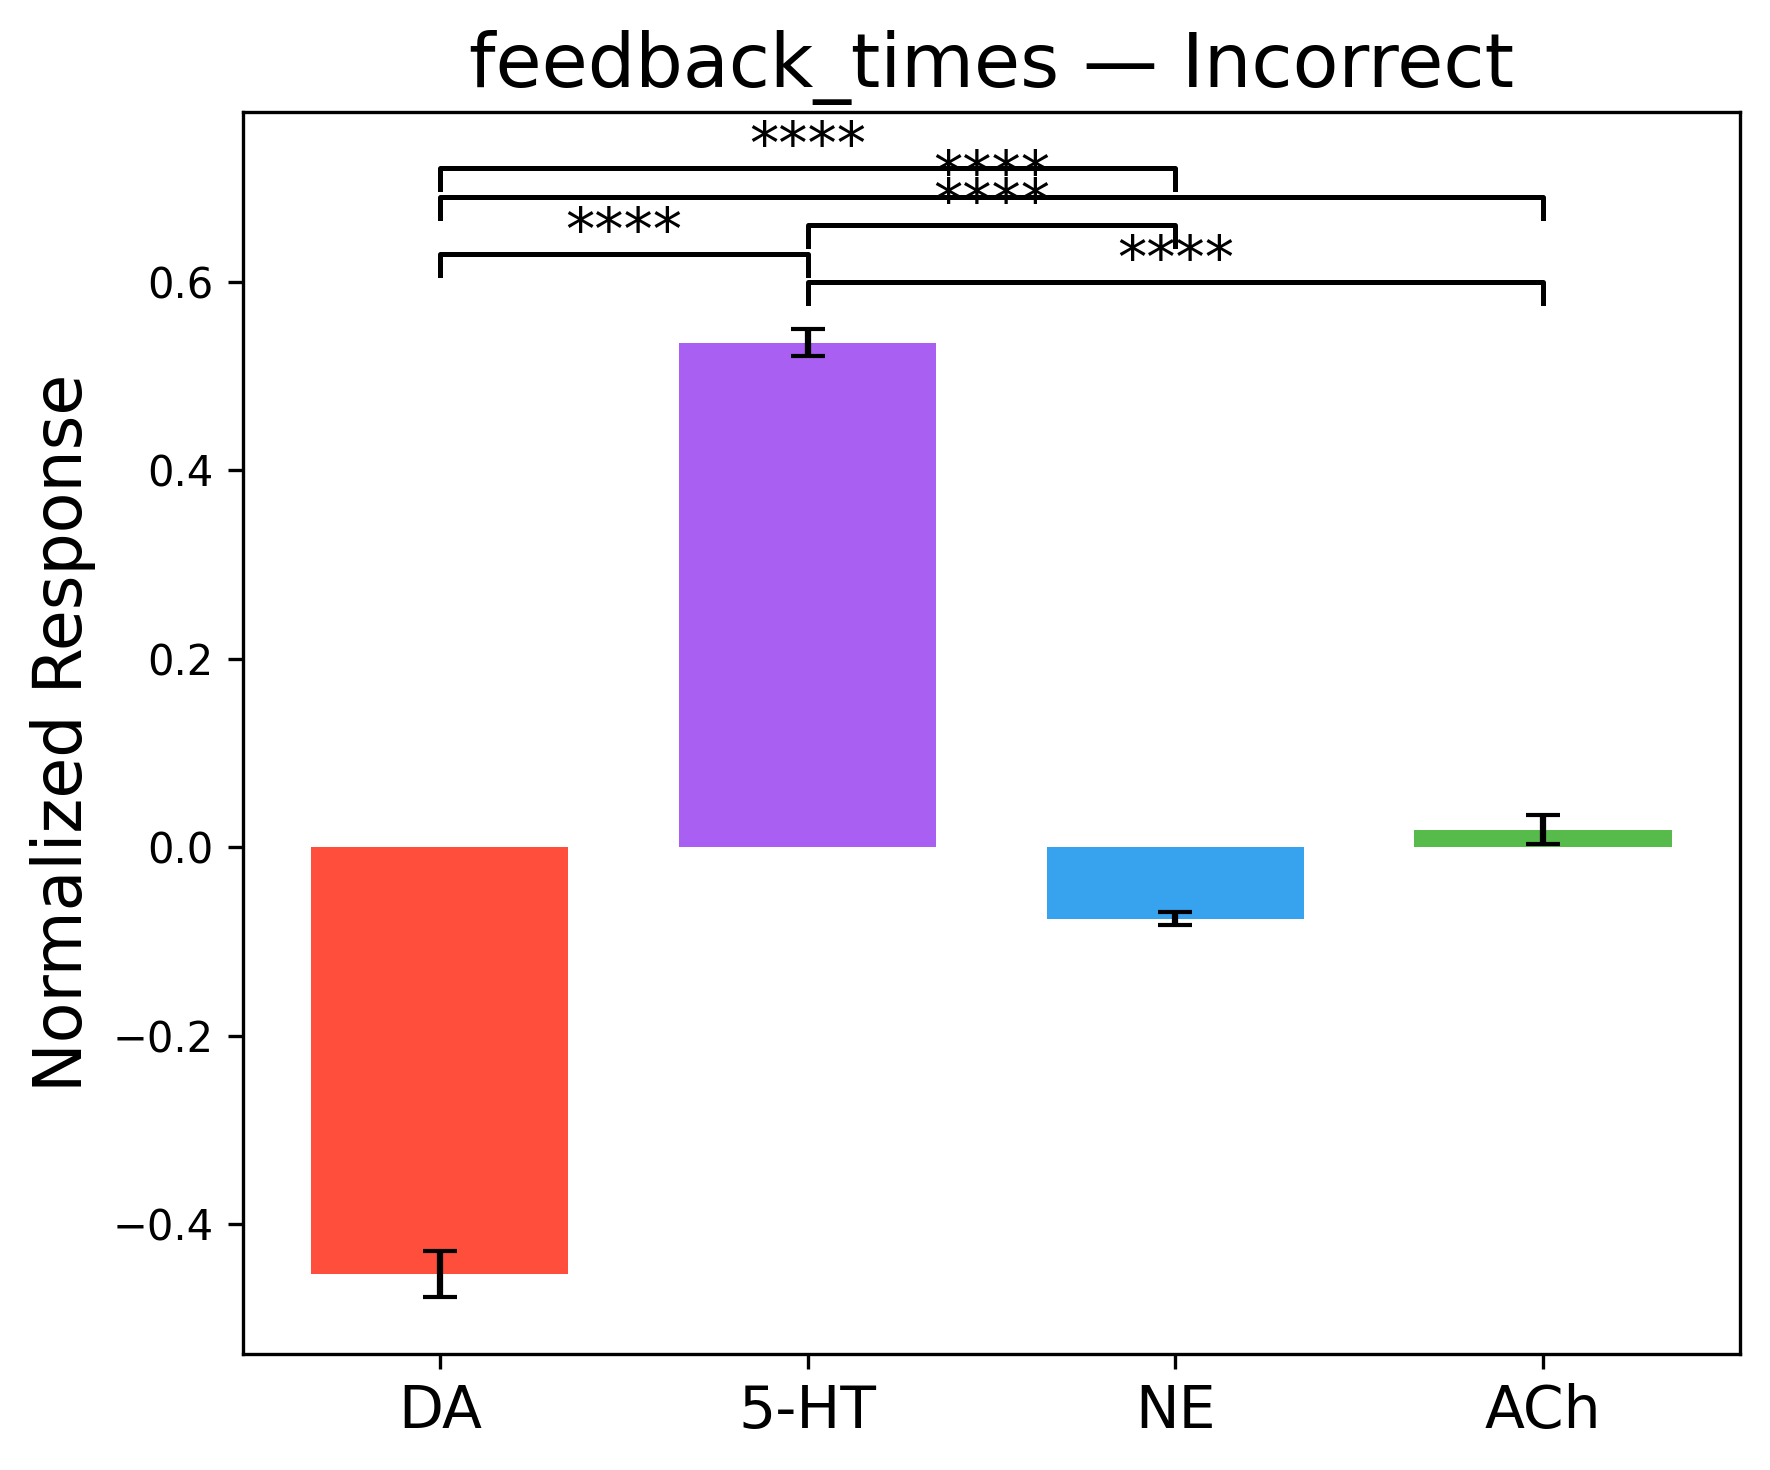

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pingouin as pg

# ============================
# Helpers
# ============================
def pad_to_match_length(arr, target_length):
    current_length = arr.shape[0]
    if current_length == target_length:
        return arr
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(arr, ((0, padding), (0, 0)), mode='constant')
    else:
        return arr[:target_length, :]

def interpolate_to_common_time(psth, current_rate, target_rate, PERIEVENT_WINDOW):
    from scipy.interpolate import interp1d
    old_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], psth.shape[0])
    new_len = int((PERIEVENT_WINDOW[1] - PERIEVENT_WINDOW[0]) * target_rate) + 1
    new_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], new_len)
    interp = interp1d(old_time, psth, axis=0, kind='linear')
    return interp(new_time)

def p_to_stars(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# ============================
# Load Data
# ============================
def load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW):
    combined_psth = []
    combined_trials = []
    max_time_length = 0

    for mouse in group_mice:
        try:
            psth_path_30 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_30Hz.npy')
            psth_path_15 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_15Hz.npy')
            df_trials_path_30 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_30Hz.pqt')
            df_trials_path_15 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_15Hz.pqt')

            if os.path.exists(psth_path_30):
                psth = np.load(psth_path_30)
                df_trials = pd.read_parquet(df_trials_path_30)
            elif os.path.exists(psth_path_15):
                psth = np.load(psth_path_15)
                psth = interpolate_to_common_time(psth, 15, 30, PERIEVENT_WINDOW)
                df_trials = pd.read_parquet(df_trials_path_15)
            else:
                continue

            max_time_length = max(max_time_length, psth.shape[0])
            combined_psth.append(psth)
            combined_trials.append(df_trials)

        except Exception as e:
            print(f"Error loading {mouse} {event}: {e}")

    if combined_psth and combined_trials:
        combined_psth = [pad_to_match_length(psth, max_time_length) for psth in combined_psth]
        psth_combined = np.concatenate(combined_psth, axis=1)
        df_trials_combined = pd.concat(combined_trials, ignore_index=True)
        return psth_combined, df_trials_combined
    else:
        return None, None

# ============================
# Plotting function
# ============================
def plot_NM_barplot(df_values, event_label, feedback_label, color_palette):
    nms = df_values['group_name'].unique()
    means = df_values.groupby('group_name')['value'].mean().reindex(nms).values
    sems = df_values.groupby('group_name')['value'].sem().reindex(nms).values
    colors = [color_palette[nm] for nm in nms]

    x = np.arange(len(nms))
    bar_width = 0.7

    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    for i in range(len(x)):
        ax.bar(x[i], means[i], width=bar_width, yerr=sems[i], color=colors[i], alpha=0.9, capsize=4)

    # ANOVA + Tukey
    aov = pg.anova(data=df_values, dv='value', between='group_name', detailed=True)
    posthoc = pg.pairwise_tukey(data=df_values, dv='value', between='group_name')

    y_max = np.max(means + sems)
    y_offset = y_max * 0.05
    current_y = y_max + y_offset
    label_to_x = {label: xi for label, xi in zip(nms, x)} 

    for _, row in posthoc.iterrows():
        if row['p-tukey'] < 0.05:
            i1, i2 = label_to_x[row['A']], label_to_x[row['B']]
            x1, x2 = min(i1, i2), max(i1, i2)
            ax.plot([x1, x1, x2, x2],
                    [current_y, current_y + y_offset * 0.8, current_y + y_offset * 0.8, current_y],
                    lw=1.2, c='black')
            ax.text((x1 + x2) / 2, current_y + y_offset * 0.5, p_to_stars(row['p-tukey']),
                    ha='center', va='bottom', fontsize=14)
            current_y += y_offset * 1.1

    ax.set_xticks(x)
    ax.set_xticklabels(nms, fontsize=14)
    ax.set_ylabel("Normalized Response", fontsize=16)
    ax.set_title(f"{event_label} — {feedback_label}", fontsize=18)
    plt.tight_layout()
    # Save figure
    # if not os.path.exists('/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/'):
    #     os.makedirs('/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/')

    filename_base = f"/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/barplot_{event_label}_{feedback_label}_final"
    plt.savefig(filename_base + ".png", dpi=300, bbox_inches='tight')
    plt.savefig(filename_base + ".pdf", dpi=300, bbox_inches='tight')
    plt.show()

# ============================
# Main Analysis
# ============================
groups = {
    "DA": ["ZFM-03447", "ZFM-04026", "ZFM-04022_R", "ZFM-03448", "ZFM-04019", "ZFM-04022_L"],
    "5-HT": ["ZFM-03059", "ZFM-03065", "ZFM-03061", "ZFM-03062", "ZFM-04392_DRN", "ZFM-05235", "ZFM-05236", "ZFM-05245", "ZFM-05248"],
    "NE": ["ZFM-04533", "ZFM-04534_LC", "ZFM-06268", "ZFM-06271", "ZFM-06272_L", "ZFM-06272_R", "ZFM-06171", "ZFM-06275_L", "ZFM-06275_R"],
    "ACh": ["ZFM-06305_L", "ZFM-06948"]
}
color_palette = {
    "DA": "#FF3B25",
    "5-HT": "#9F4DF1",
    "NE": "#2198ED",
    "ACh": "#45B437"
}

path_to_data = "/home/kceniabougrova/Documents/NM_project_fromIBLserver/Good_sessions"
time_vector = np.linspace(-1, 2, 91)
baseline_idx = np.where((time_vector >= -0.2) & (time_vector < 0))[0]
response_idx = np.where((time_vector >= 0) & (time_vector < 0.5))[0]
PERIEVENT_WINDOW = [-1, 2]

events = ['stimOnTrigger_times', 'feedback_times']
feedback_types = {'Correct': 1, 'Incorrect': -1}

for event in events:
    for fb_label, fb_code in feedback_types.items():
        all_data = []
        for group_name, group_mice in groups.items():
            psth_combined, df_trials_combined = load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW)
            if psth_combined is None:
                continue
            if psth_combined.shape[0] == 91:
                psth_combined = psth_combined.T

            idx = df_trials_combined['feedbackType'].values == fb_code
            psth_subset = psth_combined[idx]
            if psth_subset.shape[0] < 5:
                continue

            baseline = np.mean(psth_subset[:, baseline_idx], axis=1, keepdims=True)
            baseline_std = np.std(psth_subset[:, baseline_idx], axis=1, keepdims=True)
            aligned = psth_subset - baseline
            normalized = aligned / (np.abs(baseline_std) + 1e-6)
            response = np.mean(normalized[:, response_idx], axis=1)

            for val in response:
                all_data.append({'value': val, 'group_name': group_name})

        df_values = pd.DataFrame(all_data)
        if df_values.empty:
            print(f"No data for {event} {fb_label}")
            continue
        plot_NM_barplot(df_values, event, fb_label, color_palette)



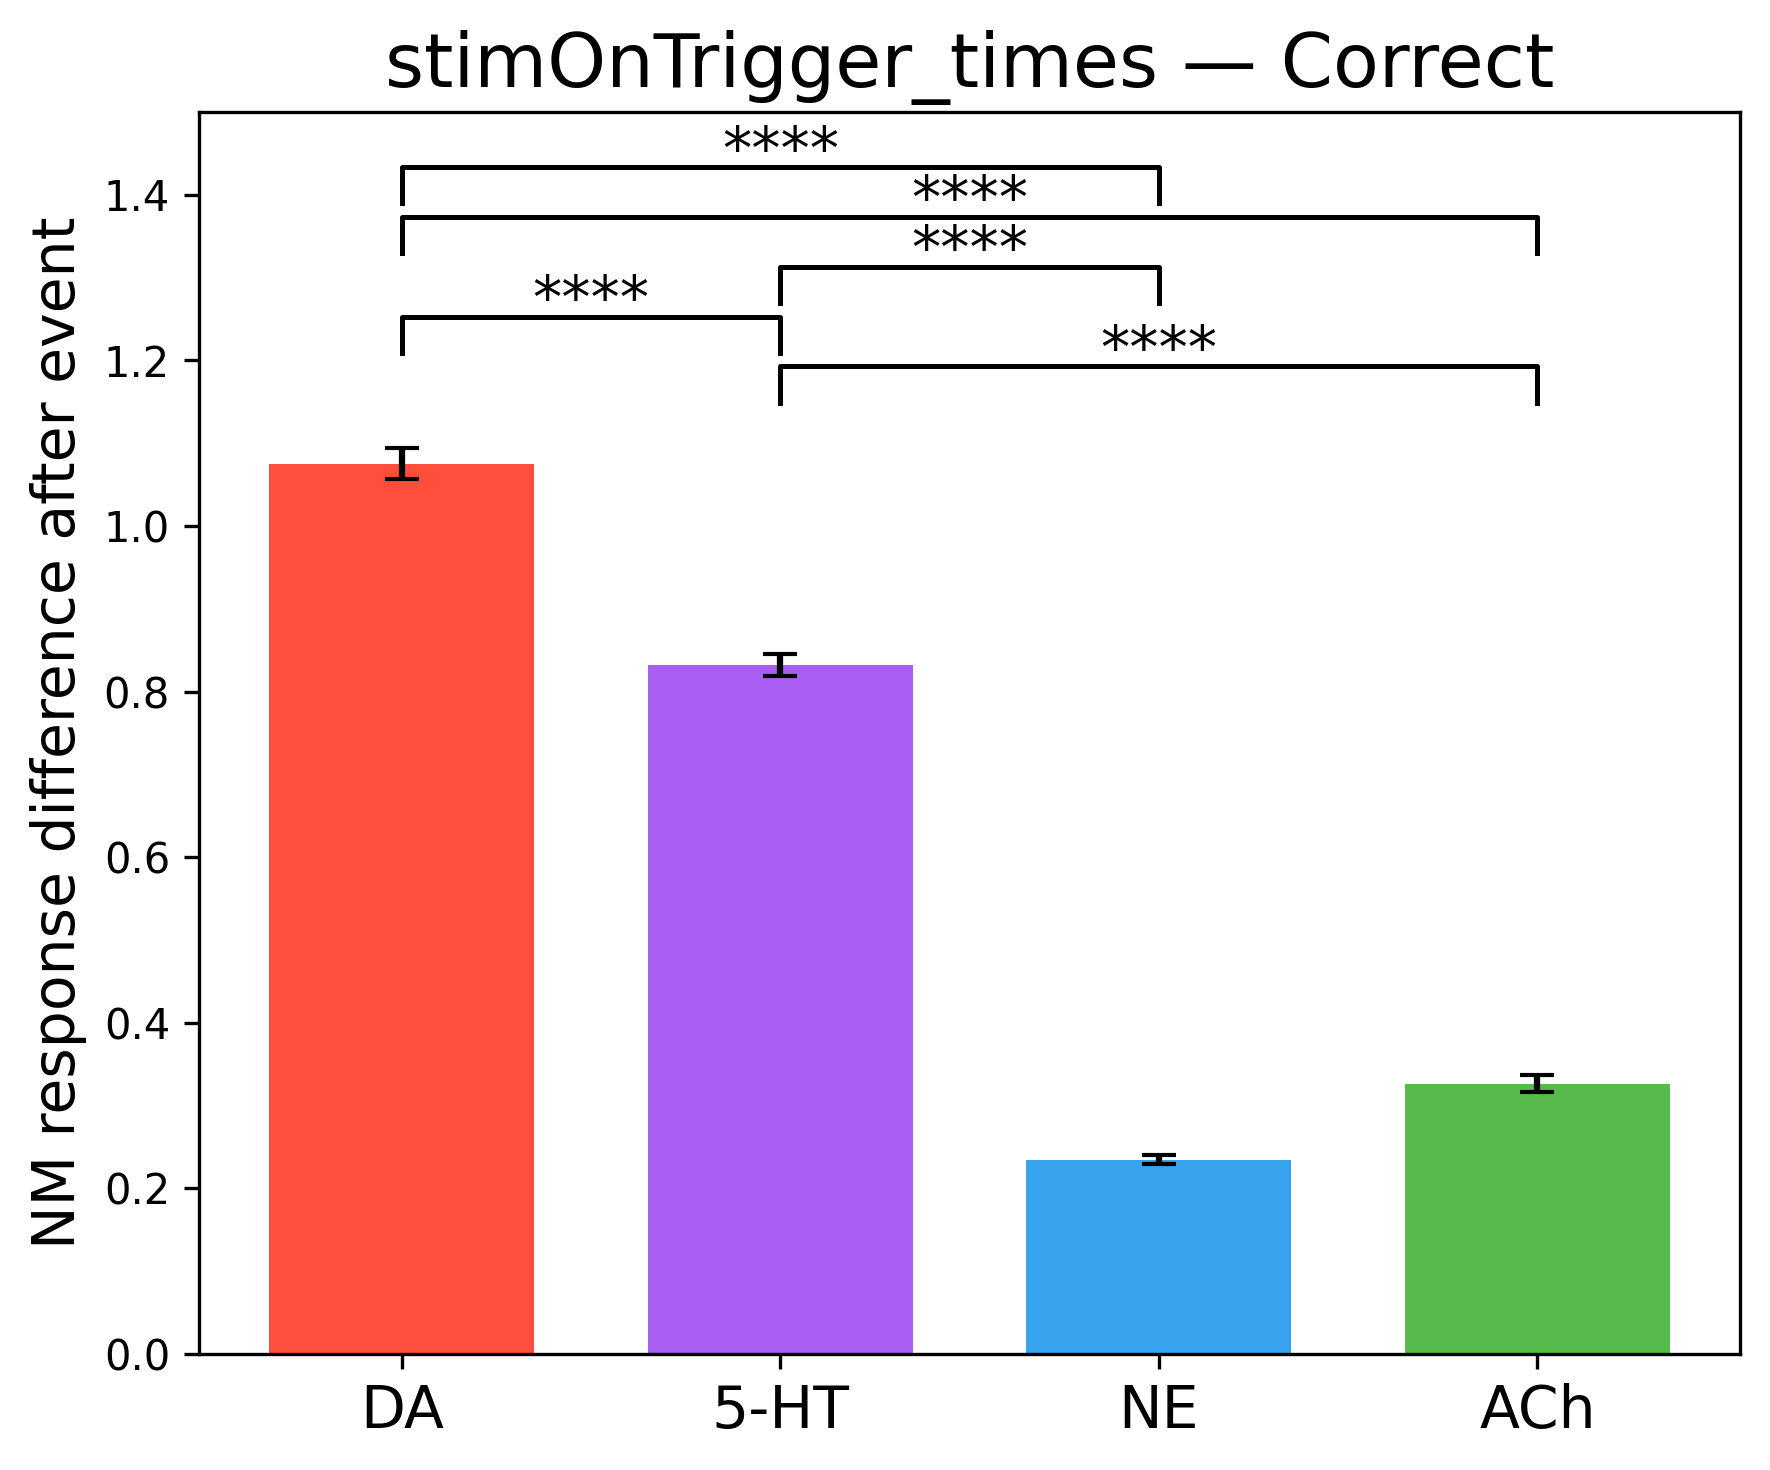

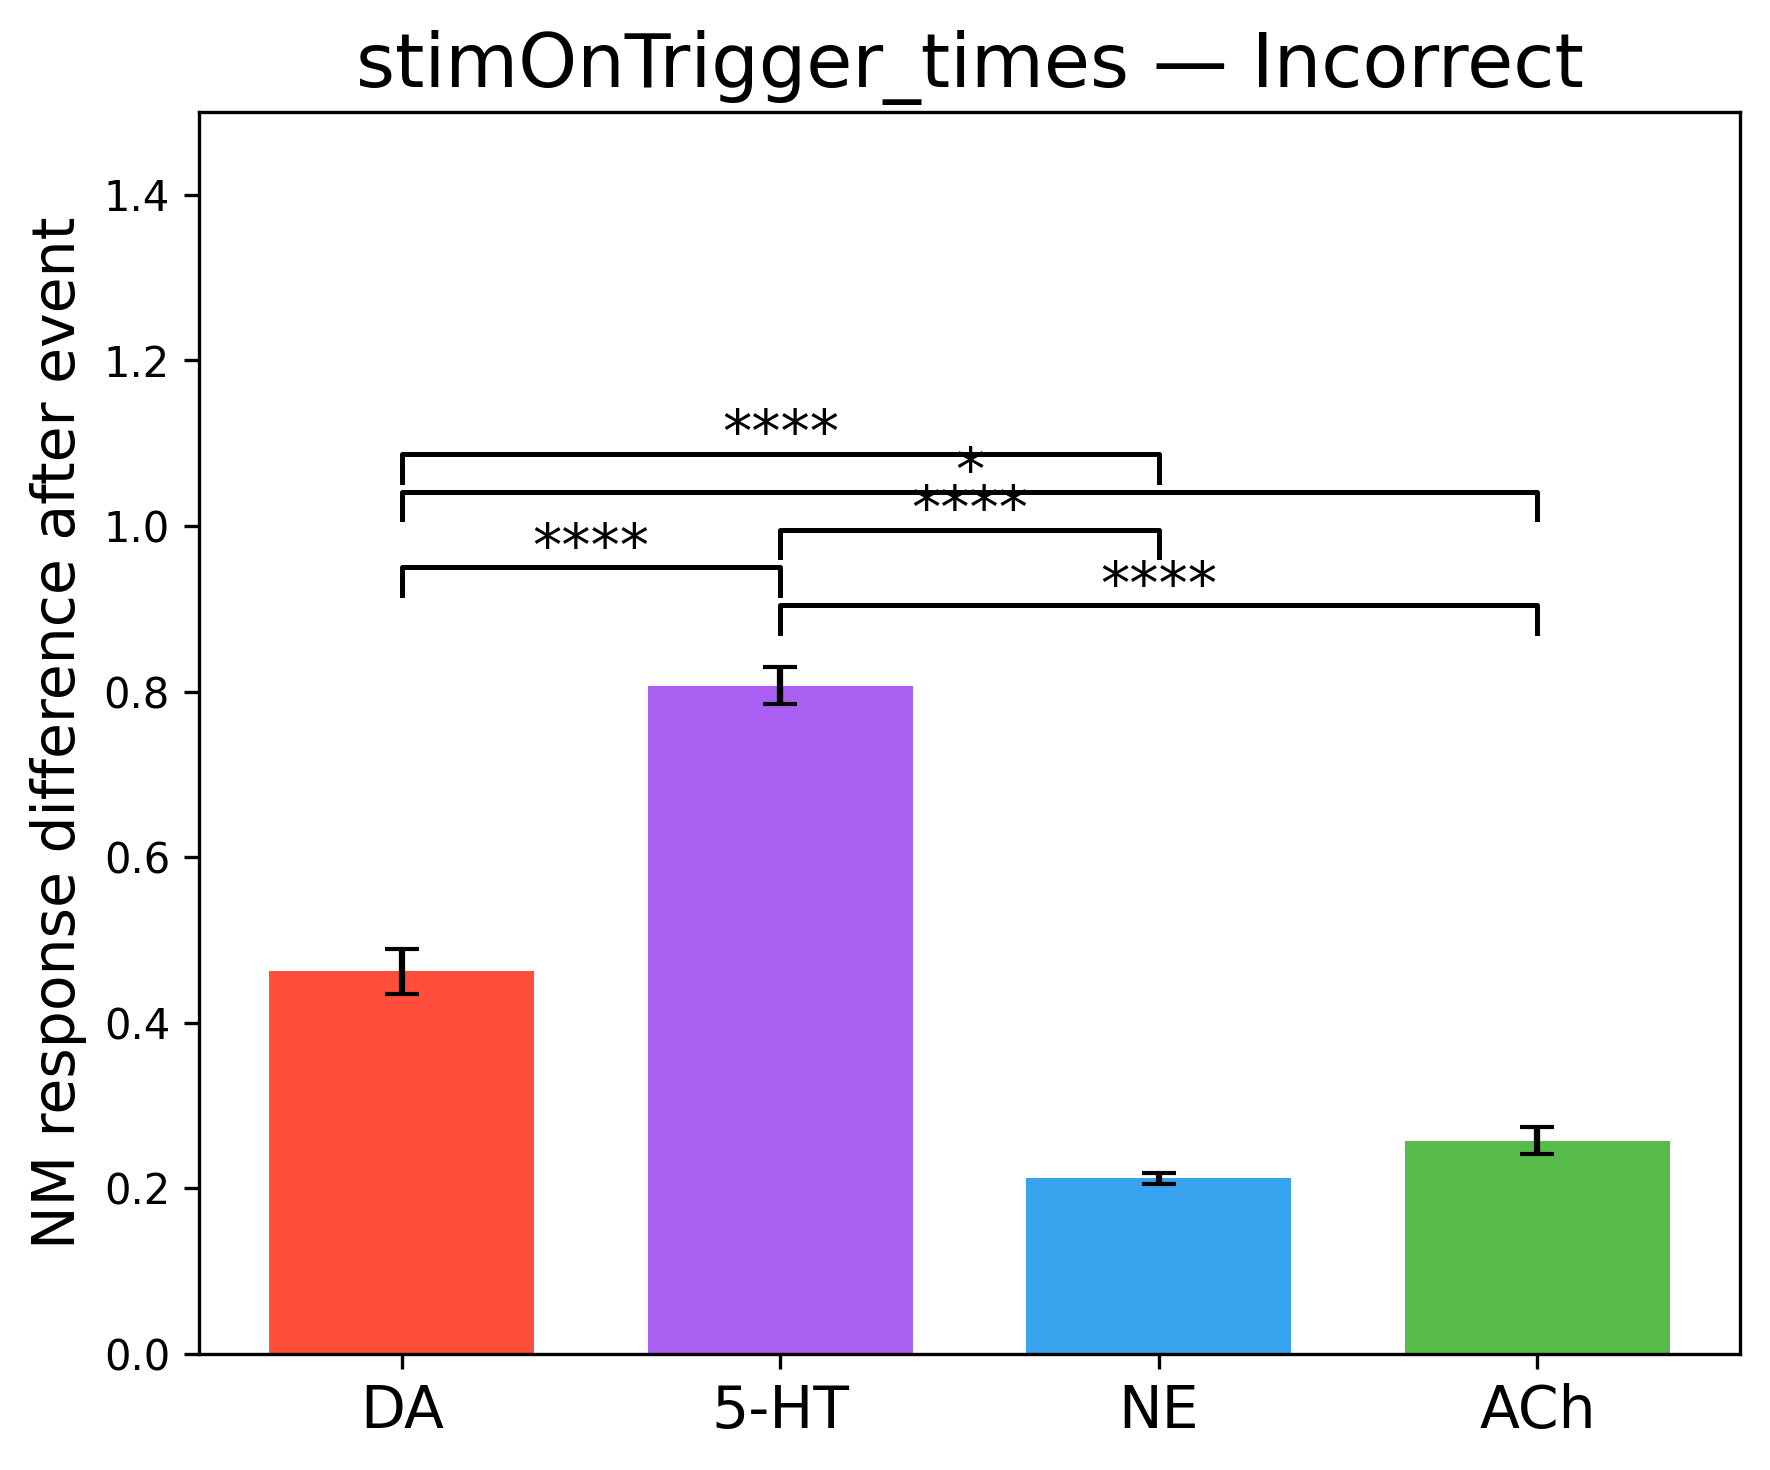

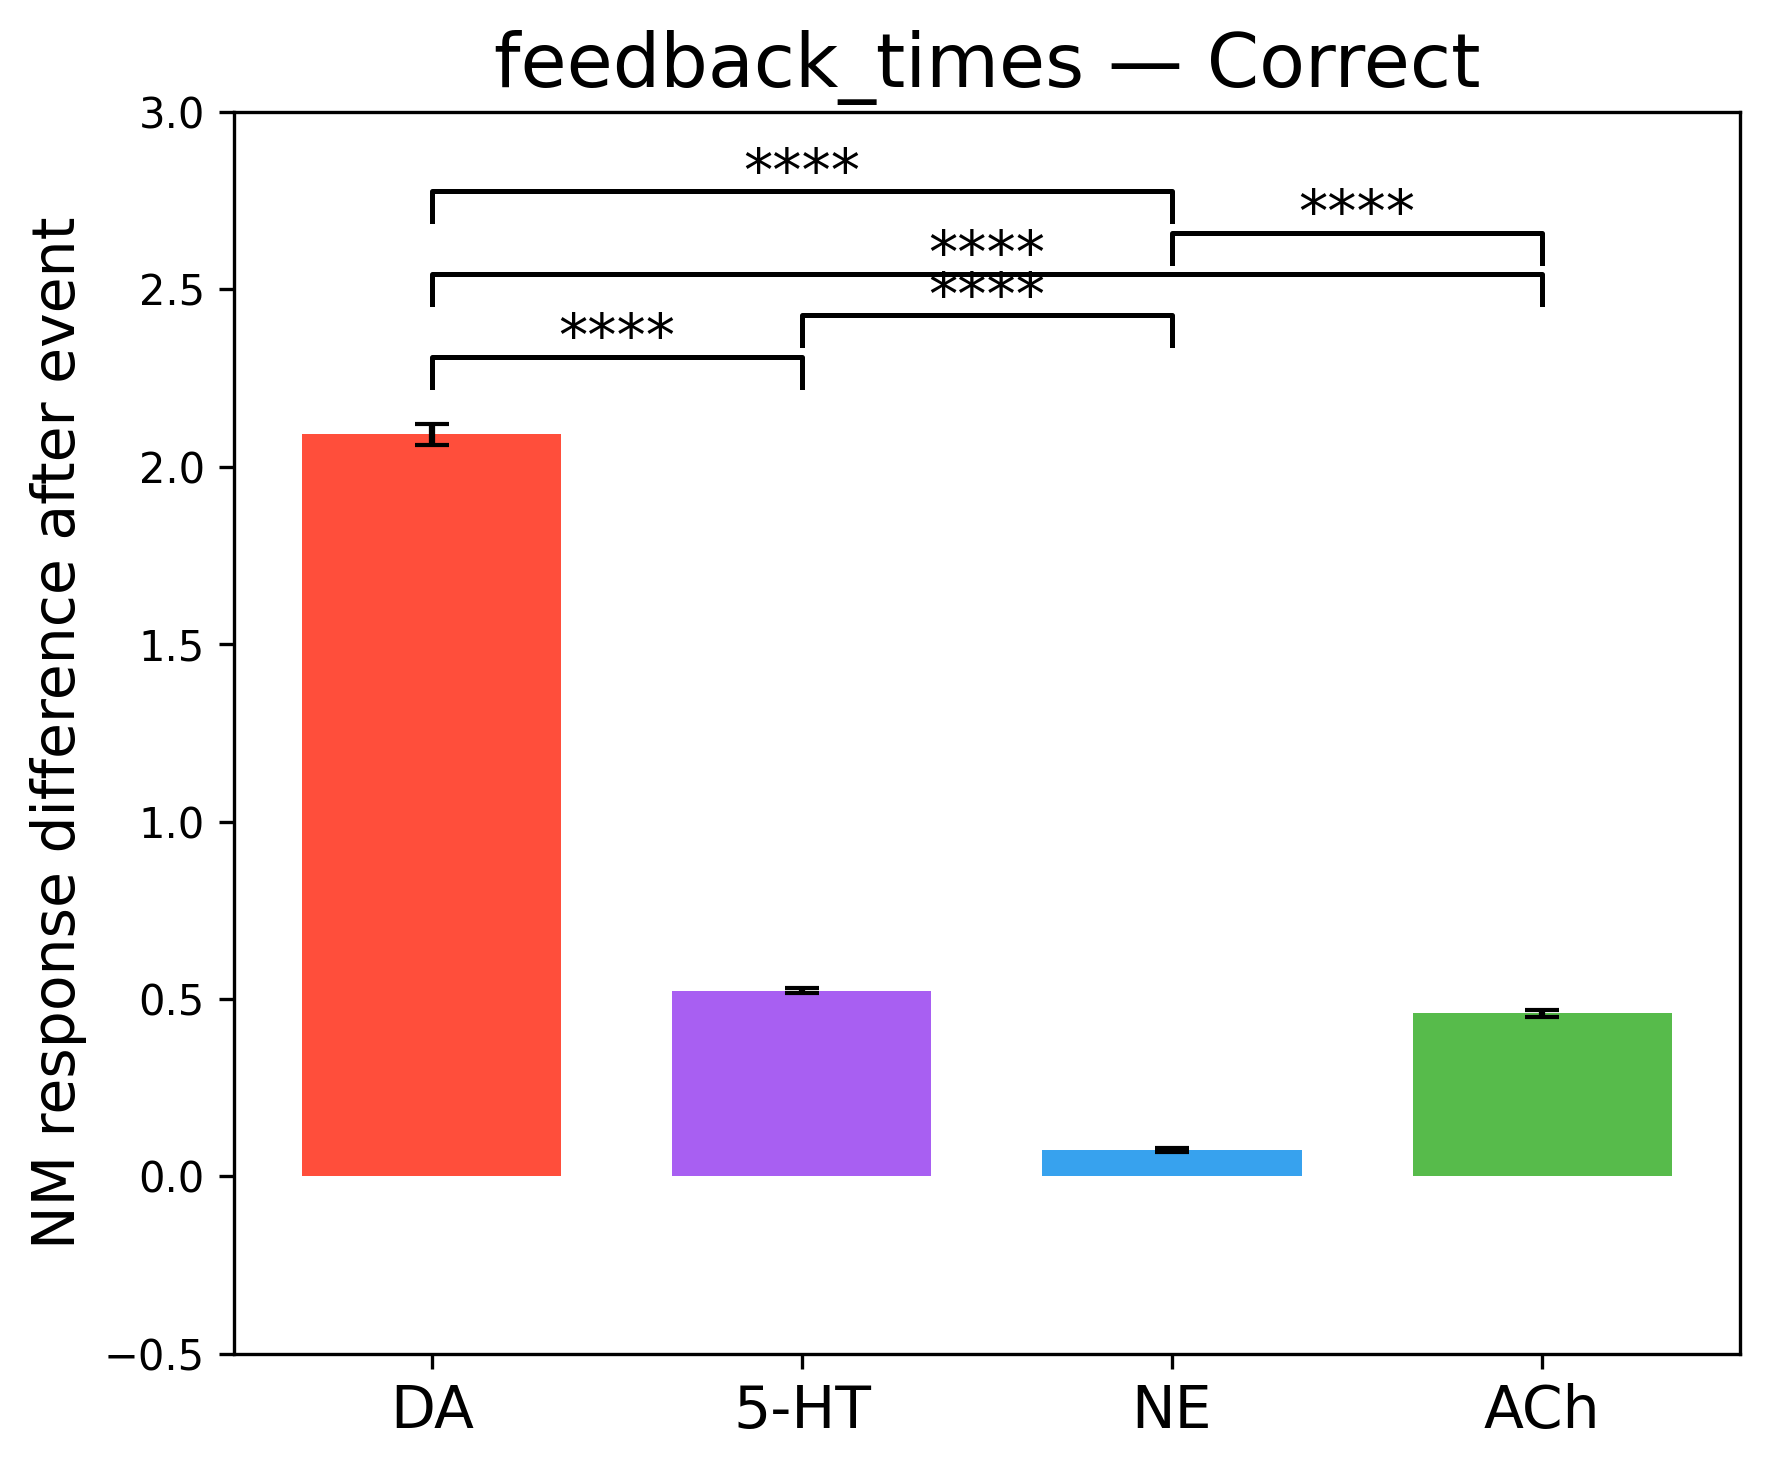

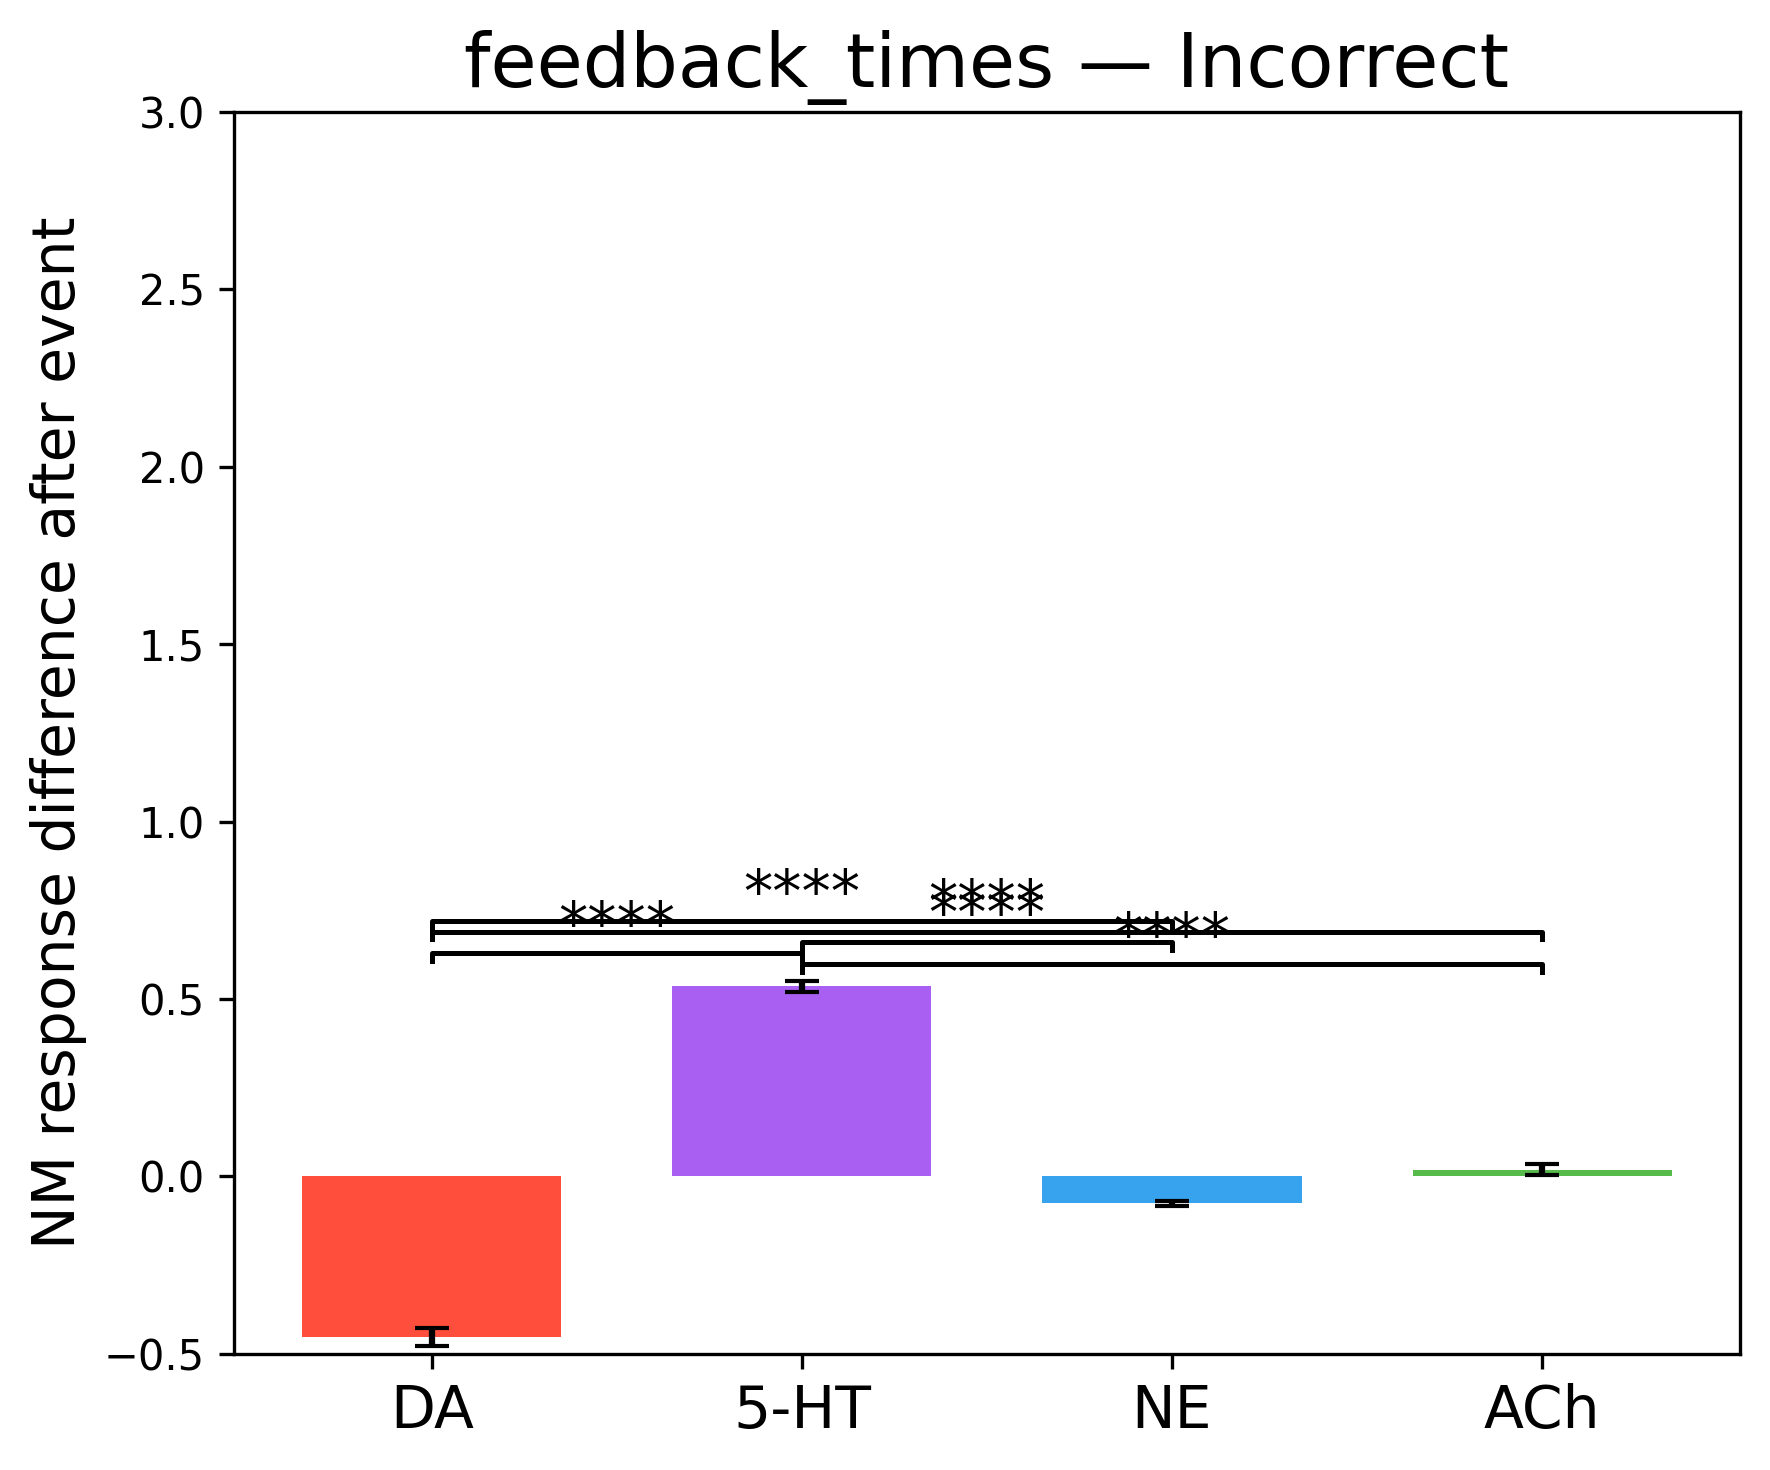

In [23]:
""" same but with ylim by event """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pingouin as pg

# ============================
# Helpers
# ============================
def pad_to_match_length(arr, target_length):
    current_length = arr.shape[0]
    if current_length == target_length:
        return arr
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(arr, ((0, padding), (0, 0)), mode='constant')
    else:
        return arr[:target_length, :]

def interpolate_to_common_time(psth, current_rate, target_rate, PERIEVENT_WINDOW):
    from scipy.interpolate import interp1d
    old_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], psth.shape[0])
    new_len = int((PERIEVENT_WINDOW[1] - PERIEVENT_WINDOW[0]) * target_rate) + 1
    new_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], new_len)
    interp = interp1d(old_time, psth, axis=0, kind='linear')
    return interp(new_time)

def p_to_stars(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# ============================
# Load Data
# ============================
def load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW):
    combined_psth = []
    combined_trials = []
    max_time_length = 0

    for mouse in group_mice:
        try:
            psth_path_30 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_30Hz.npy')
            psth_path_15 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_15Hz.npy')
            df_trials_path_30 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_30Hz.pqt')
            df_trials_path_15 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_15Hz.pqt')

            if os.path.exists(psth_path_30):
                psth = np.load(psth_path_30)
                df_trials = pd.read_parquet(df_trials_path_30)
            elif os.path.exists(psth_path_15):
                psth = np.load(psth_path_15)
                psth = interpolate_to_common_time(psth, 15, 30, PERIEVENT_WINDOW)
                df_trials = pd.read_parquet(df_trials_path_15)
            else:
                continue

            max_time_length = max(max_time_length, psth.shape[0])
            combined_psth.append(psth)
            combined_trials.append(df_trials)

        except Exception as e:
            print(f"Error loading {mouse} {event}: {e}")

    if combined_psth and combined_trials:
        combined_psth = [pad_to_match_length(psth, max_time_length) for psth in combined_psth]
        psth_combined = np.concatenate(combined_psth, axis=1)
        df_trials_combined = pd.concat(combined_trials, ignore_index=True)
        return psth_combined, df_trials_combined
    else:
        return None, None

# ============================
# Plotting function
# ============================
def plot_NM_barplot(df_values, event_label, feedback_label, color_palette, ylim=None):
    nms = df_values['group_name'].unique()
    means = df_values.groupby('group_name')['value'].mean().reindex(nms).values
    sems = df_values.groupby('group_name')['value'].sem().reindex(nms).values
    colors = [color_palette[nm] for nm in nms]

    x = np.arange(len(nms))
    bar_width = 0.7

    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    for i in range(len(x)):
        ax.bar(x[i], means[i], width=bar_width, yerr=sems[i], color=colors[i], alpha=0.9, capsize=4)

    # ANOVA + Tukey
    aov = pg.anova(data=df_values, dv='value', between='group_name', detailed=True)
    posthoc = pg.pairwise_tukey(data=df_values, dv='value', between='group_name')

    y_max = np.max(means + sems)
    y_offset = y_max * 0.05
    current_y = y_max + y_offset
    label_to_x = {label: xi for label, xi in zip(nms, x)}

    for _, row in posthoc.iterrows():
        if row['p-tukey'] < 0.05:
            i1, i2 = label_to_x[row['A']], label_to_x[row['B']]
            x1, x2 = min(i1, i2), max(i1, i2)
            ax.plot([x1, x1, x2, x2],
                    [current_y, current_y + y_offset * 0.8, current_y + y_offset * 0.8, current_y],
                    lw=1.2, c='black')
            ax.text((x1 + x2) / 2, current_y + y_offset * 0.5, p_to_stars(row['p-tukey']),
                    ha='center', va='bottom', fontsize=14)
            current_y += y_offset * 1.1

    ax.set_xticks(x)
    ax.set_xticklabels(nms, fontsize=14)
    ax.set_ylabel("NM response difference after event", fontsize=14)
    ax.set_title(f"{event_label} — {feedback_label}", fontsize=18)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()

    filename_base = f"/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/barplot_{event_label}_{feedback_label}_final"
    plt.savefig(filename_base + ".png", dpi=300, bbox_inches='tight')
    plt.savefig(filename_base + ".pdf", dpi=300, bbox_inches='tight')
    plt.show()

# ============================
# Main Analysis
# ============================
groups = {
    "DA": ["ZFM-03447", "ZFM-04026", "ZFM-04022_R", "ZFM-03448", "ZFM-04019", "ZFM-04022_L"],
    "5-HT": ["ZFM-03059", "ZFM-03065", "ZFM-03061", "ZFM-03062", "ZFM-04392_DRN", "ZFM-05235", "ZFM-05236", "ZFM-05245", "ZFM-05248"],
    "NE": ["ZFM-04533", "ZFM-04534_LC", "ZFM-06268", "ZFM-06271", "ZFM-06272_L", "ZFM-06272_R", "ZFM-06171", "ZFM-06275_L", "ZFM-06275_R"],
    "ACh": ["ZFM-06305_L", "ZFM-06948"]
}
color_palette = {
    "DA": "#FF3B25",
    "5-HT": "#9F4DF1",
    "NE": "#2198ED",
    "ACh": "#45B437"
}

path_to_data = "/home/kceniabougrova/Documents/NM_project_fromIBLserver/Good_sessions"
time_vector = np.linspace(-1, 2, 91)
baseline_idx = np.where((time_vector >= -0.2) & (time_vector < 0))[0]
response_idx = np.where((time_vector >= 0) & (time_vector < 0.5))[0]
PERIEVENT_WINDOW = [-1, 2]

events = ['stimOnTrigger_times', 'feedback_times']
feedback_types = {'Correct': 1, 'Incorrect': -1}

for event in events:
    # Pick ylim depending on event
    if event == 'stimOnTrigger_times':
        custom_ylim = (0, 1.5)
    elif event == 'feedback_times':
        custom_ylim = (-0.5, 3)
    else:
        custom_ylim = None

    for fb_label, fb_code in feedback_types.items():
        all_data = []
        for group_name, group_mice in groups.items():
            psth_combined, df_trials_combined = load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW)
            if psth_combined is None:
                continue
            if psth_combined.shape[0] == 91:
                psth_combined = psth_combined.T

            idx = df_trials_combined['feedbackType'].values == fb_code
            psth_subset = psth_combined[idx]
            if psth_subset.shape[0] < 5:
                continue

            baseline = np.mean(psth_subset[:, baseline_idx], axis=1, keepdims=True)
            baseline_std = np.std(psth_subset[:, baseline_idx], axis=1, keepdims=True)
            aligned = psth_subset - baseline
            normalized = aligned / (np.abs(baseline_std) + 1e-6)
            response = np.mean(normalized[:, response_idx], axis=1)

            for val in response:
                all_data.append({'value': val, 'group_name': group_name})

        df_values = pd.DataFrame(all_data)
        if df_values.empty:
            print(f"No data for {event} {fb_label}")
            continue
        plot_NM_barplot(df_values, event, fb_label, color_palette, ylim=custom_ylim)


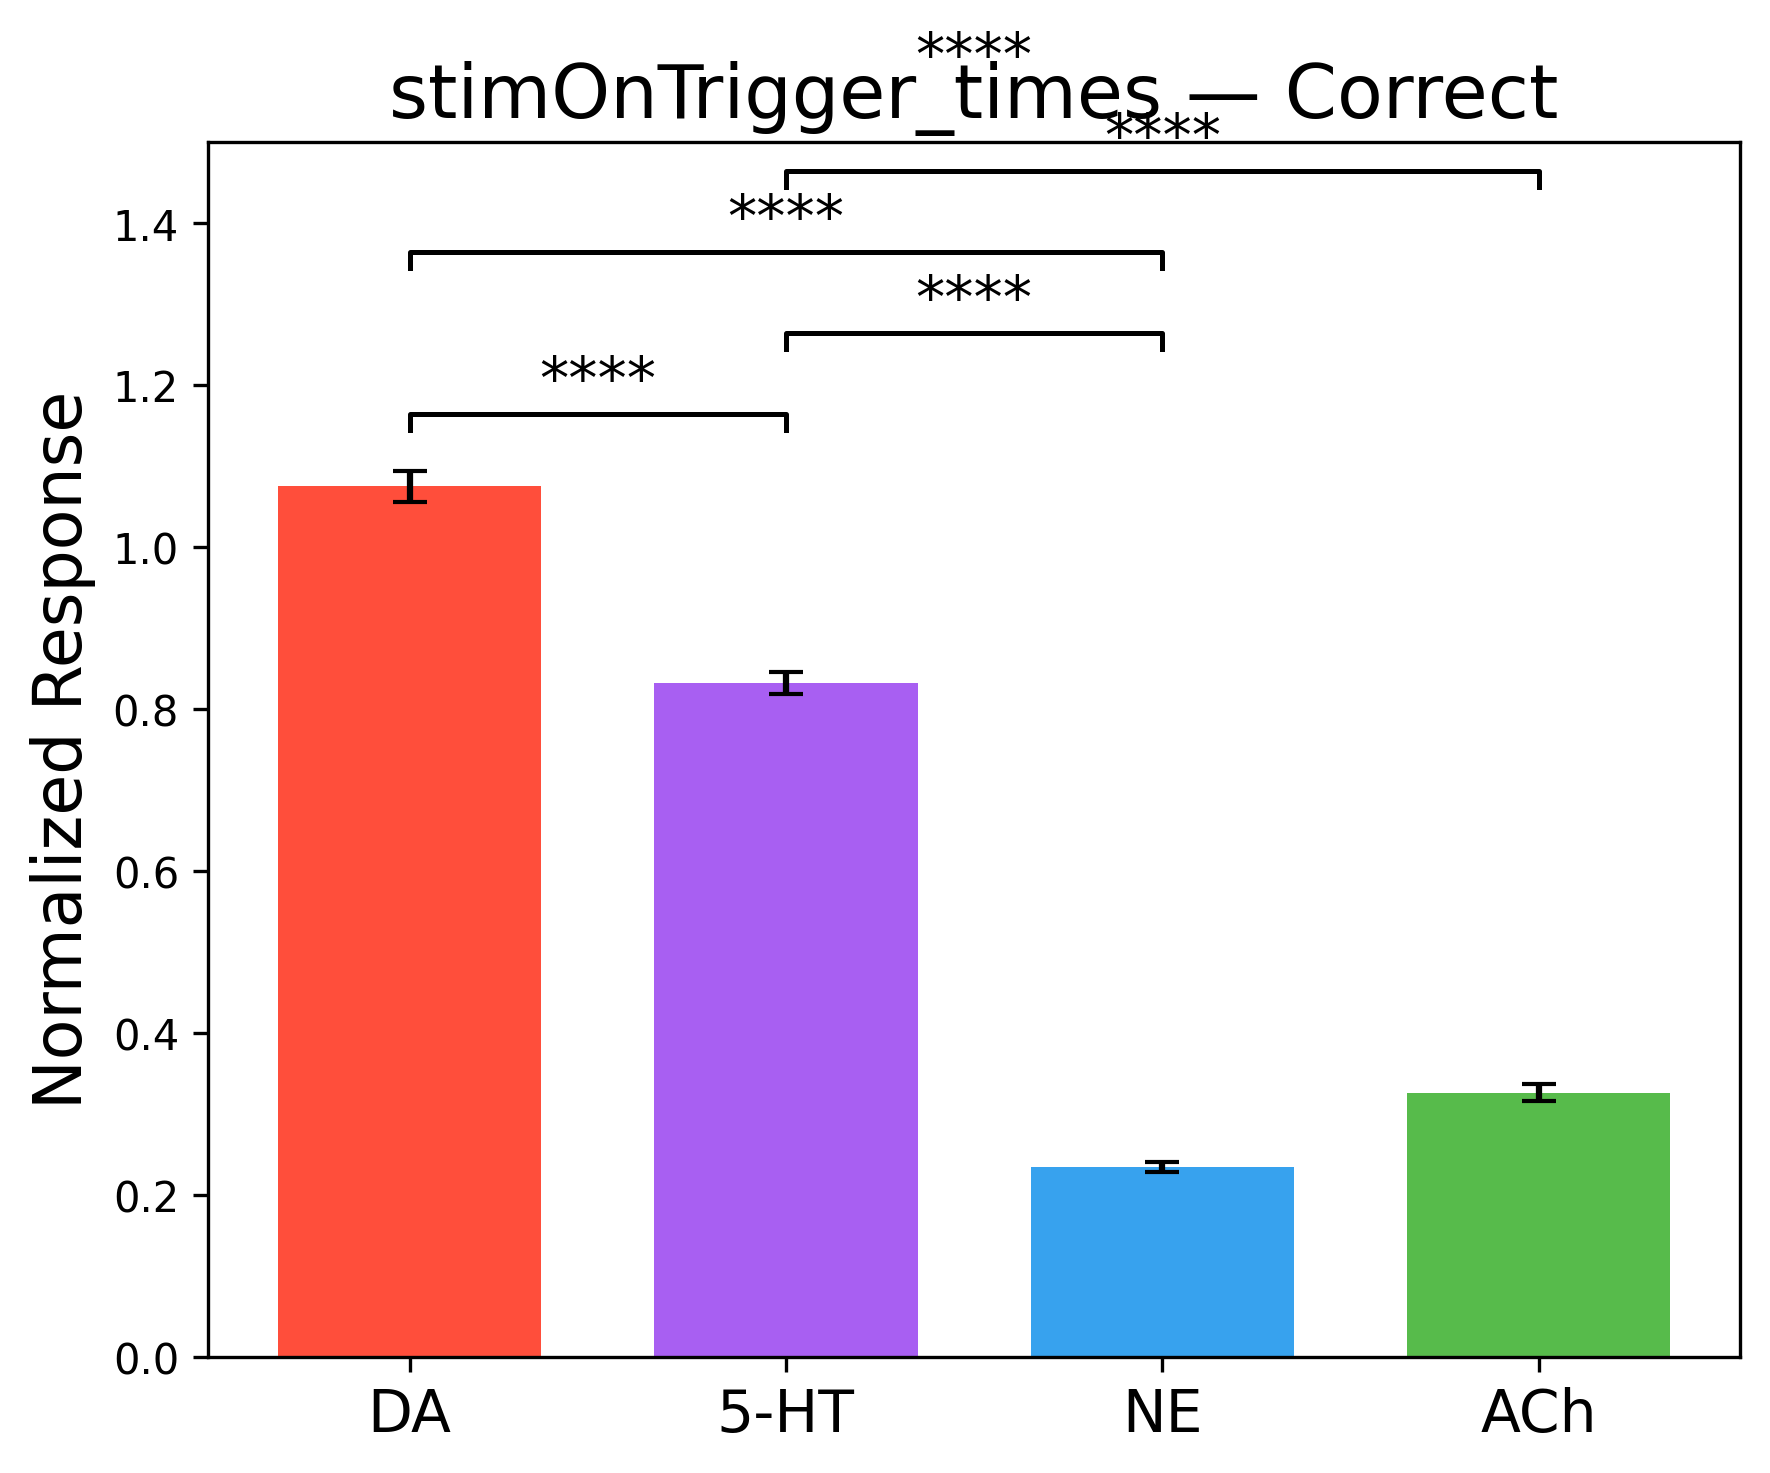

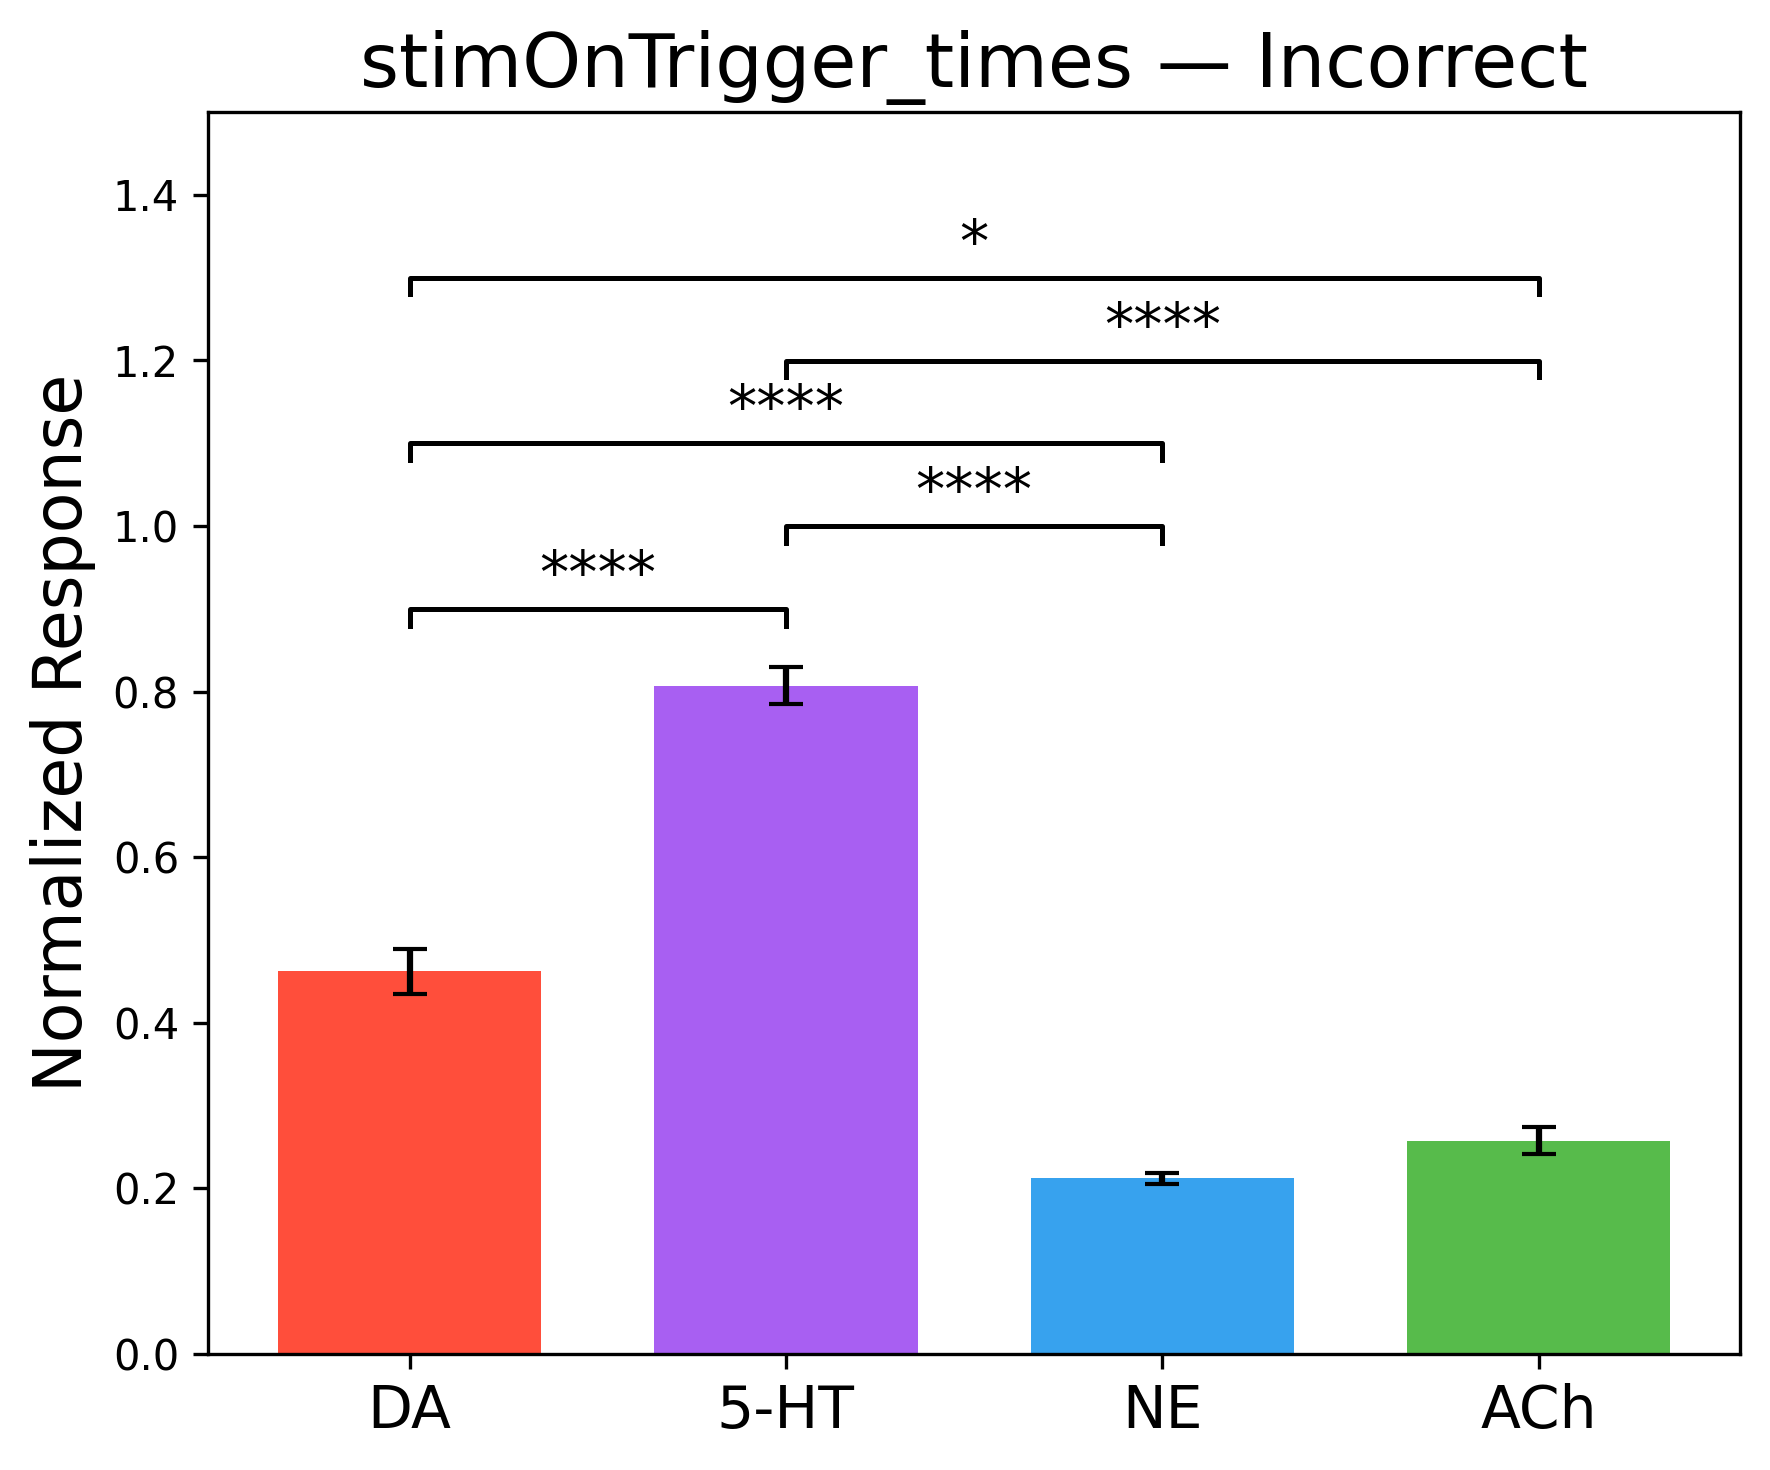

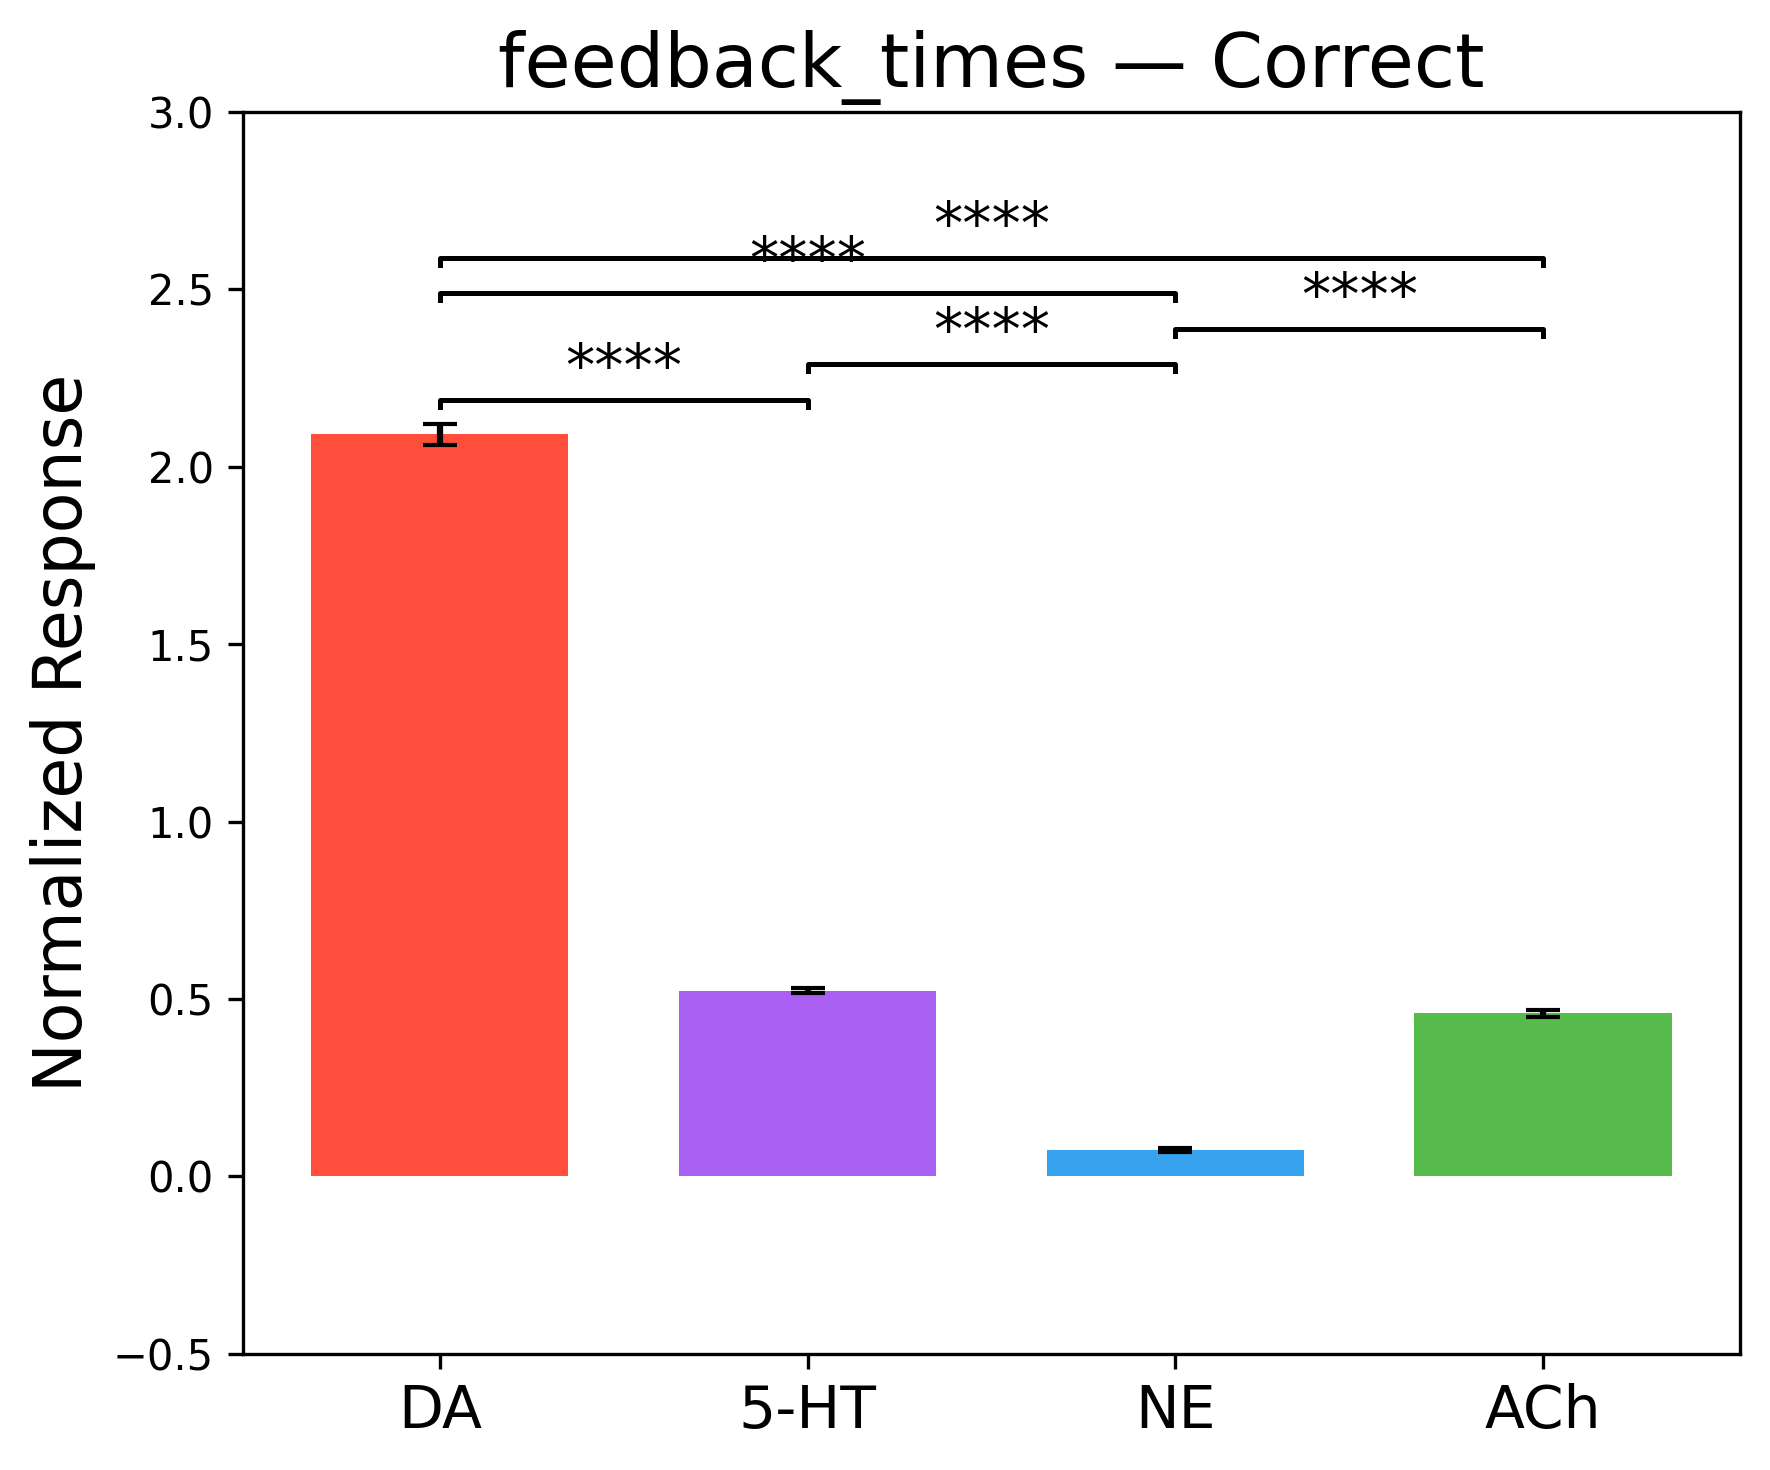

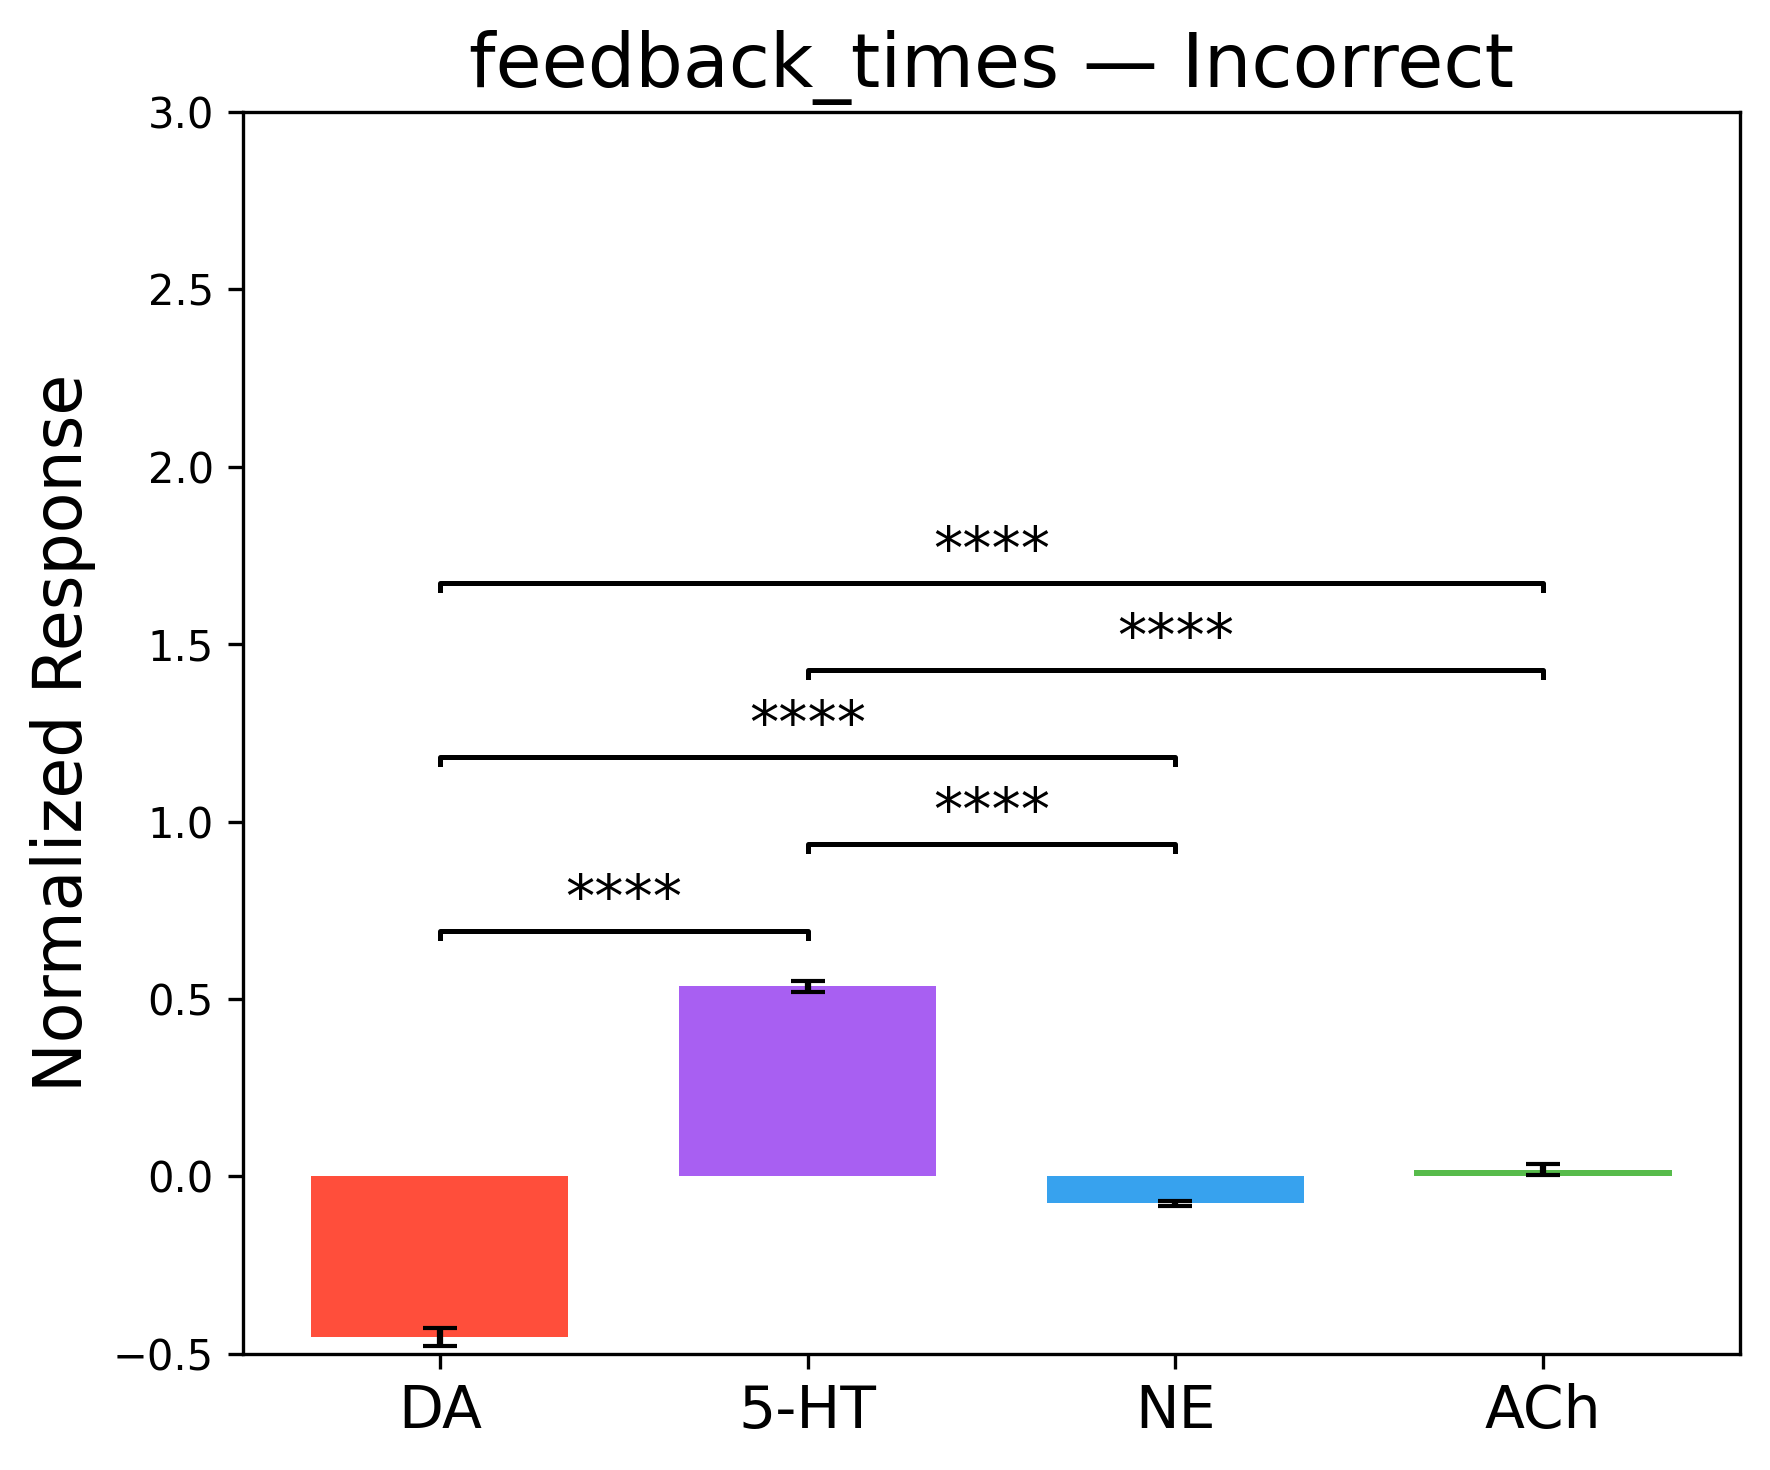

In [19]:
""" same as above but with * and [ adjusted """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pingouin as pg

# ============================
# Helpers
# ============================
def pad_to_match_length(arr, target_length):
    current_length = arr.shape[0]
    if current_length == target_length:
        return arr
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(arr, ((0, padding), (0, 0)), mode='constant')
    else:
        return arr[:target_length, :]

def interpolate_to_common_time(psth, current_rate, target_rate, PERIEVENT_WINDOW):
    from scipy.interpolate import interp1d
    old_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], psth.shape[0])
    new_len = int((PERIEVENT_WINDOW[1] - PERIEVENT_WINDOW[0]) * target_rate) + 1
    new_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], new_len)
    interp = interp1d(old_time, psth, axis=0, kind='linear')
    return interp(new_time)

def p_to_stars(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# ============================
# Load Data
# ============================
def load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW):
    combined_psth = []
    combined_trials = []
    max_time_length = 0

    for mouse in group_mice:
        try:
            psth_path_30 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_30Hz.npy')
            psth_path_15 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_15Hz.npy')
            df_trials_path_30 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_30Hz.pqt')
            df_trials_path_15 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_15Hz.pqt')

            if os.path.exists(psth_path_30):
                psth = np.load(psth_path_30)
                df_trials = pd.read_parquet(df_trials_path_30)
            elif os.path.exists(psth_path_15):
                psth = np.load(psth_path_15)
                psth = interpolate_to_common_time(psth, 15, 30, PERIEVENT_WINDOW)
                df_trials = pd.read_parquet(df_trials_path_15)
            else:
                continue

            max_time_length = max(max_time_length, psth.shape[0])
            combined_psth.append(psth)
            combined_trials.append(df_trials)

        except Exception as e:
            print(f"Error loading {mouse} {event}: {e}")

    if combined_psth and combined_trials:
        combined_psth = [pad_to_match_length(psth, max_time_length) for psth in combined_psth]
        psth_combined = np.concatenate(combined_psth, axis=1)
        df_trials_combined = pd.concat(combined_trials, ignore_index=True)
        return psth_combined, df_trials_combined
    else:
        return None, None

# ============================
# Plotting function
# ============================
""" same as previous code, but checking the * and [ space """
def plot_NM_barplot(df_values, event_label, feedback_label, color_palette, ylim=None):
    nms = df_values['group_name'].unique()
    means = df_values.groupby('group_name')['value'].mean().reindex(nms).values
    sems = df_values.groupby('group_name')['value'].sem().reindex(nms).values
    colors = [color_palette[nm] for nm in nms]

    x = np.arange(len(nms))
    bar_width = 0.7

    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    for i in range(len(x)):
        ax.bar(x[i], means[i], width=bar_width, yerr=sems[i], color=colors[i], alpha=0.9, capsize=4)

    # ANOVA + Tukey
    aov = pg.anova(data=df_values, dv='value', between='group_name', detailed=True)
    posthoc = pg.pairwise_tukey(data=df_values, dv='value', between='group_name')

    y_max = np.max(means + sems)
    if ylim:
        y_top = ylim[1]
    else:
        y_top = y_max * 1.3

    # Define spacing
    base_offset = (y_top - y_max) * 0.05
    if base_offset < 0.05:
        base_offset = 0.05

    # Start just above bars
    current_y = y_max + base_offset

    # Sort comparisons by span width to avoid overlaps
    comparisons = []
    label_to_x = {label: xi for label, xi in zip(nms, x)}
    for _, row in posthoc.iterrows():
        if row['p-tukey'] < 0.05:
            i1, i2 = label_to_x[row['A']], label_to_x[row['B']]
            comparisons.append((abs(i2 - i1), i1, i2, p_to_stars(row['p-tukey'])))
    comparisons.sort()

    # Draw each comparison higher than the last
    for _, i1, i2, stars in comparisons:
        x1, x2 = min(i1, i2), max(i1, i2)
        # Line
        ax.plot(
            [x1, x1, x2, x2],
            [current_y, current_y + 0.02, current_y + 0.02, current_y],
            lw=1.2, c='black'
        )
        # Stars
        ax.text(
            (x1 + x2) / 2,
            current_y + 0.025,
            stars,
            ha='center',
            va='bottom',
            fontsize=14
        )
        # Increment for next comparison
        current_y += base_offset * 2.0

    ax.set_xticks(x)
    ax.set_xticklabels(nms, fontsize=14)
    ax.set_ylabel("Normalized Response", fontsize=16)
    ax.set_title(f"{event_label} — {feedback_label}", fontsize=18)
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim(top=current_y + base_offset)
    plt.tight_layout()

    filename_base = f"/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/barplot_{event_label}_{feedback_label}_final"
    plt.savefig(filename_base + ".png", dpi=300, bbox_inches='tight')
    plt.savefig(filename_base + ".pdf", dpi=300, bbox_inches='tight')
    plt.show()




# ============================
# Main Analysis
# ============================
groups = {
    "DA": ["ZFM-03447", "ZFM-04026", "ZFM-04022_R", "ZFM-03448", "ZFM-04019", "ZFM-04022_L"],
    "5-HT": ["ZFM-03059", "ZFM-03065", "ZFM-03061", "ZFM-03062", "ZFM-04392_DRN", "ZFM-05235", "ZFM-05236", "ZFM-05245", "ZFM-05248"],
    "NE": ["ZFM-04533", "ZFM-04534_LC", "ZFM-06268", "ZFM-06271", "ZFM-06272_L", "ZFM-06272_R", "ZFM-06171", "ZFM-06275_L", "ZFM-06275_R"],
    "ACh": ["ZFM-06305_L", "ZFM-06948"]
}
color_palette = {
    "DA": "#FF3B25",
    "5-HT": "#9F4DF1",
    "NE": "#2198ED",
    "ACh": "#45B437"
}

path_to_data = "/home/kceniabougrova/Documents/NM_project_fromIBLserver/Good_sessions"
time_vector = np.linspace(-1, 2, 91)
baseline_idx = np.where((time_vector >= -0.2) & (time_vector < 0))[0]
response_idx = np.where((time_vector >= 0) & (time_vector < 0.5))[0]
PERIEVENT_WINDOW = [-1, 2]

events = ['stimOnTrigger_times', 'feedback_times']
feedback_types = {'Correct': 1, 'Incorrect': -1}

for event in events:
    # Pick ylim depending on event
    if event == 'stimOnTrigger_times':
        custom_ylim = (0, 1.5)
    elif event == 'feedback_times':
        custom_ylim = (-0.5, 3)
    else:
        custom_ylim = None

    for fb_label, fb_code in feedback_types.items():
        all_data = []
        for group_name, group_mice in groups.items():
            psth_combined, df_trials_combined = load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW)
            if psth_combined is None:
                continue
            if psth_combined.shape[0] == 91:
                psth_combined = psth_combined.T

            idx = df_trials_combined['feedbackType'].values == fb_code
            psth_subset = psth_combined[idx]
            if psth_subset.shape[0] < 5:
                continue

            baseline = np.mean(psth_subset[:, baseline_idx], axis=1, keepdims=True)
            baseline_std = np.std(psth_subset[:, baseline_idx], axis=1, keepdims=True)
            aligned = psth_subset - baseline
            normalized = aligned / (np.abs(baseline_std) + 1e-6)
            response = np.mean(normalized[:, response_idx], axis=1)

            for val in response:
                all_data.append({'value': val, 'group_name': group_name})

        df_values = pd.DataFrame(all_data)
        if df_values.empty:
            print(f"No data for {event} {fb_label}")
            continue
        plot_NM_barplot(df_values, event, fb_label, color_palette, ylim=custom_ylim)


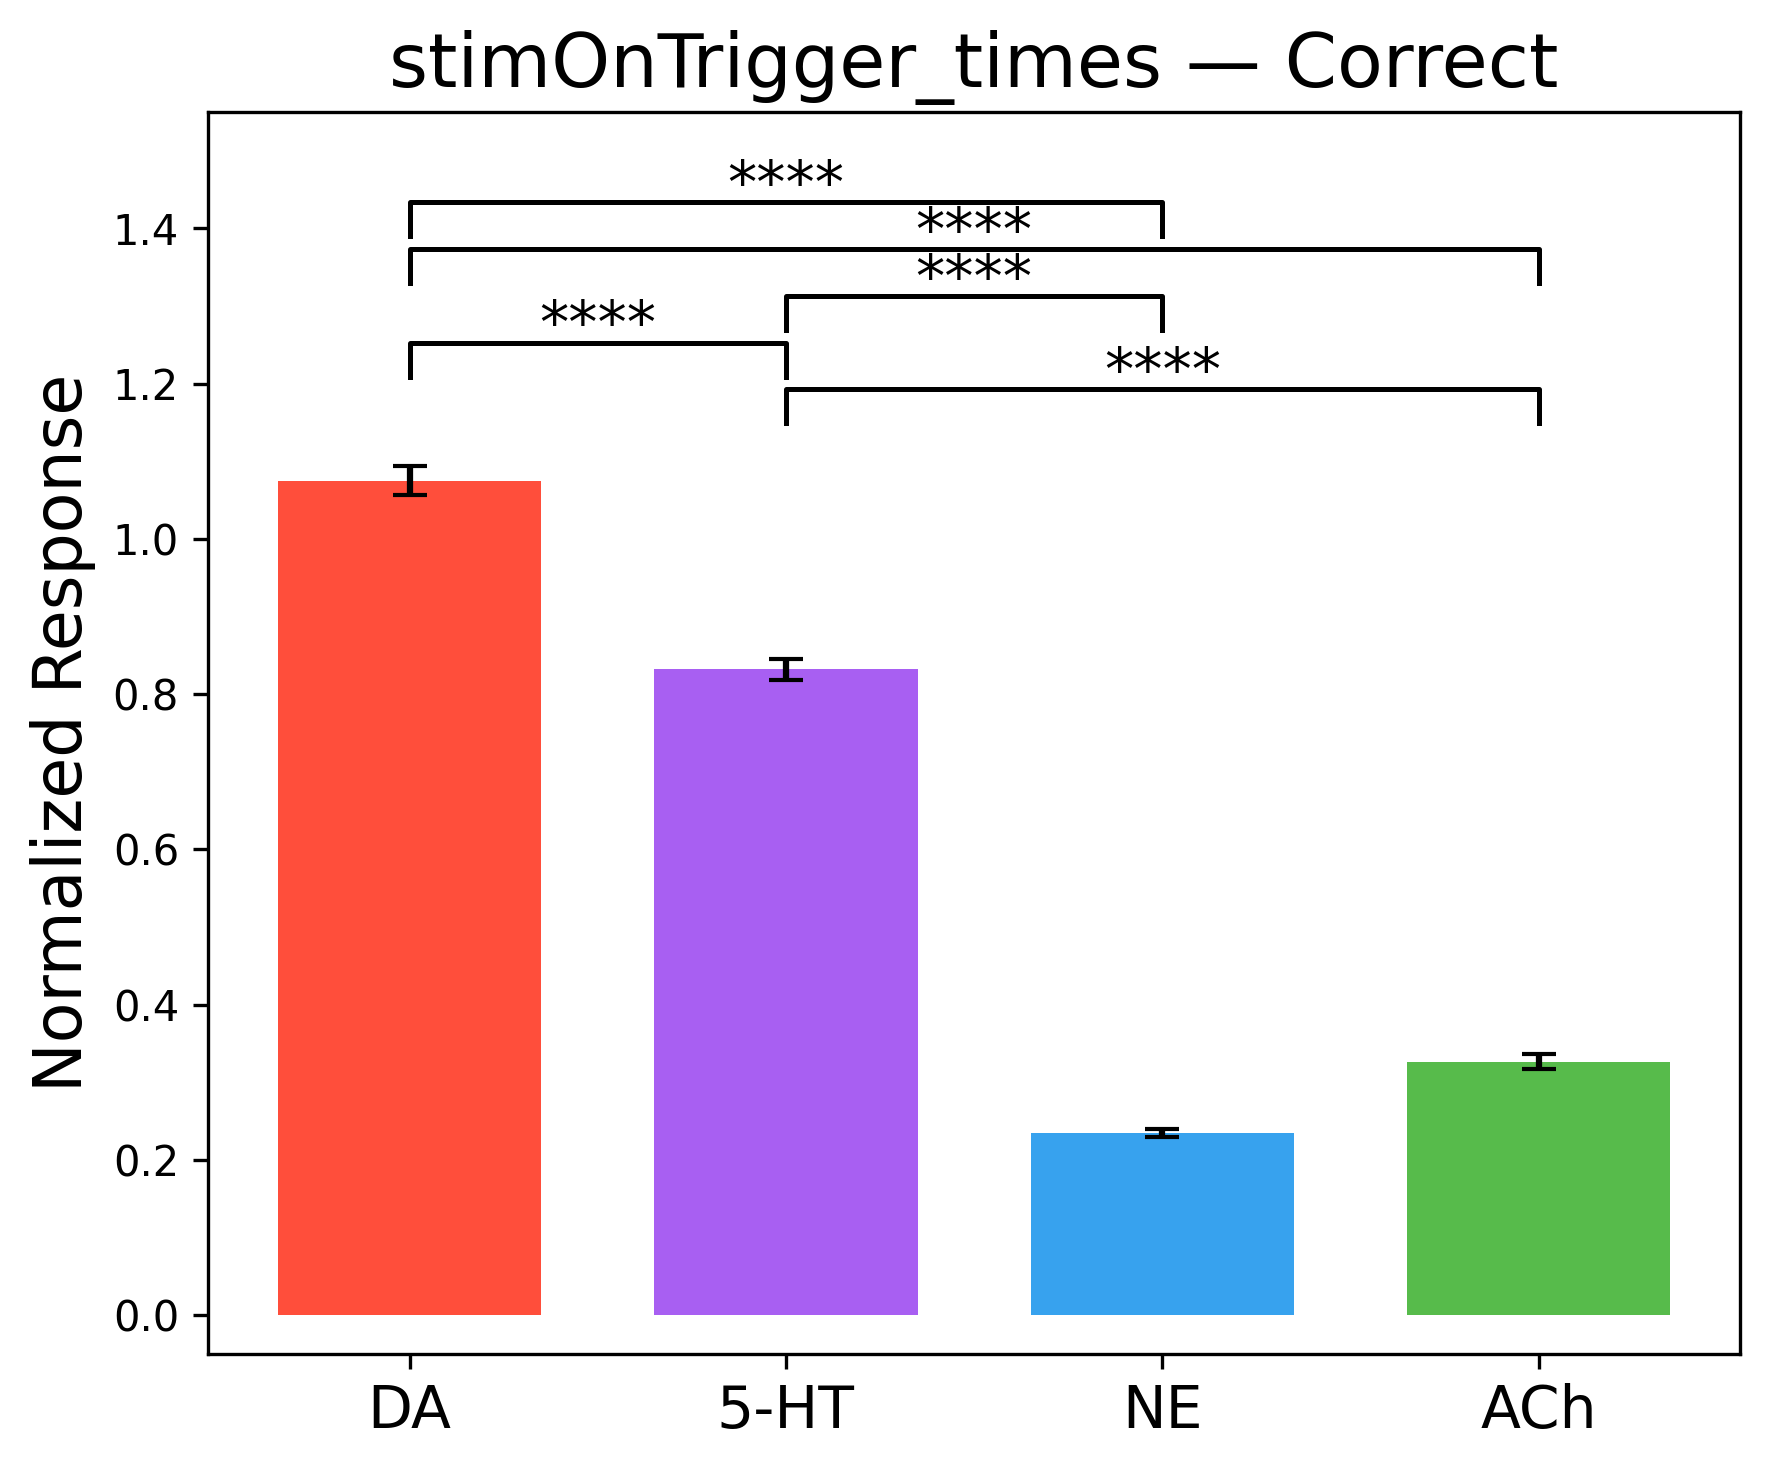

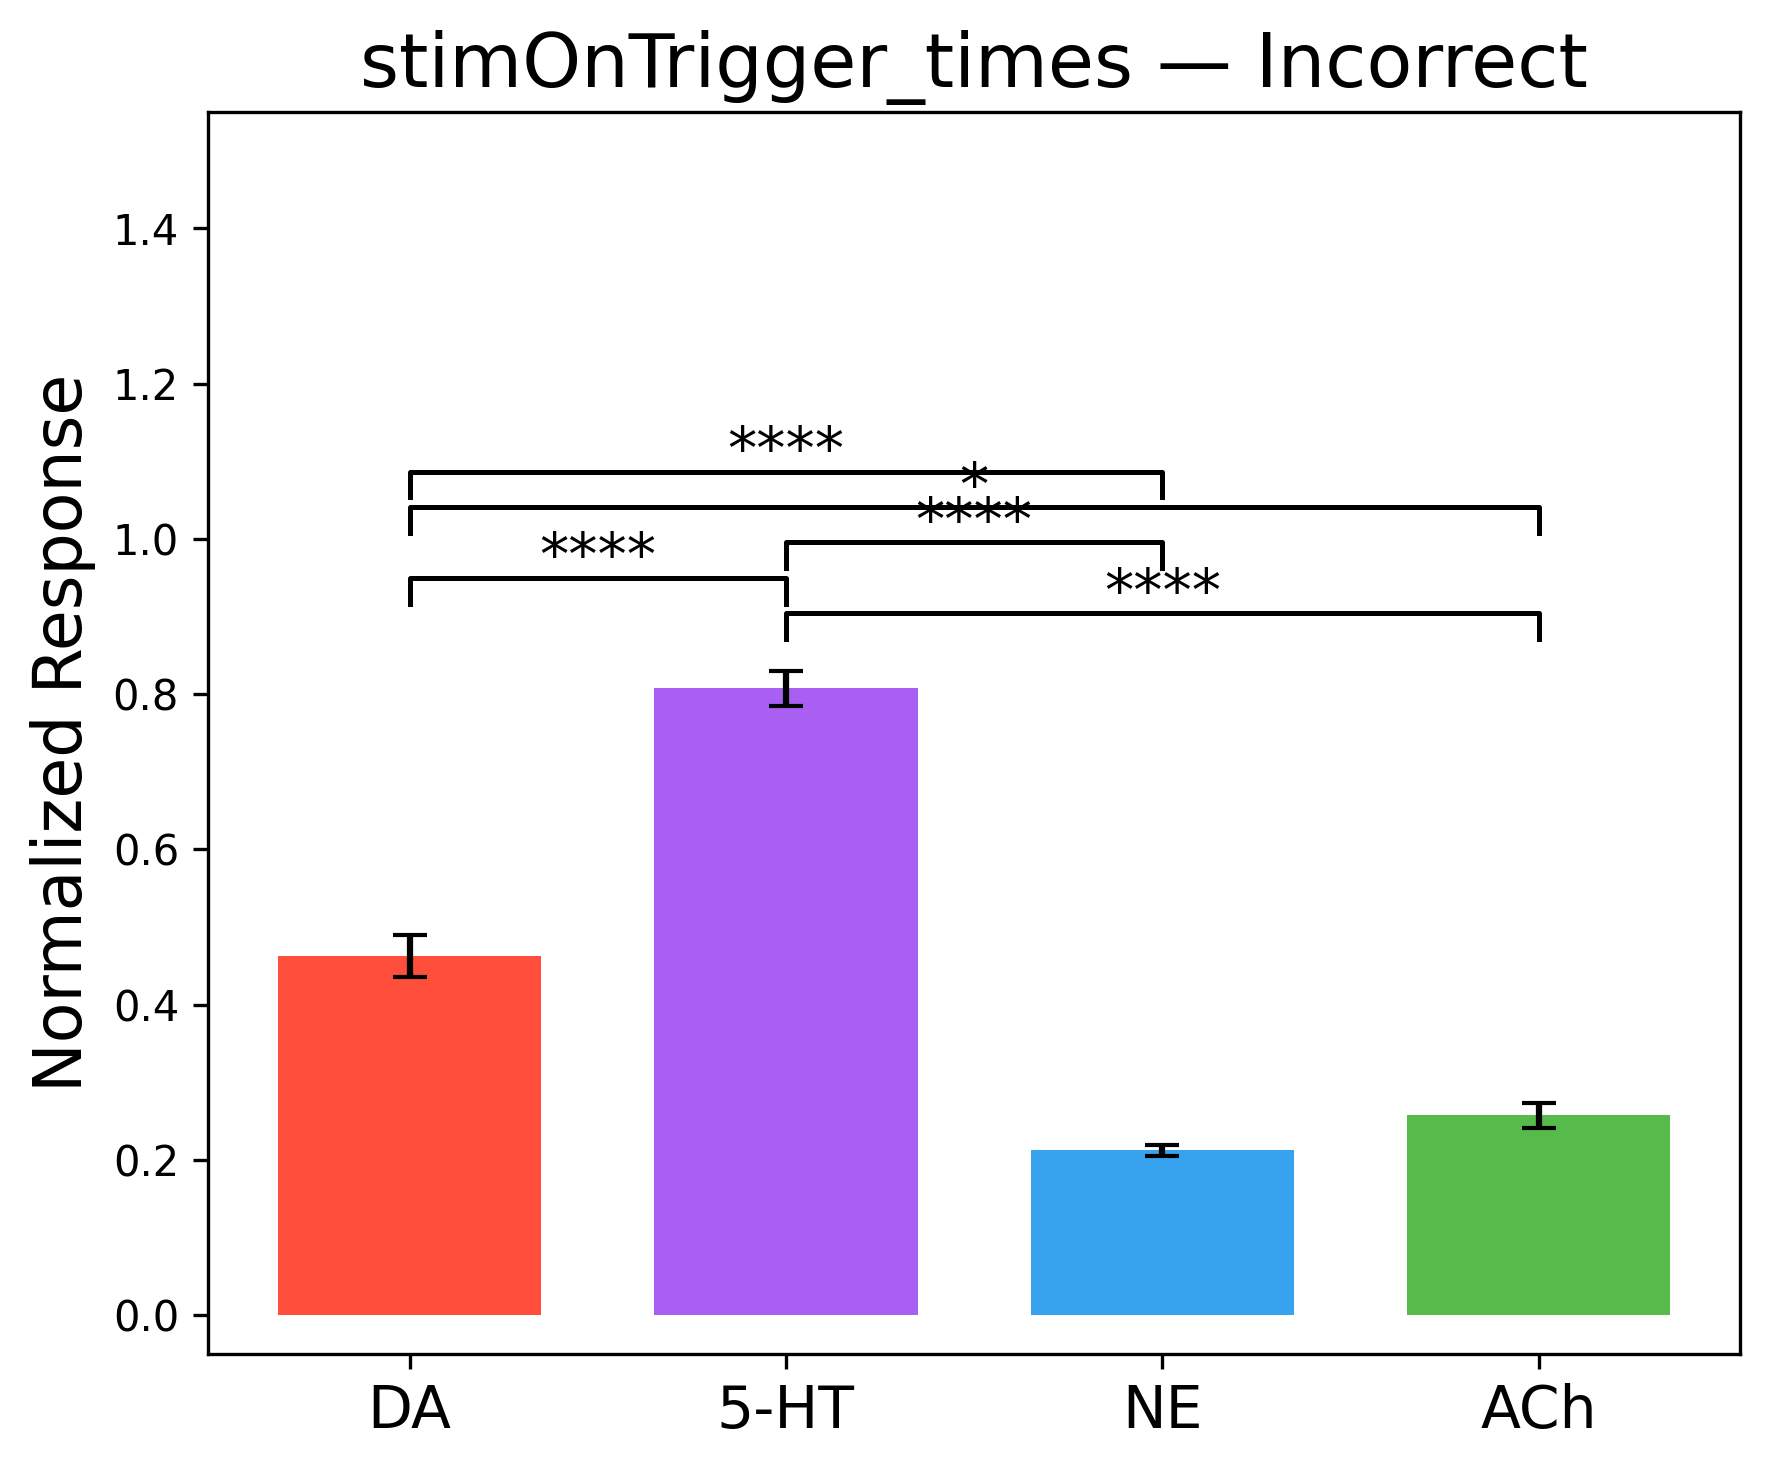

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pingouin as pg

# ============================
# Helpers
# ============================
def pad_to_match_length(arr, target_length):
    current_length = arr.shape[0]
    if current_length == target_length:
        return arr
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(arr, ((0, padding), (0, 0)), mode='constant')
    else:
        return arr[:target_length, :]

def interpolate_to_common_time(psth, current_rate, target_rate, PERIEVENT_WINDOW):
    from scipy.interpolate import interp1d
    old_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], psth.shape[0])
    new_len = int((PERIEVENT_WINDOW[1] - PERIEVENT_WINDOW[0]) * target_rate) + 1
    new_time = np.linspace(PERIEVENT_WINDOW[0], PERIEVENT_WINDOW[1], new_len)
    interp = interp1d(old_time, psth, axis=0, kind='linear')
    return interp(new_time)

def p_to_stars(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

def load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW):
    combined_psth = []
    combined_trials = []
    max_time_length = 0

    for mouse in group_mice:
        try:
            psth_path_30 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_30Hz.npy')
            psth_path_15 = os.path.join(path_to_data, f'psth_{mouse}_{event}_allsessions_15Hz.npy')
            df_trials_path_30 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_30Hz.pqt')
            df_trials_path_15 = os.path.join(path_to_data, f'df_trials_{mouse}_{event}_allsessions_15Hz.pqt')

            if os.path.exists(psth_path_30):
                psth = np.load(psth_path_30)
                df_trials = pd.read_parquet(df_trials_path_30)
            elif os.path.exists(psth_path_15):
                psth = np.load(psth_path_15)
                psth = interpolate_to_common_time(psth, 15, 30, PERIEVENT_WINDOW)
                df_trials = pd.read_parquet(df_trials_path_15)
            else:
                continue

            max_time_length = max(max_time_length, psth.shape[0])
            combined_psth.append(psth)
            combined_trials.append(df_trials)

        except Exception as e:
            print(f"Error loading {mouse} {event}: {e}")

    if combined_psth and combined_trials:
        combined_psth = [pad_to_match_length(psth, max_time_length) for psth in combined_psth]
        psth_combined = np.concatenate(combined_psth, axis=1)
        df_trials_combined = pd.concat(combined_trials, ignore_index=True)
        return psth_combined, df_trials_combined
    else:
        return None, None

def plot_NM_barplot(df_values, event_label, feedback_label, color_palette, ylim=None):
    nms = df_values['group_name'].unique()
    means = df_values.groupby('group_name')['value'].mean().reindex(nms).values
    sems = df_values.groupby('group_name')['value'].sem().reindex(nms).values
    colors = [color_palette[nm] for nm in nms]

    x = np.arange(len(nms))
    bar_width = 0.7

    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    for i in range(len(x)):
        ax.bar(x[i], means[i], width=bar_width, yerr=sems[i], color=colors[i], alpha=0.9, capsize=4)

    aov = pg.anova(data=df_values, dv='value', between='group_name', detailed=True)
    posthoc = pg.pairwise_tukey(data=df_values, dv='value', between='group_name')

    y_max = np.max(means + sems)
    y_offset = y_max * 0.05
    current_y = y_max + y_offset
    label_to_x = {label: xi for label, xi in zip(nms, x)}

    for _, row in posthoc.iterrows():
        if row['p-tukey'] < 0.05:
            i1, i2 = label_to_x[row['A']], label_to_x[row['B']]
            x1, x2 = min(i1, i2), max(i1, i2)
            ax.plot([x1, x1, x2, x2],
                    [current_y, current_y + y_offset * 0.8, current_y + y_offset * 0.8, current_y],
                    lw=1.2, c='black')
            ax.text((x1 + x2) / 2, current_y + y_offset * 0.5, p_to_stars(row['p-tukey']),
                    ha='center', va='bottom', fontsize=14)
            current_y += y_offset * 1.1

    ax.set_xticks(x)
    ax.set_xticklabels(nms, fontsize=14)
    ax.set_ylabel("Normalized Response", fontsize=16)
    ax.set_title(f"{event_label} — {feedback_label}", fontsize=18)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()

# ============================
# Main
# ============================
groups = {
    "DA": ["ZFM-03447", "ZFM-04026", "ZFM-04022_R", "ZFM-03448", "ZFM-04019", "ZFM-04022_L"],
    "5-HT": ["ZFM-03059", "ZFM-03065", "ZFM-03061", "ZFM-03062", "ZFM-04392_DRN", "ZFM-05235", "ZFM-05236", "ZFM-05245", "ZFM-05248"],
    "NE": ["ZFM-04533", "ZFM-04534_LC", "ZFM-06268", "ZFM-06271", "ZFM-06272_L", "ZFM-06272_R", "ZFM-06171", "ZFM-06275_L", "ZFM-06275_R"],
    "ACh": ["ZFM-06305_L", "ZFM-06948"]
}
color_palette = {
    "DA": "#FF3B25",
    "5-HT": "#9F4DF1",
    "NE": "#2198ED",
    "ACh": "#45B437"
}

path_to_data = "/home/kceniabougrova/Documents/NM_project_fromIBLserver/Good_sessions"
time_vector = np.linspace(-1, 2, 91)
baseline_idx = np.where((time_vector >= -0.2) & (time_vector < 0))[0]
response_idx = np.where((time_vector >= 0) & (time_vector < 0.5))[0]
PERIEVENT_WINDOW = [-1, 2]

event = 'stimOnTrigger_times'
feedback_types = {'Correct': 1, 'Incorrect': -1}

# Collect data
all_y_values = []
all_df_values = {}
for fb_label, fb_code in feedback_types.items():
    all_data = []
    for group_name, group_mice in groups.items():
        psth_combined, df_trials_combined = load_group_data(group_mice, event, path_to_data, PERIEVENT_WINDOW)
        if psth_combined is None:
            continue
        if psth_combined.shape[0] == 91:
            psth_combined = psth_combined.T

        idx = df_trials_combined['feedbackType'].values == fb_code
        psth_subset = psth_combined[idx]
        if psth_subset.shape[0] < 5:
            continue

        baseline = np.mean(psth_subset[:, baseline_idx], axis=1, keepdims=True)
        baseline_std = np.std(psth_subset[:, baseline_idx], axis=1, keepdims=True)
        aligned = psth_subset - baseline
        normalized = aligned / (np.abs(baseline_std) + 1e-6)
        response = np.mean(normalized[:, response_idx], axis=1)

        for val in response:
            all_data.append({'value': val, 'group_name': group_name})

    df_values = pd.DataFrame(all_data)
    if df_values.empty:
        print(f"No data for {event} {fb_label}")
        continue
    all_y_values.extend(df_values["value"].values)
    all_df_values[fb_label] = df_values

# Global ylim
ymin = min(0, np.percentile(all_y_values, 5))
ymax = np.percentile(all_y_values, 95) * 1.2
if ymax - ymin < 1:
    ymax = ymin + 1

# Plot
for fb_label, df_values in all_df_values.items():
    plot_NM_barplot(df_values, event, fb_label, color_palette, ylim=(-0.05, 1.55))

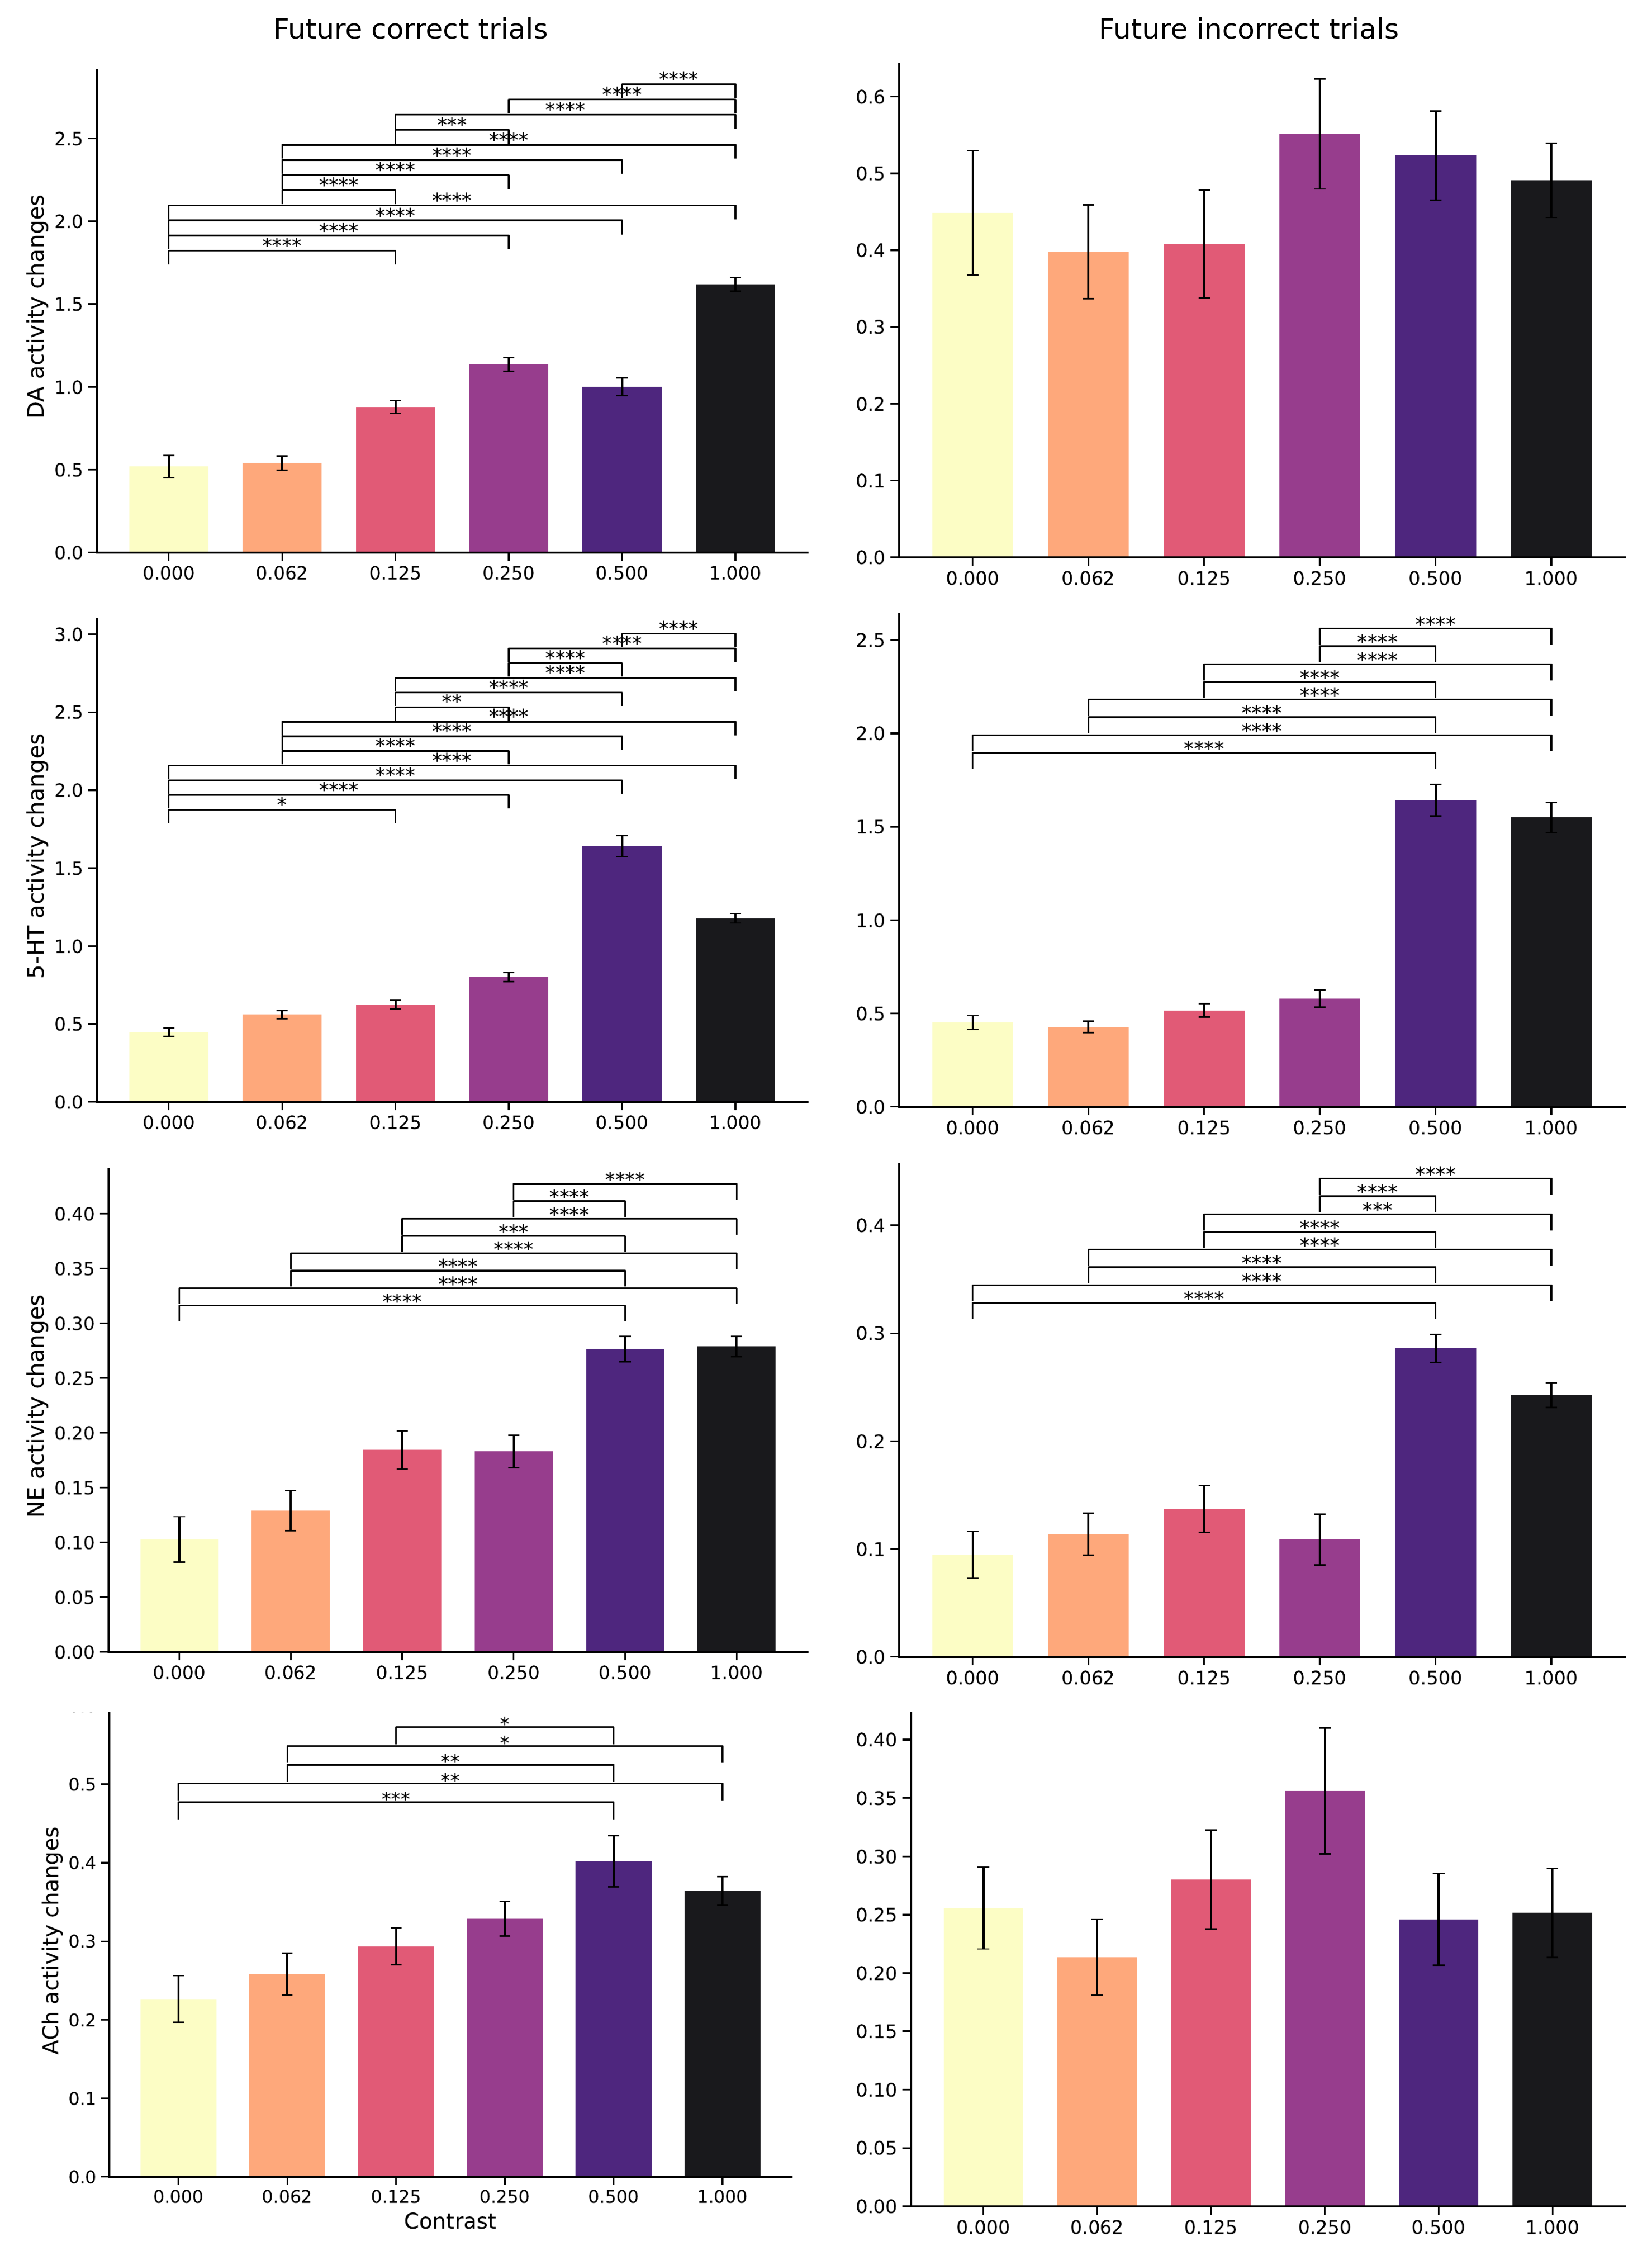

In [5]:
""" USED - TO JOIN THE 8 PLOTS - CONTRASTS """ 

import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image

# Define the figure paths and names
figure_path = '/home/kceniabougrova/Documents/Thesis_correction_figures/Contrasts/'

# Figure names in the desired order
figure_names = [
    'barplot_DA_stimOnTrigger_times_Correct.pdf',
    'barplot_DA_stimOnTrigger_times_Incorrect.pdf',
    'barplot_5-HT_stimOnTrigger_times_Correct.pdf',
    'barplot_5-HT_stimOnTrigger_times_Incorrect.pdf',
    'barplot_NE_stimOnTrigger_times_Correct.pdf',
    'barplot_NE_stimOnTrigger_times_Incorrect.pdf',
    'barplot_ACh_stimOnTrigger_times_Correct.pdf',
    'barplot_ACh_stimOnTrigger_times_Incorrect.pdf'
]

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(10, 14), dpi=300)  # Increase figure height

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define how much to crop from the top (e.g., 90 pixels)
crop_top = 90

# Define how much to crop from the bottom of the plots (for the first 3 rows)
crop_bottom = 65  # Adjust this value based on your needs

# Define how much to crop from the left side of the second column
crop_left = 63  # Adjust this value as needed (in pixels)

# Loop over the images and add them to the subplots
for i, figure_name in enumerate(figure_names):
    img_path = figure_path + figure_name
    
    # Convert PDF to image (first page, as we assume each PDF is a single page)
    images = convert_from_path(img_path, first_page=1, last_page=1)
    
    # Get the first image from the list
    img = images[0]
    
    # Crop the image: (left, top, right, bottom)
    width, height = img.size
    
    # If in the second column (i = 1, 3, 5, 7), apply the left crop
    if i % 2 == 1:
        img_cropped = img.crop((crop_left, crop_top, width, height - crop_bottom))  # Crop left, top, and bottom
    else:
        if i < 6:  # Crop the bottom of the first 3 rows (i.e., indices 0, 1, 2, 3, 4, 5)
            img_cropped = img.crop((0, crop_top, width, height - crop_bottom))  # Crop from top and bottom
        else:
            img_cropped = img.crop((0, crop_top, width, height))  # Only crop from the top for the last row

    # Plot the cropped image in the appropriate subplot
    axes[i].imshow(img_cropped)
    axes[i].axis('off')  # Hide axis for better appearance

# Adjust space at the top to prevent title overlap with the plots
fig.subplots_adjust(top=0.92)  # Adjust the top margin to create more space

# Add text at the top of the figure
fig.text(0.25, 0.95, 'Future correct trials', ha='center', fontsize=12)
fig.text(0.75, 0.95, 'Future incorrect trials', ha='center', fontsize=12)

# Adjust layout to avoid any overlap between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Keeps the top part adjusted

# Save the final panel as a PDF
plt.savefig('/home/kceniabougrova/Documents/Thesis_correction_figures/Final_Figure_Panel_Cropped_Adjusted_Left_Crop.pdf', format='pdf')
plt.show()

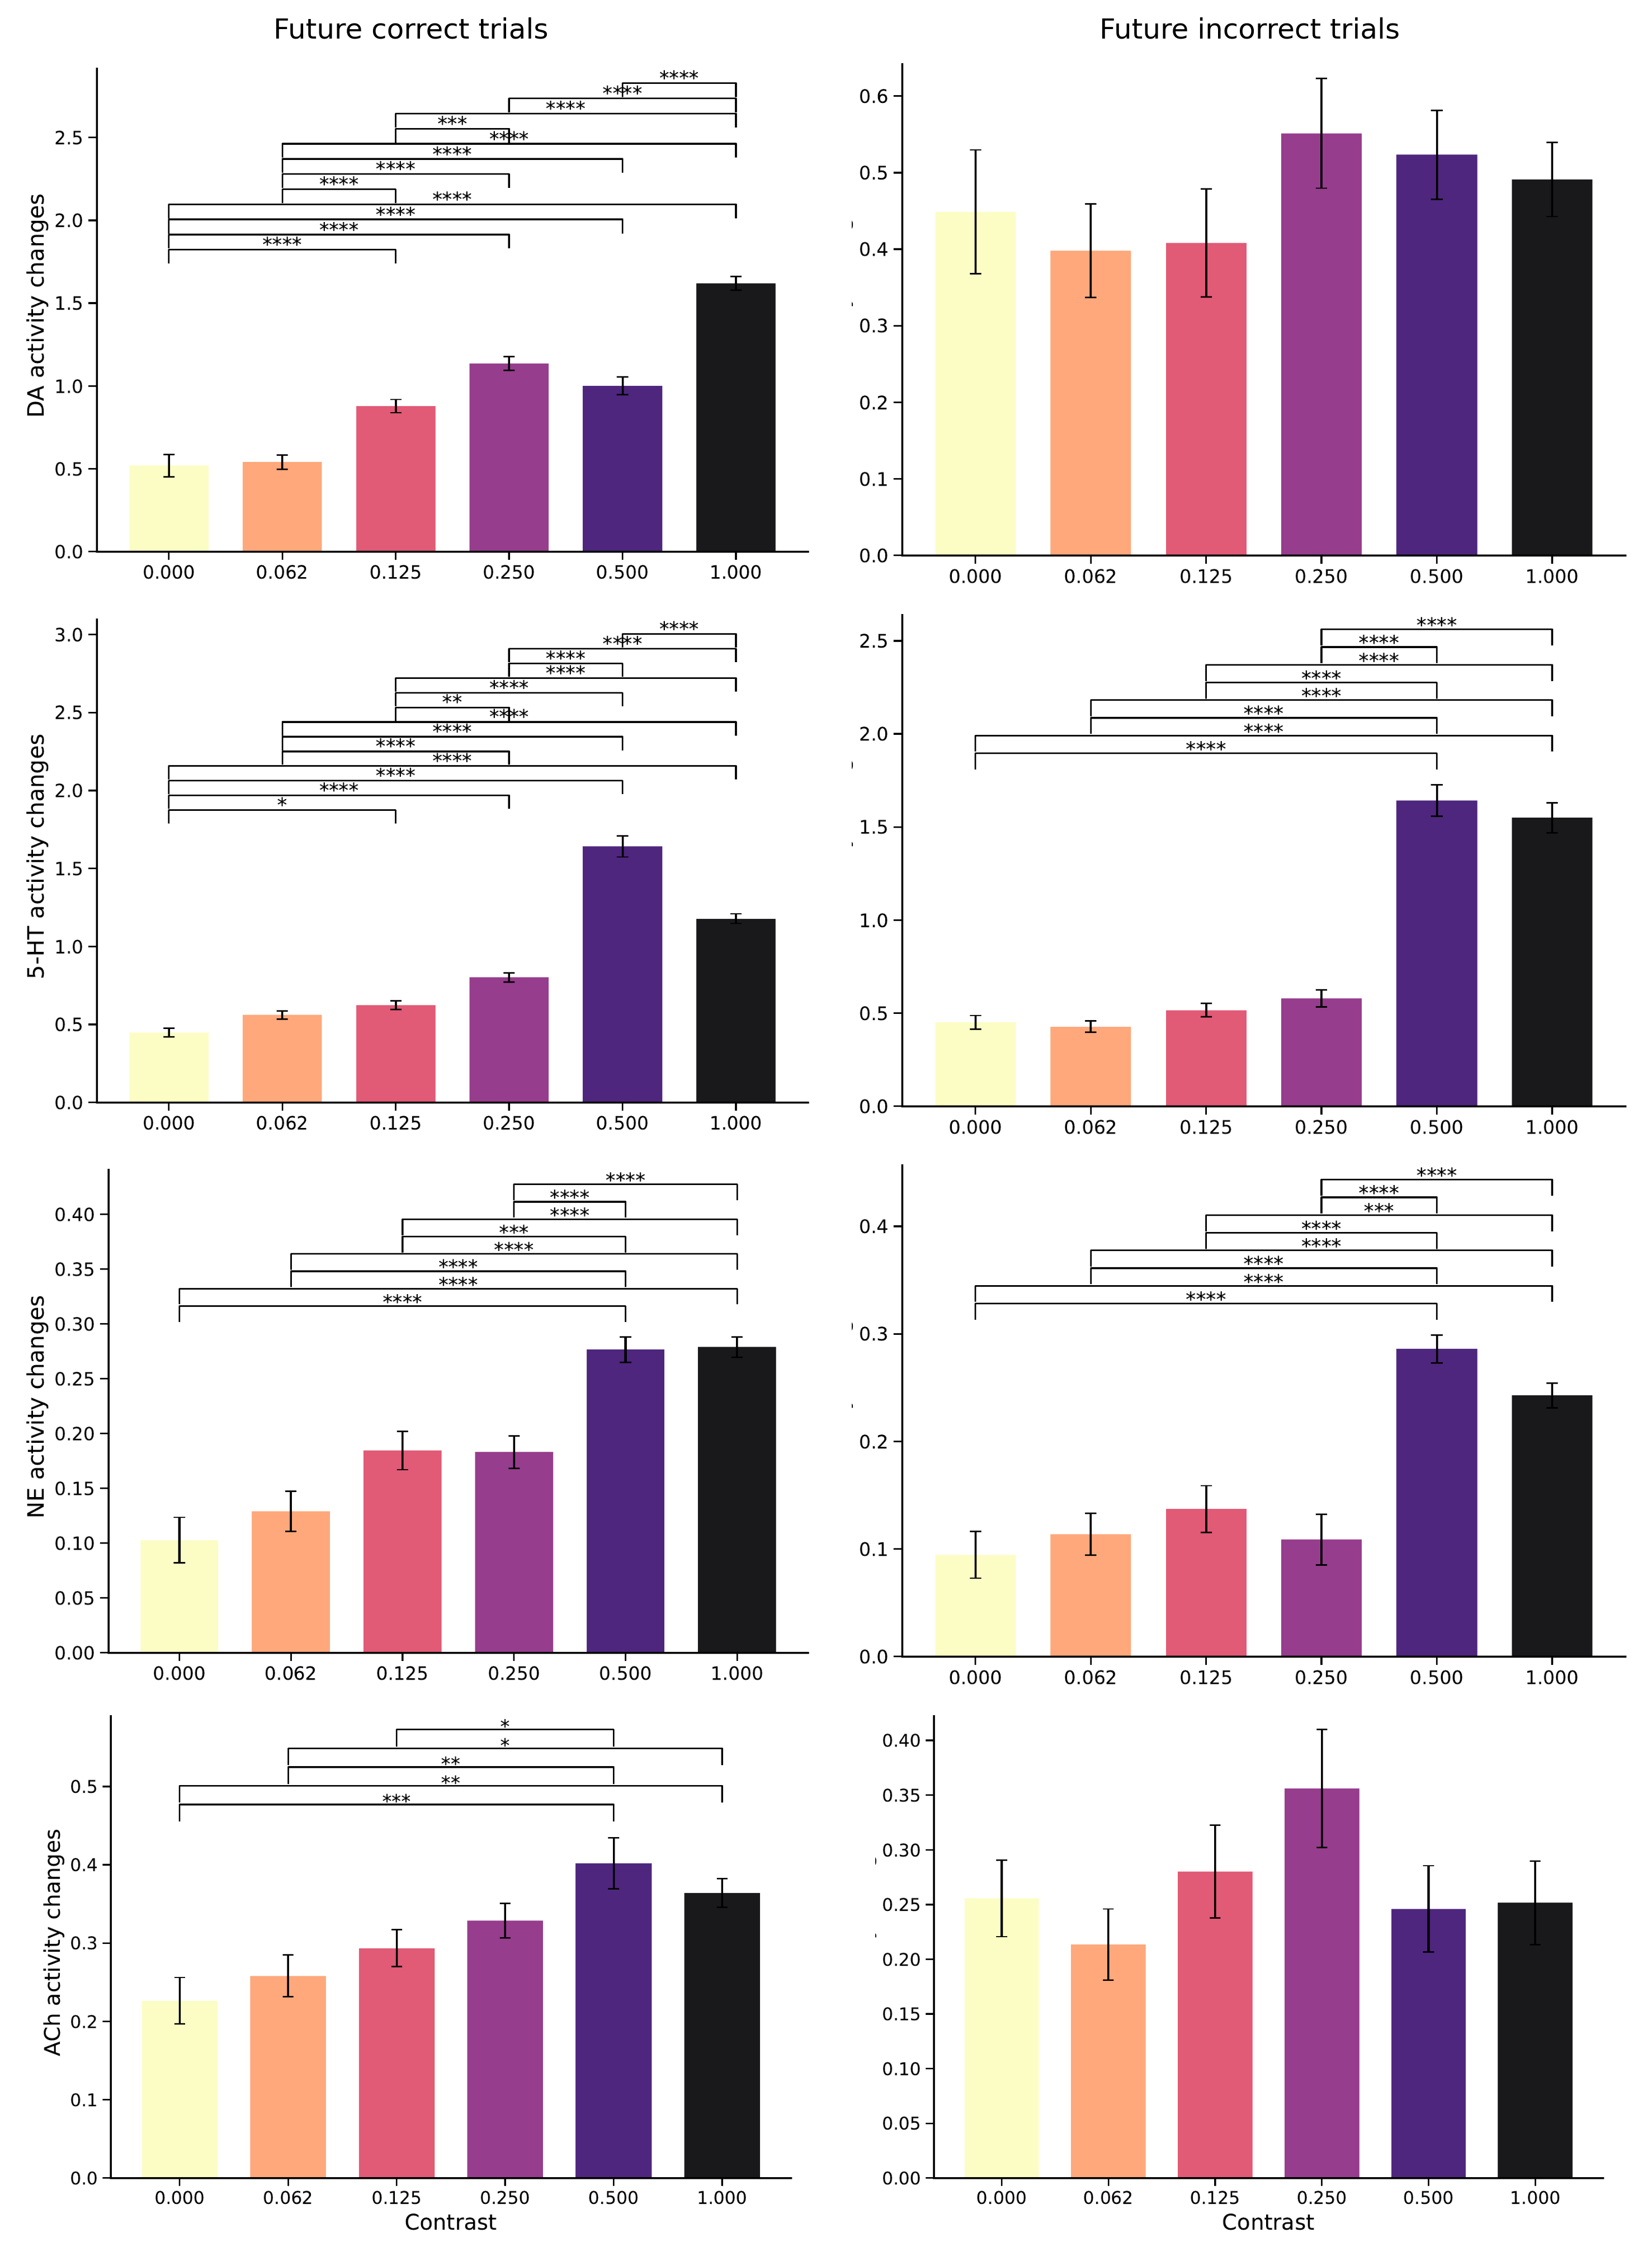

In [6]:
""" USED - WORKS - FOR CONTRASTS""" 
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image

# Define the figure paths and names
figure_path = '/home/kceniabougrova/Documents/Thesis_correction_figures/Contrasts/'

# Figure names in the desired order
figure_names = [
    'barplot_DA_stimOnTrigger_times_Correct.pdf',
    'barplot_DA_stimOnTrigger_times_Incorrect.pdf',
    'barplot_5-HT_stimOnTrigger_times_Correct.pdf',
    'barplot_5-HT_stimOnTrigger_times_Incorrect.pdf',
    'barplot_NE_stimOnTrigger_times_Correct.pdf',
    'barplot_NE_stimOnTrigger_times_Incorrect.pdf',
    'barplot_ACh_stimOnTrigger_times_Correct.pdf',
    'barplot_ACh_stimOnTrigger_times_Incorrect.pdf'
]

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(10, 14), dpi=300)  # Increase figure height

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define how much to crop from the top (e.g., 85 pixels)
crop_top = 90

# Define how much to crop from the bottom of the plots (for the first 3 rows)
crop_bottom = 65  # Adjust this value based on your needs

# Define how much to crop from the left for the second column
crop_left = 60  # Adjust this value as needed

# Loop over the images and add them to the subplots
for i, figure_name in enumerate(figure_names):
    img_path = figure_path + figure_name
    
    # Convert PDF to image (first page, as we assume each PDF is a single page)
    images = convert_from_path(img_path, first_page=1, last_page=1)
    
    # Get the first image from the list
    img = images[0]
    
    # Crop the image: (left, top, right, bottom)
    width, height = img.size
    
    # Apply left-side cropping to the second column (i = 1, 3, 5, 7)
    if i % 2 == 1:  # Check if it's in the second column (1, 3, 5, 7)
        if i == 7:  # For the last figure in the second column (4th row, 2nd column), don't crop the bottom
            img_cropped = img.crop((crop_left, crop_top, width, height))  # Crop left and top, no bottom crop
        else:
            img_cropped = img.crop((crop_left, crop_top, width, height - crop_bottom))  # Crop left, top, and bottom
    else:
        if i < 6:  # Crop the bottom of the first 3 rows (i.e., indices 0, 1, 2, 3, 4, 5)
            img_cropped = img.crop((0, crop_top, width, height - crop_bottom))  # Crop from top and bottom
        else:
            img_cropped = img.crop((0, crop_top, width, height))  # Only crop from the top for the last row

    # Plot the cropped image in the appropriate subplot
    axes[i].imshow(img_cropped)
    axes[i].axis('off')  # Hide axis for better appearance

# Adjust space at the top to prevent title overlap with the plots
fig.subplots_adjust(top=0.92)  # Adjust the top margin to create more space

# Add text at the top of the figure
fig.text(0.25, 0.95, 'Future correct trials', ha='center', fontsize=12)
fig.text(0.75, 0.95, 'Future incorrect trials', ha='center', fontsize=12)

# Adjust layout to avoid any overlap between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Keeps the top part adjusted

# Save the final panel as a PDF
# plt.savefig('/home/kceniabougrova/Documents/Thesis_correction_figures/FINAL_CONTRASTS_Panel_Cropped_.pdf', format='pdf')
plt.show()


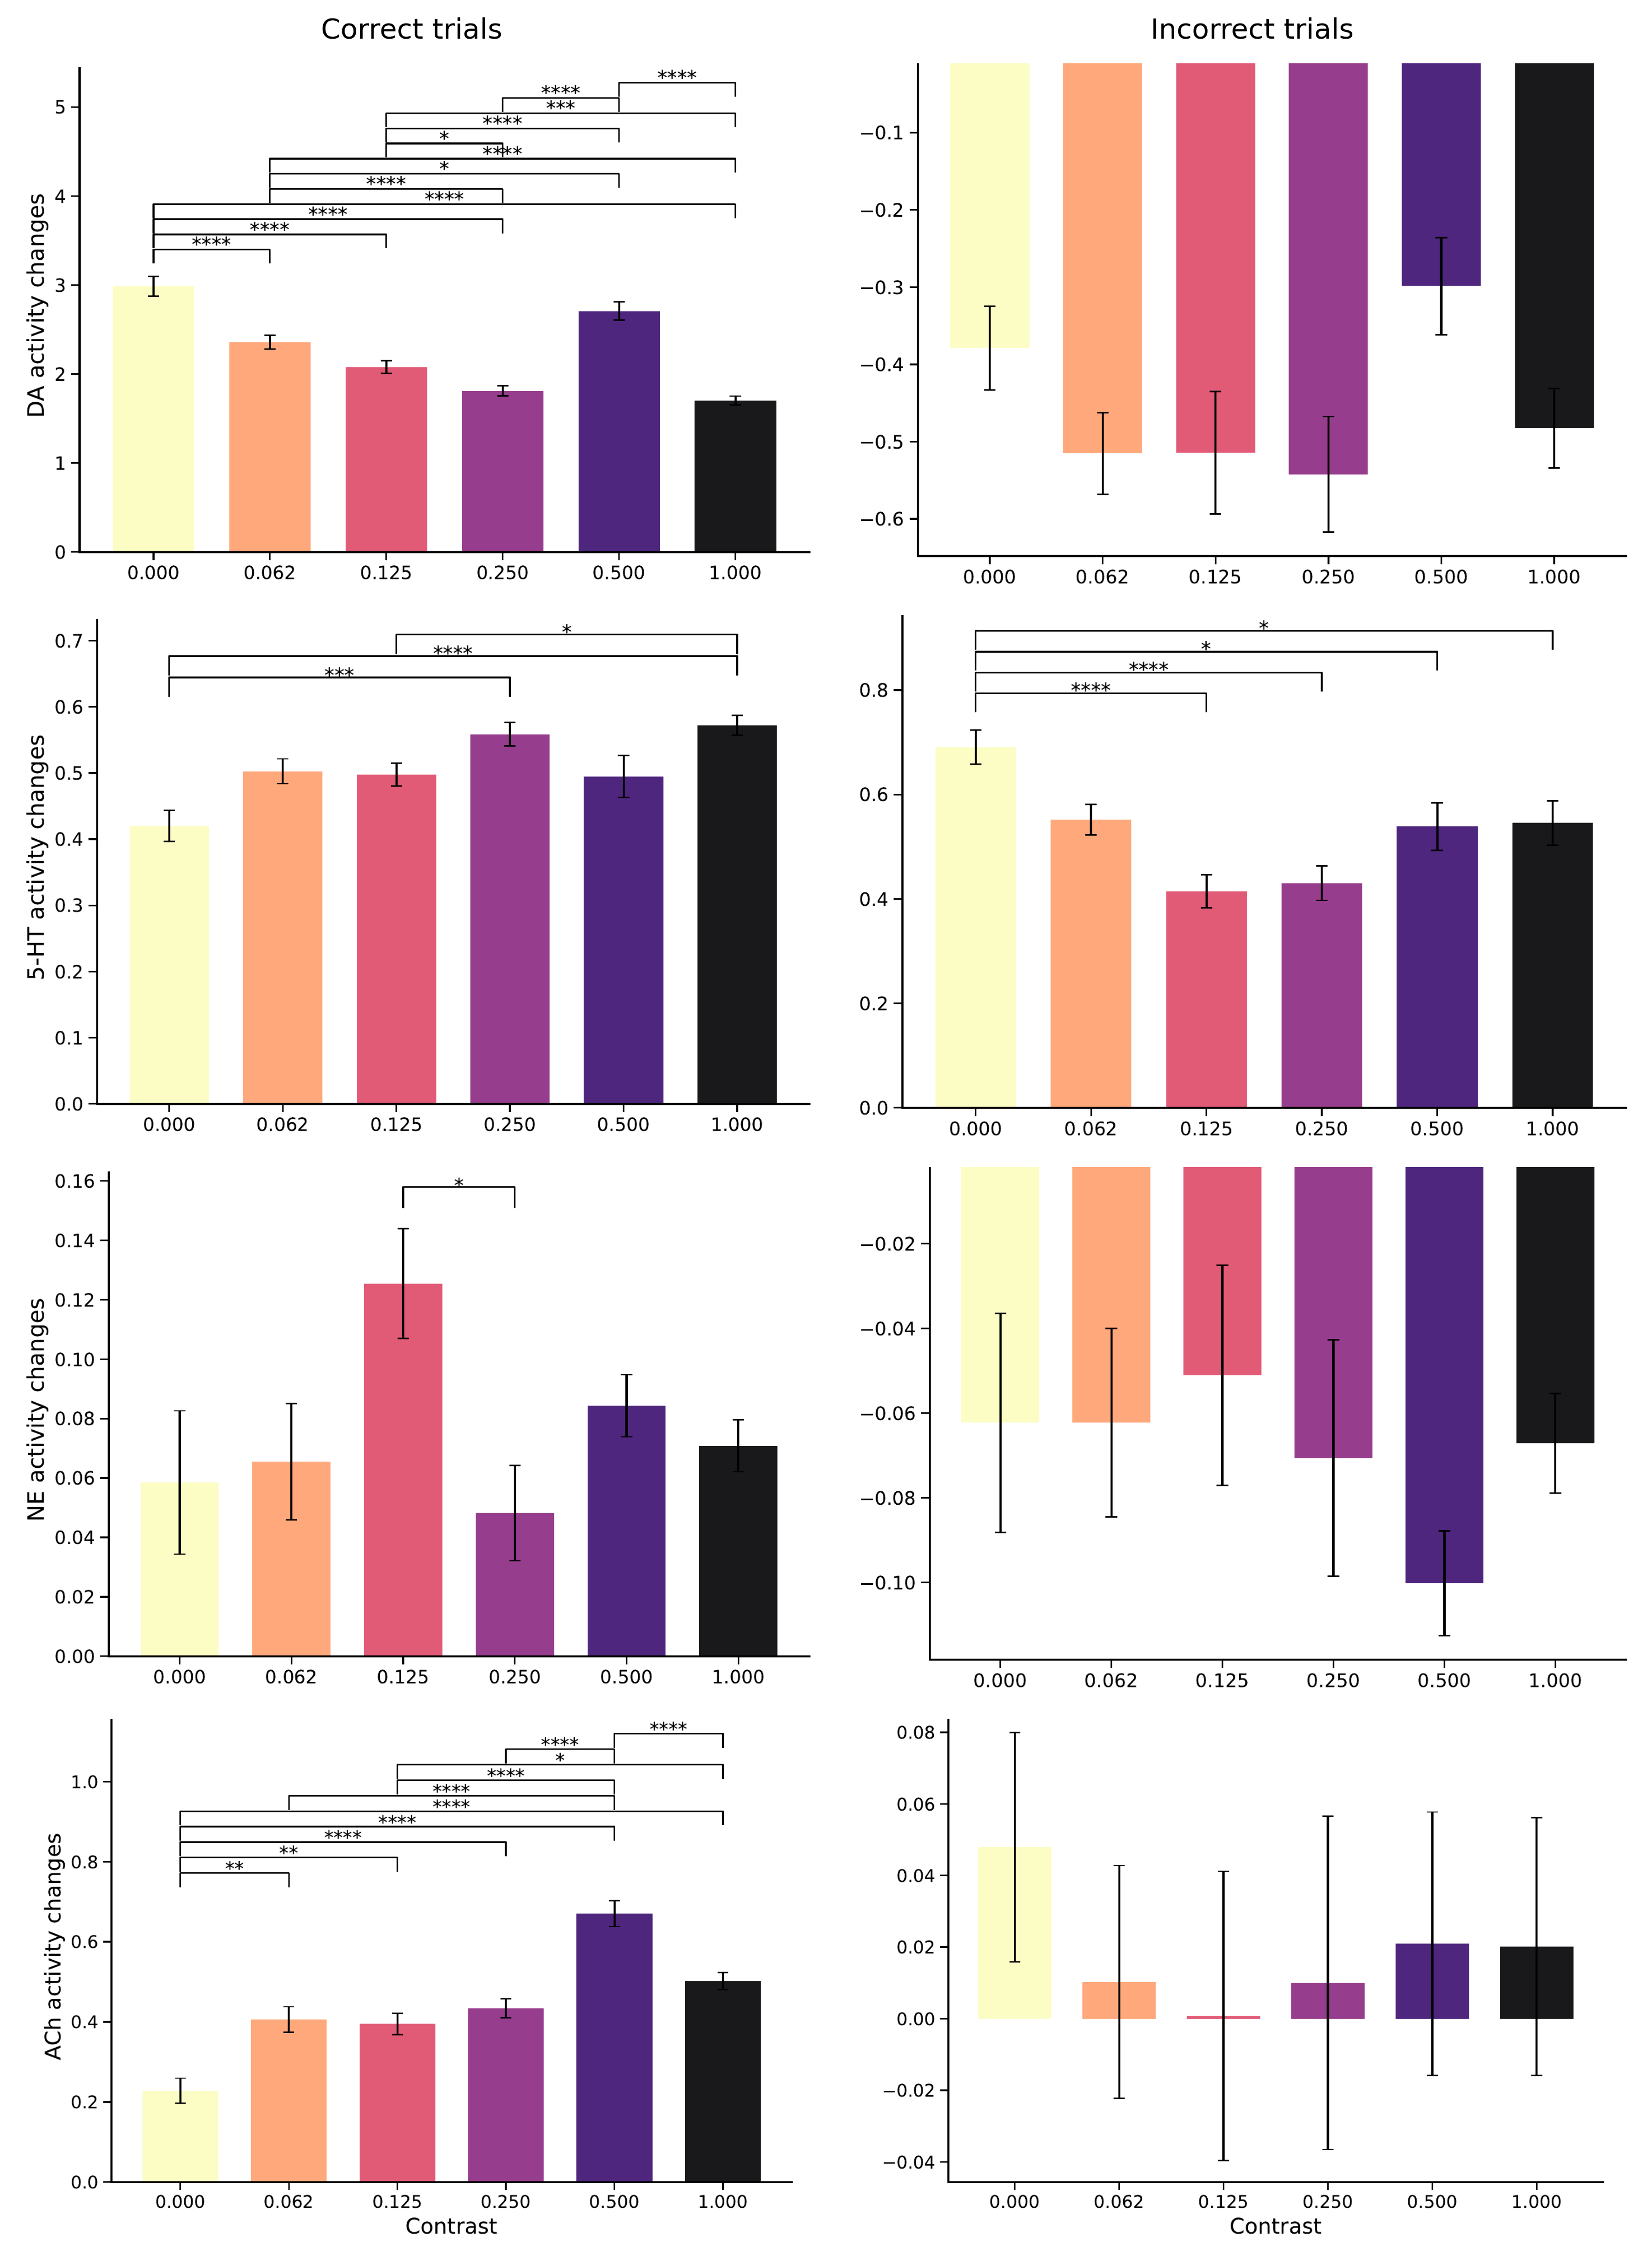

In [7]:
""" USED - same but for feedback_type """
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image

# Define the figure paths and names
figure_path = '/home/kceniabougrova/Documents/Thesis_correction_figures/Contrasts/'

# Figure names in the desired order

figure_names = [
    'barplot_DA_feedback_times_Correct.pdf',
    'barplot_DA_feedback_times_Incorrect.pdf',
    'barplot_5-HT_feedback_times_Correct.pdf',
    'barplot_5-HT_feedback_times_Incorrect.pdf',
    'barplot_NE_feedback_times_Correct.pdf',
    'barplot_NE_feedback_times_Incorrect.pdf',
    'barplot_ACh_feedback_times_Correct.pdf',
    'barplot_ACh_feedback_times_Incorrect.pdf'
]


# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(10, 14), dpi=300)  # Increase figure height

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define how much to crop from the top (e.g., 85 pixels)
crop_top = 90

# Define how much to crop from the bottom of the plots (for the first 3 rows)
crop_bottom = 65  # Adjust this value based on your needs

# Define how much to crop from the left for the second column
crop_left = 68  # Adjust this value as needed

# Loop over the images and add them to the subplots
for i, figure_name in enumerate(figure_names):
    img_path = figure_path + figure_name
    
    # Convert PDF to image (first page, as we assume each PDF is a single page)
    images = convert_from_path(img_path, first_page=1, last_page=1)
    
    # Get the first image from the list
    img = images[0]
    
    # Crop the image: (left, top, right, bottom)
    width, height = img.size
    
    # Apply left-side cropping to the second column (i = 1, 3, 5, 7)
    if i % 2 == 1:  # Check if it's in the second column (1, 3, 5, 7)
        if i == 7:  # For the last figure in the second column (4th row, 2nd column), don't crop the bottom
            img_cropped = img.crop((crop_left, crop_top, width, height))  # Crop left and top, no bottom crop
        else:
            img_cropped = img.crop((crop_left, crop_top, width, height - crop_bottom))  # Crop left, top, and bottom
    else:
        if i < 6:  # Crop the bottom of the first 3 rows (i.e., indices 0, 1, 2, 3, 4, 5)
            img_cropped = img.crop((0, crop_top, width, height - crop_bottom))  # Crop from top and bottom
        else:
            img_cropped = img.crop((0, crop_top, width, height))  # Only crop from the top for the last row

    # Plot the cropped image in the appropriate subplot
    axes[i].imshow(img_cropped)
    axes[i].axis('off')  # Hide axis for better appearance

# Adjust space at the top to prevent title overlap with the plots
fig.subplots_adjust(top=0.92)  # Adjust the top margin to create more space

# Add text at the top of the figure
fig.text(0.25, 0.95, 'Correct trials', ha='center', fontsize=12)
fig.text(0.75, 0.95, 'Incorrect trials', ha='center', fontsize=12)

# Adjust layout to avoid any overlap between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Keeps the top part adjusted

# Save the final panel as a PDF
# plt.savefig('/home/kceniabougrova/Documents/Thesis_correction_figures/FINAL_CONTRASTS_feedback__Panel_Cropped.pdf', format='pdf')
plt.show()

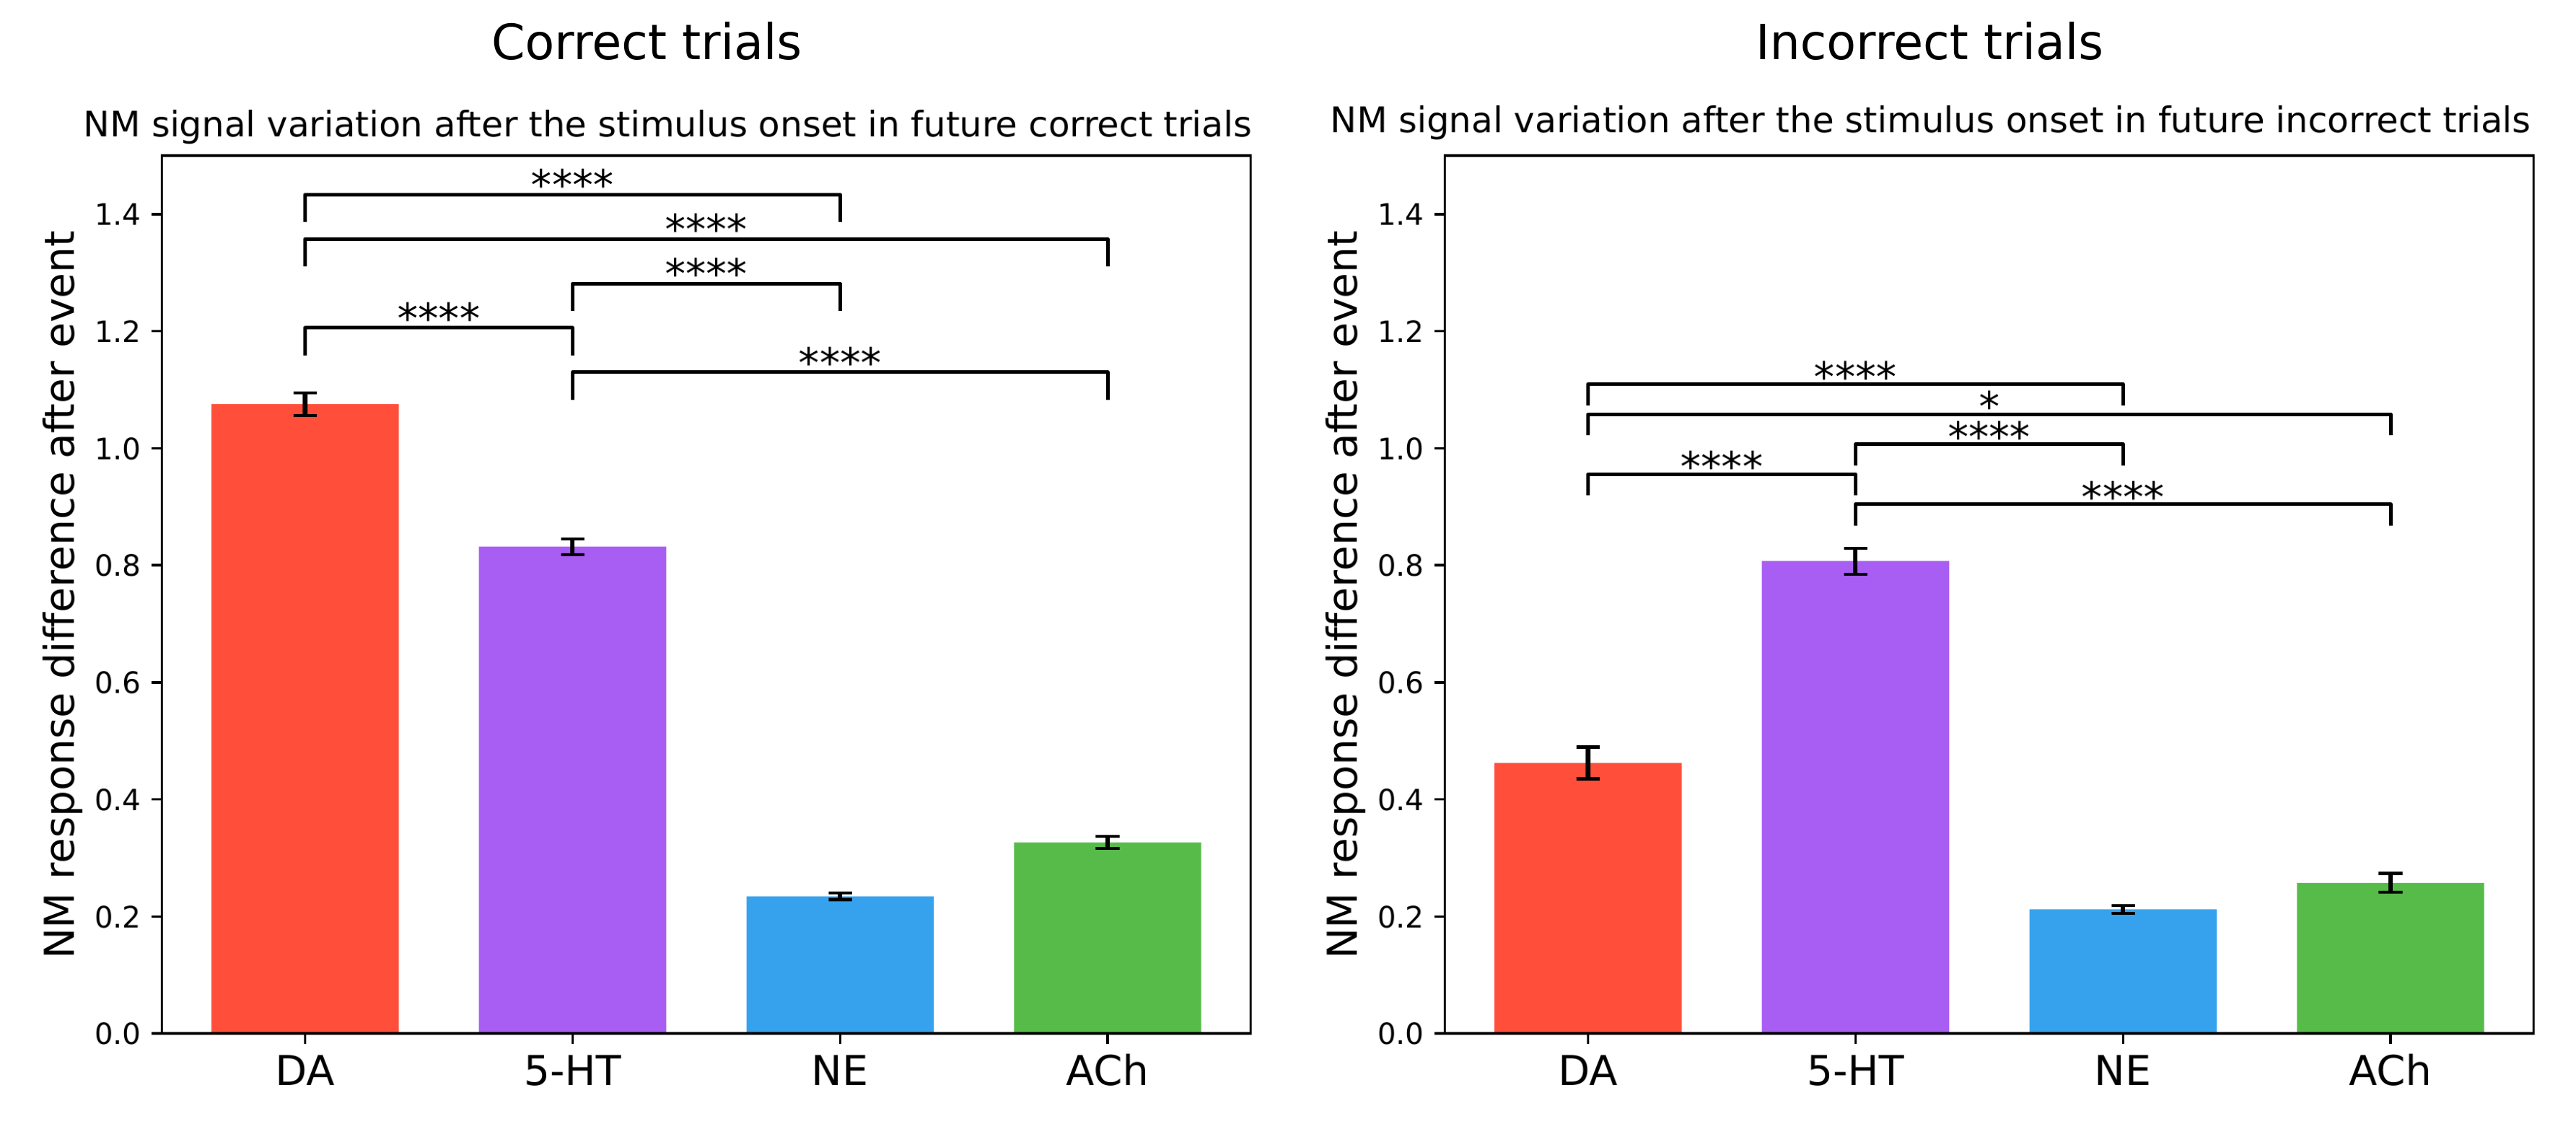

In [26]:
""" NMs stim """
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image

# Define the figure paths and names
figure_path = '/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/'

figure_names = [
    'barplot_stimOnTrigger_times_Correct_final.pdf',
    'barplot_stimOnTrigger_times_Incorrect_final.pdf'
]

# Convert PDFs to PIL images
images = [convert_from_path(figure_path + name, dpi=300)[0] for name in figure_names]

# Create matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Add each image
for ax, img, title in zip(axes, images, ['Correct trials', 'Incorrect trials']):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=16)

plt.tight_layout()

# Save combined figure
output_path = figure_path + 'Combined_barplots_stimOn_times2.pdf'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

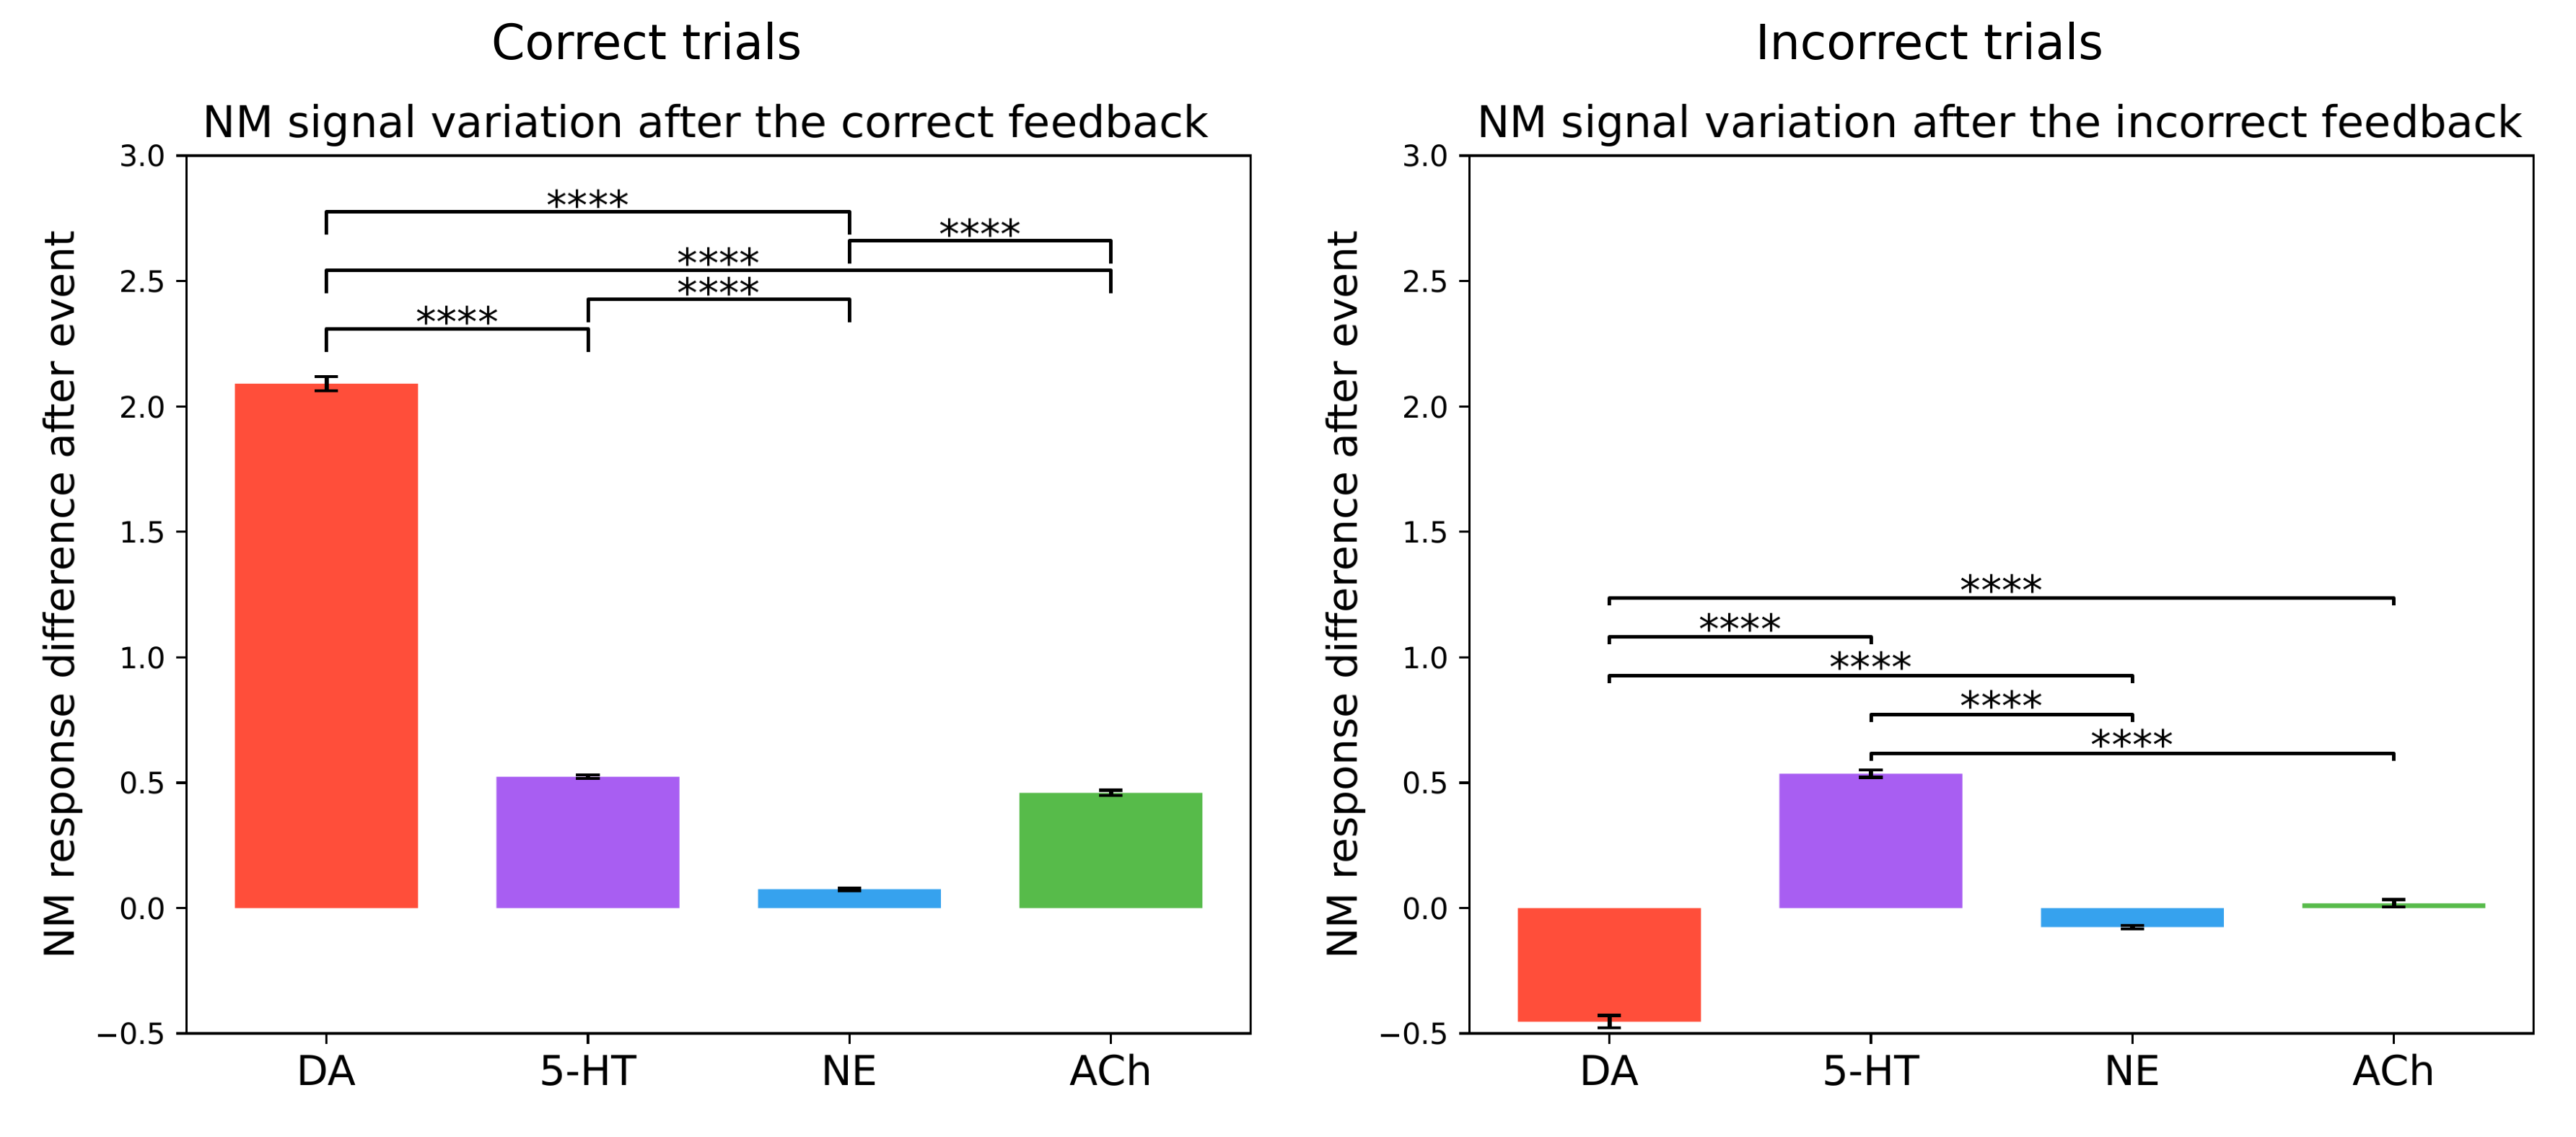

In [27]:
""" NMs feedback """ 
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image

# Define the figure paths and names
figure_path = '/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/'

figure_names = [
    'barplot_feedback_times_Correct_final.pdf',
    'barplot_feedback_times_Incorrect_final.pdf'
]

# Convert PDFs to PIL images
images = [convert_from_path(figure_path + name, dpi=300)[0] for name in figure_names]

# Create matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Add each image
for ax, img, title in zip(axes, images, ['Correct trials', 'Incorrect trials']):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=16)

plt.tight_layout()

# Save combined figure
output_path = figure_path + 'Combined_barplots_feedback_times2.pdf'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


In [37]:
""" to not convert into image """
import fitz  # PyMuPDF

figure_path = "/home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/"

# Load the two PDFs
doc1 = fitz.open(figure_path + "barplot_feedback_times_Correct_final.pdf")
doc2 = fitz.open(figure_path + "barplot_feedback_times_Incorrect_final.pdf")

# Create new empty PDF
new_doc = fitz.open()

# Create new page large enough for both
width1, height1 = doc1[0].rect.width, doc1[0].rect.height
width2, height2 = doc2[0].rect.width, doc2[0].rect.height

new_width = width1 + width2
new_height = max(height1, height2)

new_page = new_doc.new_page(width=new_width, height=new_height)

# Insert first page on the left
new_page.show_pdf_page(fitz.Rect(0, 0, width1, height1), doc1, 0)

# Insert second page on the right
new_page.show_pdf_page(fitz.Rect(width1, 0, new_width, height2), doc2, 0)

# Save
output_path = figure_path + "Combined_barplots_feedback_times_side_by_side.pdf"
new_doc.save(output_path)

print(f"Combined PDF saved to {output_path}")



Combined PDF saved to /home/kceniabougrova/Documents/Thesis_correction_figures/Between_NMs/Combined_barplots_feedback_times_side_by_side.pdf


In [10]:
1+1

2